In [1]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Abs,im,re,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

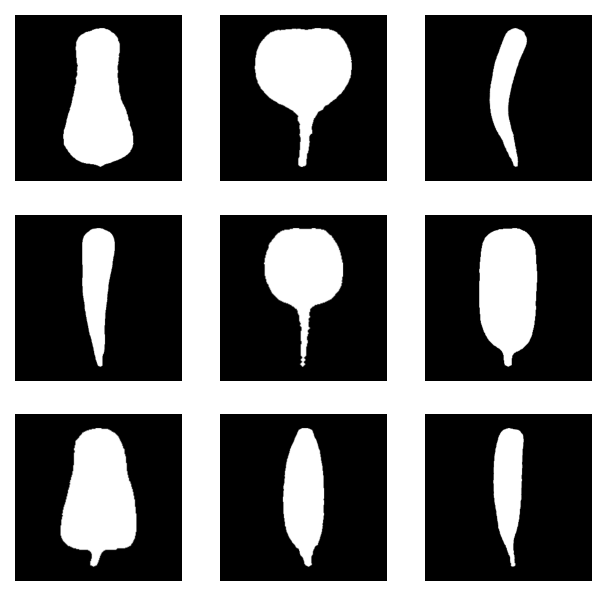

In [2]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [3]:
import time
 
def print_proc_time(f):
    """ 計測デコレータ """
 
    def print_proc_time_func(*args, **kwargs):
        # 開始
        start_time = time.process_time()
 
        # 関数実行
        return_val = f(*args, **kwargs)
 
        # 修了
        end_time = time.process_time()
 
        # 関数名と経過時間を出力(秒)
        elapsed_time = end_time - start_time
        print(f.__name__, elapsed_time)
 
        # 戻り値を返す
        return return_val
 
    return print_proc_time_func

def checkN(imgnum,mode=0,Nsamples=65,Nprolog=3,Nfrom=5,Nto=7,lr=0.005,lrP=400,preTry=100,maxTry=1500,pat=10,err_th=0.5, threstune=1.0,moption=False):
    img = imgs[imgnum]
    config = wandb.config={
          'program':'checkN',
          ''
          'lr':lr,
          'maxTry':maxTry,
          'preTry':preTry,
          'pat':pat,
          'err_th':err_th}
    wandb.init(project="checkN %d" % imgnum,
                 config = config)
    rd.BezierCurve.wandb=wandb

    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')

    bez = rd.BezierCurve(N=0,samples=Samples) # インスタンス生成
    lastN,results = bez.fit2(mode=mode,Nprolog=Nprolog,Nfrom=Nfrom,Nto=Nto,pat=pat,lr=lr,lrP=lrP,err_th=err_th,preTry=preTry,maxTry=maxTry,withErr=True,withEC=True,threstune=threstune,moption=moption)
    cps,func,err = results[str(lastN)]
    rd.drawBez(img,stt=0.0,end=1.0,bezL=func,cntL=Samples)
    print("{:>3d}次でOK".format(lastN))
    return results,err

#from sympy import diff, Symbol, Matrix, symbols, solve, simplify, binomial, Abs, im, re, lambdify
import time

#from statistics import mean
def check1TD(imgnum,N=7,mode=0,LR=0,Nsamples=32,itt=3,lr=0.001,lrP=30000,maxTry=1500,pat=10,err_th=0.75,threstune=1.0,withEC=False,trial=None):
    start = time.process_time()
    rd.BezierCurve.mloop_itt = itt
    # rd.BezierCurve.eq_coe = coe
    img = imgs[imgnum]
    conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=3,dbtmdr=3)
    #conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
    SamplesL = rd.getSamples(conLeft,N=Nsamples,mode='Equidistant')
    SamplesR = rd.getSamples(conRight,N=Nsamples,mode='Equidistant') 
    bezL = rd.BezierCurve(N=N,samples=SamplesL) # インスタンス生成
    bezR = rd.BezierCurve(N=N,samples=SamplesR) # インスタンス生成
    if LR<=1:
        print("Left")
        bestcpsL, bestfuncL, minerrorL = bezL.fit1T(maxTry=maxTry, mode=mode, lr=lr,lrP=lrP,withErr=True, withEC=withEC,tpara=[], pat=pat, err_th=err_th, threstune=threstune,trial=trial,moption=True)
    else:
        bestcpsL, bestfuncL, minerrorL = [],None,(0,0)
    if LR%2==0:
        print("Right")
        bestcpsR, bestfuncR, minerrorR = bezR.fit1T(maxTry=maxTry, mode=mode, lr=lr,lrP=lrP,withErr=True, withEC=withEC,tpara=[], pat=pat, err_th=err_th, threstune=threstune,trial=trial,moption=True)
    else:
        bestcpsR, bestfuncR, minerrorR = [],None,(0,0)
    elapsed_time = time.process_time() - start
    ct=['black','black','black','black','black','black','black','black','black','black']
    rd.drawBez(img,stt=-0.00,end=1.00,bezL=bestfuncL,bezR=bestfuncR,cntL=SamplesL,cntR=SamplesR,savepath="./pics/test.png",ct=ct)
    plt.axis('off')
    if withEC:
        (errorL,trynumL) = minerrorL
        (errorR,trynumR) = minerrorR
        return (errorL,errorR),elapsed_time,(trynumL+1,trynumR+1),(bestcpsL,bestcpsR)  
    else:
        return minerrorL,minerrorR,elapsed_time
    
def checkToD(imgnum,N,LR=0,mode=1,Nsamples=16,err_th=1.0,pat=1000,maxTry=3000,lr=0.001):
    return check1TD(imgnum,N=N,mode=mode,LR=LR,Nsamples=Nsamples,itt=3,lr=lr,maxTry=maxTry,pat=pat,err_th=err_th,threstune=1.0,withEC=True,trial=None)

def check1T11(imgnum,mode=0,LR=0,Nsamples=65,N=7,itt=3,lr=0.001,lrP=30000,maxTry=1500,pat=10,err_th=0.75,threstune=1.0,withEC=False,trial=None):
    start = time.process_time()
    rd.BezierCurve.mloop_itt = itt
    # rd.BezierCurve.eq_coe = coe
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
    
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    bestcps, bestfunc, minerror = bez.fit1T(maxTry=maxTry, mode=mode, lr=lr,lrP=lrP,withErr=True, withEC=withEC,tpara=[], pat=pat, err_th=err_th, threstune=threstune,trial=trial,moption=True)
    elapsed_time = time.process_time() - start
    ct=['black','black','black','black','black','black','black','black','black','black']
    rd.drawBez(img,stt=-0.00,end=1.00,bezL=bestfunc,cntL=Samples,saveImage=True,savepath="./pics/test.png",ct=ct)
    plt.axis('off')
    if withEC:
        (error,trynum) = minerror
        return (error,error),elapsed_time,trynum+1,bestcps 
    else:
        return minerrorL,minerrorR,elapsed_time

def checkTo11(imgnum,N,Nsamples=65,LR=0,mode=1,err_th=1.0,pat=1000,maxTry=3000,lr=0.001):
    return check1T11(imgnum,mode=mode,LR=LR,Nsamples=Nsamples,N=N,itt=3,lr=lr,maxTry=maxTry,pat=pat,err_th=err_th,threstune=1.0,withEC=True,trial=None)
  

# 両側近似結果まとめ

Left
..........
CP 5.0, steps:9, etime: 1.23438 err: 4.5561389271
...........................
CP 2.0, steps:36, etime: 3.45312 err: 1.9904310931
..........................................E

Right
............
CP 5.0, steps:11, etime: 1.37500 err: 4.8628629702
.................
CP 2.0, steps:28, etime: 2.78125 err: 1.9835394218
...................................E



((0.9938952360417692, 0.9987047694792239),
 12.71875,
 (79, 64),
 ([[152.0, 27.0],
   [38.75543252982888, 43.59885292623391],
   [226.78865283251397, 139.37982898404633],
   [-21.004418994483036, 246.0093994820153],
   [149.0, 279.0]],
  [[159.0, 26.0],
   [260.8977607073386, 38.46667552049351],
   [69.86202359494186, 176.25143023648278],
   [336.6917481216665, 229.9097007995843],
   [156.0, 281.0]]))

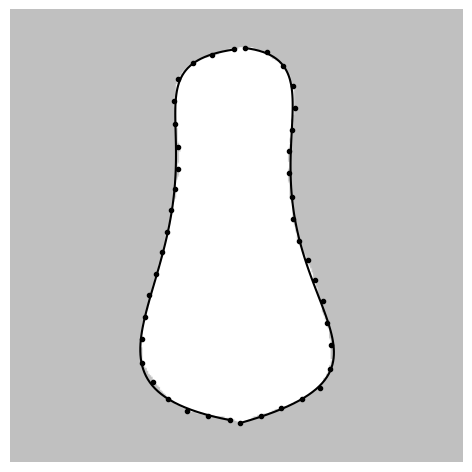

In [37]:
checkToD(0,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.90625 err: 4.5350917021
.....
CP 2.0, steps:5, etime: 1.73438 err: 1.8845946026
......E

Right
....
CP 5.0, steps:3, etime: 1.37500 err: 4.9552775011
...........
CP 2.0, steps:14, etime: 3.21875 err: 1.9506262821
.....................................................................................
....................................................................................................
......................................................E



((0.8960623255312551, 0.9992453486686094),
 45.921875,
 (12, 254),
 ([[148.0, 26.0],
   [81.9361450410076, 19.058435266321762],
   [83.30178109057901, 192.5676183888175],
   [218.9605405371384, -21.97008649964827],
   [-96.61901265216873, 393.7506498895955],
   [175.2932266339454, 183.17034955203113],
   [138.0, 279.0]],
  [[157.0, 26.0],
   [263.7996739426899, 26.386055947606813],
   [122.84612278295941, 230.68461080353893],
   [293.1012936026075, -61.412916796869226],
   [215.40719178746707, 472.1909793723258],
   [222.29030299979541, 147.78452147876217],
   [144.0, 281.0]]))

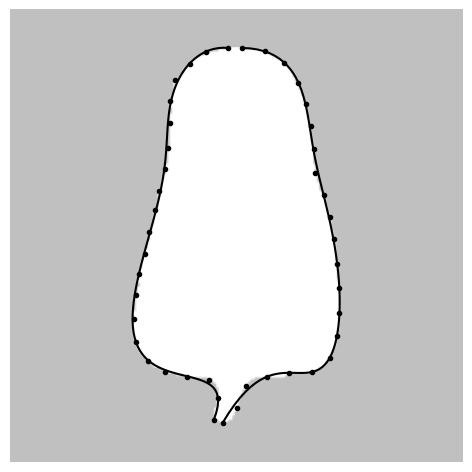

In [50]:
checkToD(6,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
...........
CP 5.0, steps:10, etime: 1.92188 err: 4.8608714896
........
CP 2.0, steps:18, etime: 2.87500 err: 1.9536863743
.................E

Right
..........
CP 5.0, steps:9, etime: 1.79688 err: 4.6798742537
.......................................
CP 2.0, steps:48, etime: 6.67188 err: 1.9950988357
.....................................^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

((0.9980238926121372, 1.8893601998351173),
 137.359375,
 (36, 1087),
 ([[148.0, 26.0],
   [21.14408099628891, 74.0147535813736],
   [277.74050827348475, -16.16844675503334],
   [-115.26387794391293, 387.14347066958135],
   [175.82693077532275, 185.06477311205447],
   [138.0, 279.0]],
  [[157.0, 26.0],
   [221.53498556216408, 31.195784630482187],
   [174.59259326552166, 30.063391164473423],
   [292.5594506047809, 409.59675857815324],
   [200.72672445431692, 166.28516586595865],
   [144.0, 281.0]]))

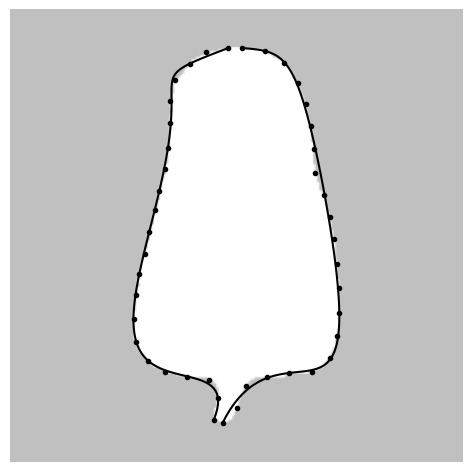

In [39]:
checkToD(6,N=5,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 1.18750 err: 2.0621046952
.
CP 2.0, steps:1, etime: 1.40625 err: 1.6378314491
...E

Right
..
CP 5.0, steps:1, etime: 1.40625 err: 4.6287665517
.......
CP 2.0, steps:8, etime: 2.90625 err: 1.8451293767
............E



((0.889664630118724, 0.9991359391611261),
 7.796875,
 (5, 21),
 ([[148.0, 26.0],
   [97.54138631710575, 31.159747746904348],
   [81.63284371211657, 56.425233317214655],
   [145.63702282696906, 260.65507742126266],
   [106.37101681064995, -32.83193640249175],
   [-33.40441219912931, 421.1412139494678],
   [173.63830296831486, 177.39804957475866],
   [138.0, 279.0]],
  [[157.0, 26.0],
   [224.0958607506983, 13.134912393580713],
   [240.25701146479156, 223.06001403292458],
   [72.50211607900667, -132.10043790907253],
   [409.90350911408103, 391.3601328245474],
   [144.83922183157642, 267.50816828430186],
   [201.37406262212636, 198.87673842687278],
   [144.0, 281.0]]))

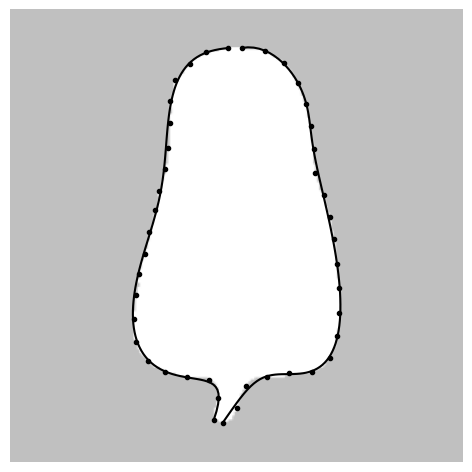

In [69]:
checkToD(6,N=7,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.89062 err: 4.5350917021
.....
CP 2.0, steps:5, etime: 1.75000 err: 1.8845946026
......E

Right
....
CP 5.0, steps:3, etime: 1.37500 err: 4.9552775011
...........
CP 2.0, steps:14, etime: 3.18750 err: 1.9506262821
.....................................................................................
....................................................................................................
......................................................E



((0.8960623255312551, 0.9992453486686094),
 45.921875,
 (12, 254),
 ([[148.0, 26.0],
   [81.9361450410076, 19.058435266321762],
   [83.30178109057901, 192.5676183888175],
   [218.9605405371384, -21.97008649964827],
   [-96.61901265216873, 393.7506498895955],
   [175.2932266339454, 183.17034955203113],
   [138.0, 279.0]],
  [[157.0, 26.0],
   [263.7996739426899, 26.386055947606813],
   [122.84612278295941, 230.68461080353893],
   [293.1012936026075, -61.412916796869226],
   [215.40719178746707, 472.1909793723258],
   [222.29030299979541, 147.78452147876217],
   [144.0, 281.0]]))

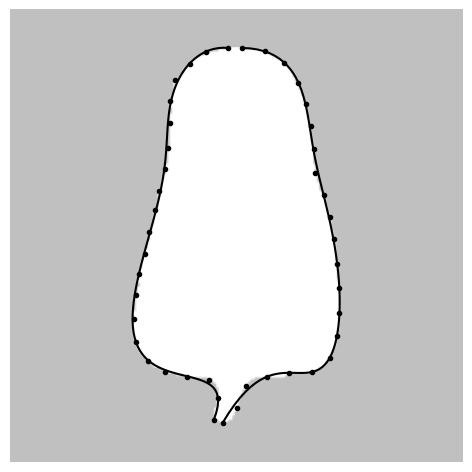

In [38]:
checkToD(6,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

## Nsamples=22, N=6, err_th=1.0

Left
.
CP 5.0, steps:0, etime: 0.85938 err: 2.4724347251
.
CP 2.0, steps:1, etime: 1.01562 err: 1.8604312985
....E

Right
.
CP 5.0, steps:0, etime: 0.87500 err: 2.0593621810
.
CP 2.0, steps:1, etime: 1.03125 err: 1.1536484908
.E



((0.9496184299803144, 0.866043018004294),
 3.0625,
 (6, 3),
 ([[152.0, 27.0],
   [72.72073875124993, 31.544923914918613],
   [110.20993237890673, 126.71950998269415],
   [194.9934134467827, 128.93475457393018],
   [-5.7610910251244425, 217.97578065890818],
   [97.57369914166983, 277.79144248735884],
   [149.0, 279.0]],
  [[159.0, 26.0],
   [224.93577336247407, 19.396975364561087],
   [202.02209962544956, 166.81802805361855],
   [84.11823694307797, 99.59462552822679],
   [338.15907515624076, 252.68494552047005],
   [199.61243990819617, 265.4979395624514],
   [156.0, 281.0]]))

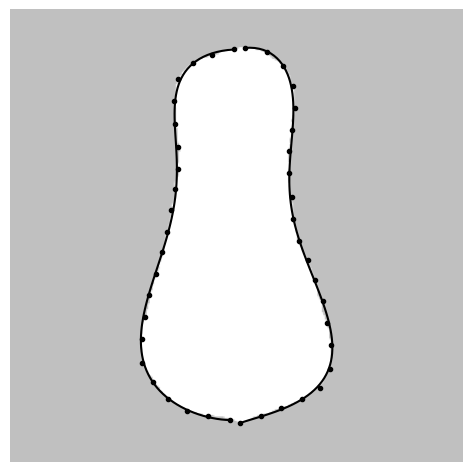

In [71]:
checkToD(0,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.96875 err: 2.7080182071
.
CP 2.0, steps:1, etime: 1.14062 err: 1.8885848831
...E

Right
.
CP 5.0, steps:0, etime: 0.98438 err: 2.2923131636
.
CP 2.0, steps:1, etime: 1.15625 err: 1.6220999180
.....E



((0.9056873925841198, 0.9730540015095259),
 3.90625,
 (5, 7),
 ([[146.0, 27.0],
   [76.42975382086067, 38.5587056526155],
   [60.53087097306783, -53.3885771402862],
   [-56.51182408193289, 394.60165194838964],
   [258.2661129167009, 0.2623590847422304],
   [124.48103683927629, 252.4717186566494],
   [147.0, 280.0]],
  [[153.0, 28.0],
   [212.1913710137604, 32.16747036657638],
   [276.3094214818695, -51.63305555867579],
   [319.4981168899111, 357.7238134605683],
   [92.6258845938959, 26.51569321174803],
   [189.9653343288021, 254.96869256070053],
   [154.0, 280.0]]))

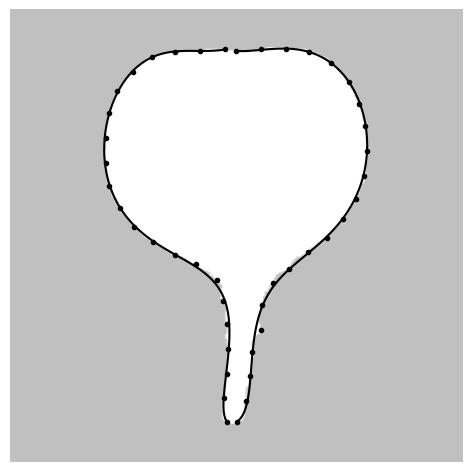

In [72]:
checkToD(1,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.96875 err: 1.1695346607
.E

Right
.
CP 5.0, steps:0, etime: 1.03125 err: 1.1500709399
.E



((0.6888606060791741, 0.8092795317166753),
 2.453125,
 (2, 2),
 ([[165.0, 26.0],
   [117.48731936889698, 34.70198303601417],
   [157.23897086721294, 143.0882747986064],
   [68.65873106051278, 109.30015009123342],
   [132.39097975648778, 225.12548315856293],
   [140.8584162871064, 233.84989694914873],
   [167.0, 281.0]],
  [[172.0, 27.0],
   [222.26866947821284, 47.103224124282235],
   [137.83600555409856, 124.24132838066087],
   [158.1425917598181, 111.44816650959896],
   [135.5028035842722, 215.99470978588846],
   [172.39659711341184, 224.8337654507575],
   [171.0, 277.0]]))

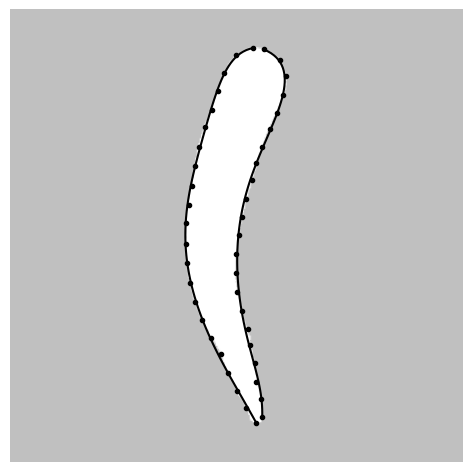

In [73]:
checkToD(2,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.E

Right
.E



((0.5474401978034666, 0.9201470251696463),
 2.078125,
 (1, 1),
 ([[150.0, 26.0],
   [95.30589352631964, 25.887412689643696],
   [151.9567003768096, 127.90425570530395],
   [92.57762307079835, 137.95394640698115],
   [149.28428740889154, 208.13928904704372],
   [132.59978386028376, 231.23540755145842],
   [154.0, 280.0]],
  [[158.0, 26.0],
   [204.99840107869122, 23.32178712192093],
   [183.90708860613776, 134.83008021570828],
   [150.69921376891133, 115.22440567933377],
   [174.3773828936572, 189.49125568464893],
   [164.43489821026907, 228.69759289982858],
   [161.0, 279.0]]))

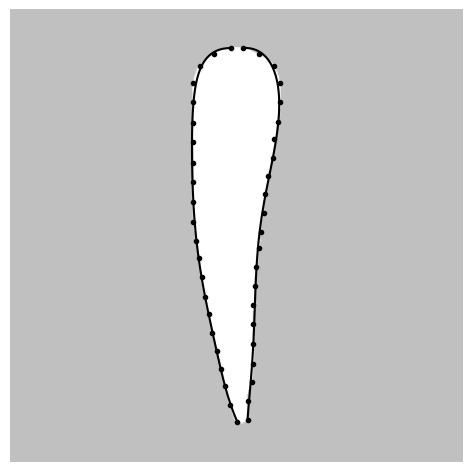

In [74]:
checkToD(3,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.96875 err: 4.7146881454
.......
CP 2.0, steps:7, etime: 2.14062 err: 1.8326593666
......E

Right
...........
CP 5.0, steps:10, etime: 2.65625 err: 4.7457852277
...........
CP 2.0, steps:21, etime: 4.71875 err: 1.9913391941
..............E



((0.9934081575284712, 0.9751928633872533),
 10.421875,
 (14, 36),
 ([[151.0, 27.0],
   [105.9686678426819, 21.96714863926577],
   [19.095123428280655, -1.647167494272329],
   [68.54567620932804, 396.64036165642847],
   [193.38636029595506, -36.0548859415794],
   [142.56502006717037, 274.5734848588723],
   [148.0, 279.0]],
  [[159.0, 27.0],
   [203.35808167500903, 12.087034953434094],
   [312.04769717457174, 46.298280418470185],
   [191.37257603218936, 416.2353586032419],
   [131.6063650319807, -63.8686772868179],
   [176.90188048121223, 266.15785432922456],
   [154.0, 280.0]]))

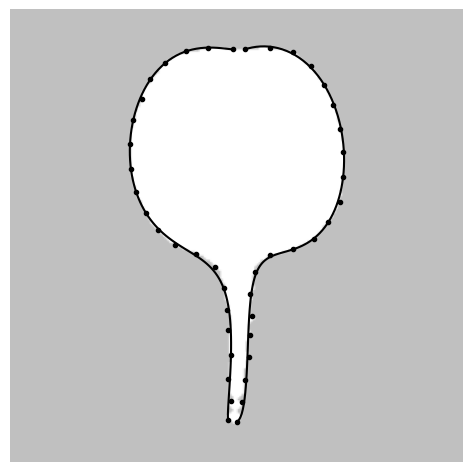

In [75]:
checkToD(4,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.98438 err: 1.4382790116
.
CP 2.0, steps:1, etime: 1.14062 err: 1.1549897424
...E

Right
.
CP 5.0, steps:0, etime: 0.96875 err: 1.3304228783
.
CP 2.0, steps:1, etime: 1.12500 err: 1.0848417268
...E



((0.9234685524976748, 0.9877697542452382),
 3.453125,
 (5, 5),
 ([[150.0, 27.0],
   [88.68939776134376, 20.801960763075915],
   [77.36326936188969, 102.74534792817221],
   [156.61868004430292, 121.32482389002904],
   [25.869812939897756, 247.49465166589198],
   [147.93786196544744, 217.2270311580222],
   [150.0, 279.0]],
  [[158.0, 27.0],
   [206.048889678178, 9.294839705280879],
   [262.03017196160965, 144.42919379612545],
   [107.53116017620363, 72.75302071443672],
   [299.2120852195113, 267.85417508901537],
   [156.93113358931635, 221.5627025052547],
   [156.0, 279.0]]))

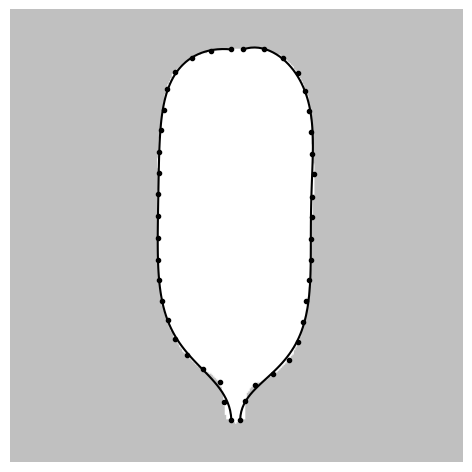

In [76]:
checkToD(5,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.87500 err: 4.5350917021
.....
CP 2.0, steps:5, etime: 1.70312 err: 1.8845946026
......E

Right
....
CP 5.0, steps:3, etime: 1.39062 err: 4.9552775011
...........
CP 2.0, steps:14, etime: 3.20312 err: 1.9506262821
.....................................................................................
....................................................................................................
......................................................E



((0.8960623255312551, 0.9992453486686094),
 46.125,
 (12, 254),
 ([[148.0, 26.0],
   [81.9361450410076, 19.058435266321762],
   [83.30178109057901, 192.5676183888175],
   [218.9605405371384, -21.97008649964827],
   [-96.61901265216873, 393.7506498895955],
   [175.2932266339454, 183.17034955203113],
   [138.0, 279.0]],
  [[157.0, 26.0],
   [263.7996739426899, 26.386055947606813],
   [122.84612278295941, 230.68461080353893],
   [293.1012936026075, -61.412916796869226],
   [215.40719178746707, 472.1909793723258],
   [222.29030299979541, 147.78452147876217],
   [144.0, 281.0]]))

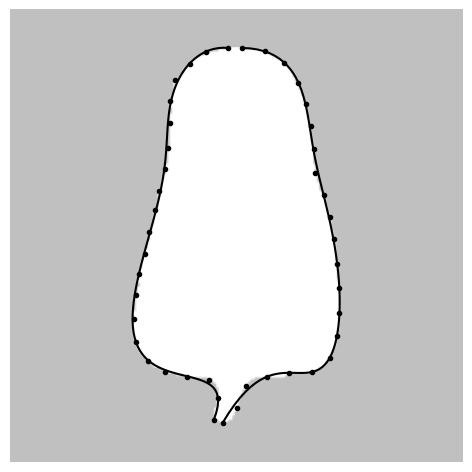

In [77]:
checkToD(6,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.98438 err: 1.1176468356
.E

Right
.E



((0.756754379375018, 0.6480497810565599),
 2.296875,
 (2, 1),
 ([[154.0, 26.0],
   [117.47997472253833, 36.97235305219308],
   [122.8625400820268, 140.85948207578465],
   [111.95226081866731, 92.20253752953886],
   [96.43771581976121, 252.06001198985888],
   [138.9716397608764, 227.6185981570688],
   [161.0, 281.0]],
  [[162.0, 26.0],
   [184.37790652006228, 40.627447389904894],
   [214.3910387263833, 119.17121091406604],
   [148.93823394558126, 113.15806384245451],
   [242.01380230274154, 236.90628416240313],
   [162.47095809202193, 219.1984645119365],
   [168.0, 279.0]]))

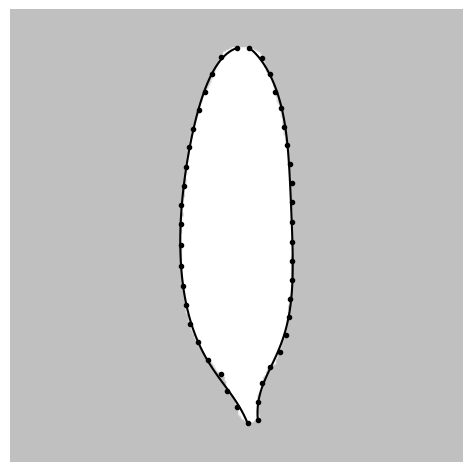

In [78]:
checkToD(7,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.E

Right
.
CP 5.0, steps:0, etime: 0.96875 err: 1.2930223934
.E



((0.3665077896037683, 0.7903853594276942),
 2.234375,
 (1, 2),
 ([[157.0, 26.0],
   [107.31684009441541, 24.737496500709824],
   [136.6634785505386, 145.41377541047217],
   [123.51798088666834, 101.61974657364165],
   [117.05974116258552, 231.68734074205628],
   [150.77577269850954, 224.64420672350573],
   [159.0, 280.0]],
  [[163.0, 28.0],
   [220.65557430792805, 31.135214212842154],
   [117.27484293945325, 134.22102104505524],
   [230.5559097621948, 128.3378269787332],
   [161.2587925350336, 208.10203277637189],
   [155.15463287303982, 228.41422870581306],
   [166.0, 279.0]]))

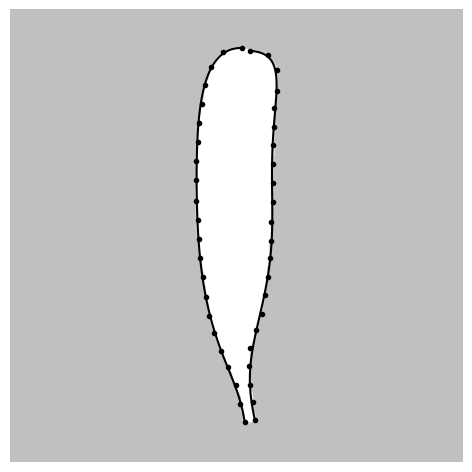

In [79]:
checkToD(8,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
....................................................................................................
....................................................................................................
....................................C

Right
....................................................................................................
....................................................................................................
.......C



((33.73051590634151, 49.85019023946441),
 23.6875,
 (236, 207),
 ([[152.0, 27.0],
   [123.11305636686097, -19.37440980337027],
   [41.2540823860698, 315.98570451793785],
   [149.0, 279.0]],
  [[159.0, 26.0],
   [173.62025401887038, -17.03048328301772],
   [267.11997785830977, 315.013396427661],
   [156.0, 281.0]]))

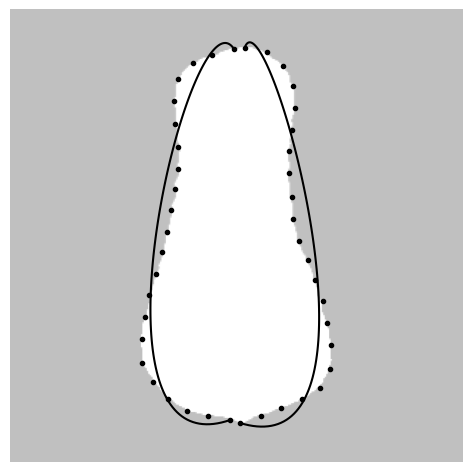

In [52]:
checkToD(0,N=3,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
..........
CP 5.0, steps:9, etime: 1.15625 err: 4.5561389271
...........................
CP 2.0, steps:36, etime: 3.37500 err: 1.9904310931
..........................................E

Right
............
CP 5.0, steps:11, etime: 1.32812 err: 4.8628629702
.................
CP 2.0, steps:28, etime: 2.71875 err: 1.9835394218
...................................E



((0.9938952360417692, 0.9987047694792239),
 12.5625,
 (79, 64),
 ([[152.0, 27.0],
   [38.75543252982888, 43.59885292623391],
   [226.78865283251397, 139.37982898404633],
   [-21.004418994483036, 246.0093994820153],
   [149.0, 279.0]],
  [[159.0, 26.0],
   [260.8977607073386, 38.46667552049351],
   [69.86202359494186, 176.25143023648278],
   [336.6917481216665, 229.9097007995843],
   [156.0, 281.0]]))

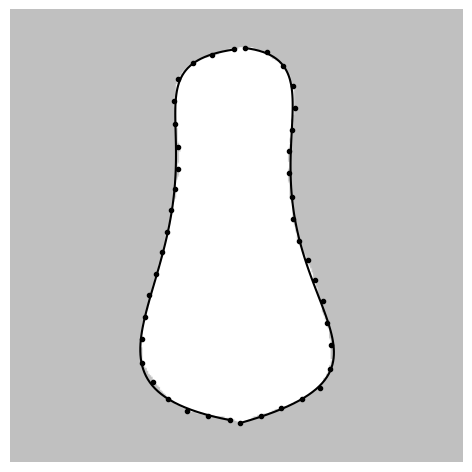

In [53]:
checkToD(0,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
........................
CP 5.0, steps:23, etime: 2.35938 err: 4.7012194193
...............
CP 2.0, steps:38, etime: 3.79688 err: 1.9583096226
.....................................................E

Right
...............................
CP 5.0, steps:30, etime: 3.00000 err: 4.9232348256
.........................................
CP 2.0, steps:71, etime: 6.40625 err: 1.9938196472
............................
....................................................................................................
....................................................................................................
........................C



((0.9988498069639169, 1.5917201858550125),
 35.671875,
 (92, 324),
 ([[146.0, 27.0],
   [-22.803616564588207, 3.3496580772736007],
   [94.47259907406374, 316.91235596777153],
   [156.10515815402482, 48.316716805002656],
   [147.0, 280.0]],
  [[153.0, 28.0],
   [346.2012591795877, -3.6647046709880096],
   [174.52802625948073, 317.08543237082165],
   [202.5592526435036, 45.98573548615718],
   [154.0, 280.0]]))

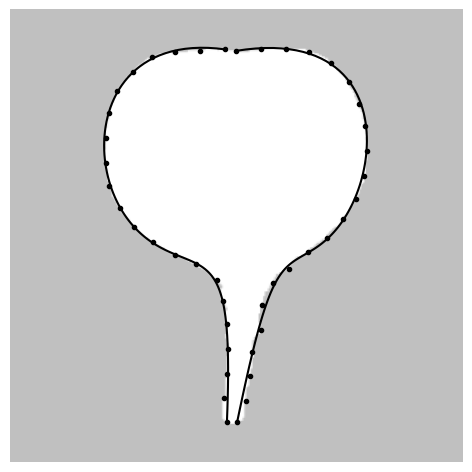

In [54]:
checkToD(1,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Right
.............
CP 5.0, steps:12, etime: 2.15625 err: 4.9031972283
....................................
CP 2.0, steps:48, etime: 6.48438 err: 1.9898413970
...................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................E



((0, 0.9996156394800036),
 56.546875,
 (1, 460),
 ([],
  [[153.0, 28.0],
   [291.7240744123256, -4.361834089969347],
   [290.13514352169864, 209.3662130981941],
   [121.91196094768902, 193.31952090115774],
   [199.33112232980724, 128.50137006258436],
   [154.0, 280.0]]))

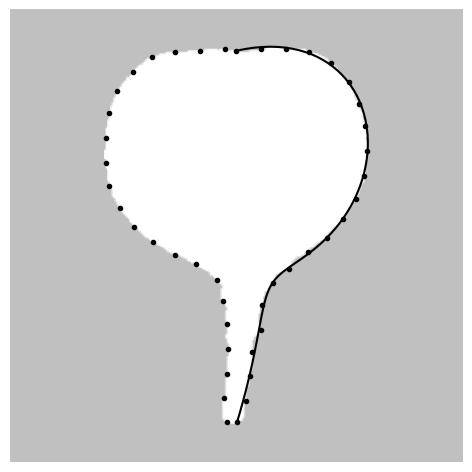

In [55]:
checkToD(1,N=5,Nsamples=22,LR=2,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.48438 err: 3.3494505774
.....
CP 2.0, steps:5, etime: 0.89062 err: 1.7696883023
.......E

Right
.
CP 5.0, steps:0, etime: 0.46875 err: 2.2624308391
.
CP 2.0, steps:1, etime: 0.54688 err: 1.8235643731
.........E



((0.960619763595876, 0.9900553764441963),
 2.84375,
 (13, 11),
 ([[165.0, 26.0],
   [124.8541214705824, 34.59767774135544],
   [97.72456843693709, 211.92726417279187],
   [124.33245768748537, 194.57857462444358],
   [167.0, 281.0]],
  [[172.0, 27.0],
   [230.04196348523263, 56.31874224349169],
   [86.37775170375207, 161.62190526118977],
   [176.6784480621008, 208.02461102875034],
   [171.0, 277.0]]))

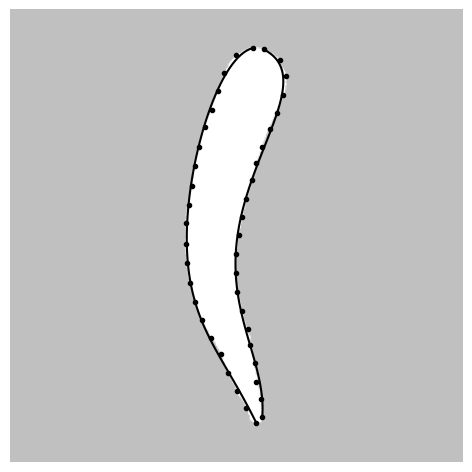

In [56]:
checkToD(2,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.45312 err: 2.5305430921
..
CP 2.0, steps:2, etime: 0.60938 err: 1.9198541974
.........E

Right
.
CP 5.0, steps:0, etime: 0.46875 err: 2.8164591603
.
CP 2.0, steps:1, etime: 0.54688 err: 1.8487556065
.....E



((0.9676825841621963, 0.9528830486149125),
 2.4375,
 (12, 7),
 ([[150.0, 26.0],
   [92.097746840004, 23.243772756797778],
   [142.9130778281347, 214.56518409683227],
   [124.00815363289436, 193.68528578979507],
   [154.0, 280.0]],
  [[158.0, 26.0],
   [227.50036739024566, 41.28873205847765],
   [131.8376508198581, 171.6786292726257],
   [177.9886440194654, 191.3797026297943],
   [161.0, 279.0]]))

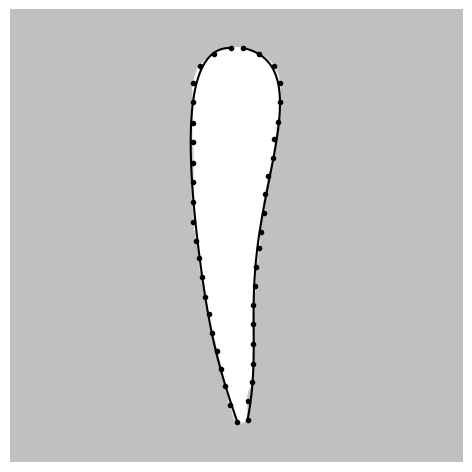

In [57]:
checkToD(3,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.................................
CP 5.0, steps:32, etime: 3.07812 err: 4.7462372758
.........
CP 2.0, steps:41, etime: 3.81250 err: 1.9456152098
......E

Right
................................................
CP 5.0, steps:47, etime: 4.34375 err: 4.7666950661
....................................................
............................................C



((0.9945359467853907, 2.4948090718556295),
 16.84375,
 (48, 144),
 ([[151.0, 27.0],
   [18.832046739126024, 3.7170464151005356],
   [88.52834957102787, 297.589142930737],
   [164.11371178614306, 56.85809448635971],
   [148.0, 279.0]],
  [[159.0, 27.0],
   [304.3870047398403, 5.32685939356761],
   [177.66353258262637, 365.98460471510936],
   [183.15918988098198, -6.103762234351601],
   [154.0, 280.0]]))

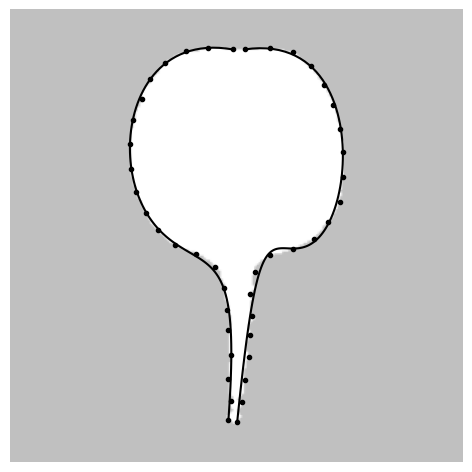

In [58]:
checkToD(4,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Right
.....................
CP 5.0, steps:20, etime: 3.12500 err: 4.9227859231
..................
CP 2.0, steps:38, etime: 5.28125 err: 1.9361567512
..............E



((0, 0.9912690979477722),
 7.4375,
 (1, 53),
 ([],
  [[159.0, 27.0],
   [240.36011484761465, -15.573736399101165],
   [315.5084103268129, 288.2615133024148],
   [82.19784863916377, 119.26334600469336],
   [191.70836799223943, 145.40333997719878],
   [154.0, 280.0]]))

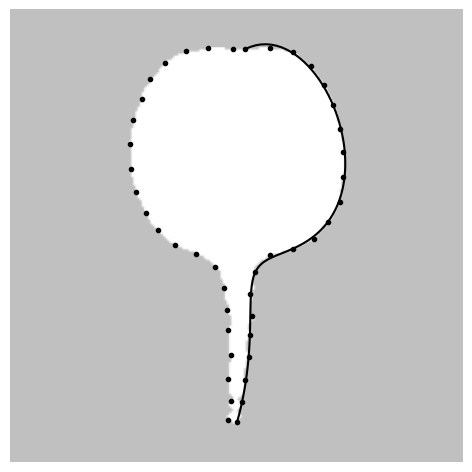

In [59]:
checkToD(4,N=5,Nsamples=22,LR=2,mode=1,err_th=1.0)

Left
..................................
CP 5.0, steps:33, etime: 3.21875 err: 4.9650428807
..................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................
CP 2.0, steps:415, etime: 34.43750 err: 1.9983543253
....................................................................................
....................................................................................................
................................C

Right
.....................
CP 5.0, steps:20, etime: 2.12500 err: 4.9788469174
...............................................................................
.........................................................................................

((1.8669978015884183, 0.9997289971325545),
 110.53125,
 (632, 700),
 ([[150.0, 27.0],
   [48.54951460531184, -3.395933840333969],
   [124.39175413153905, 381.5951516920196],
   [112.04868478887154, 165.13599132645933],
   [150.0, 279.0]],
  [[158.0, 27.0],
   [260.9542100985583, -7.919580162255457],
   [172.135676353418, 413.62146838700147],
   [189.94894932167082, 172.3366794449059],
   [156.0, 279.0]]))

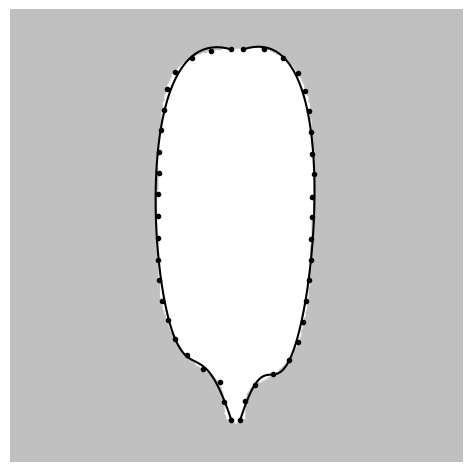

In [60]:
checkToD(5,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.70312 err: 4.3445420436
....
CP 2.0, steps:4, etime: 1.18750 err: 1.9828587743
.....E

Right
..
CP 5.0, steps:1, etime: 0.81250 err: 4.6889826952
...............
CP 2.0, steps:16, etime: 2.59375 err: 1.9645114074
.........................E



((0.9782178147296161, 0.9889315381124175),
 7.546875,
 (10, 42),
 ([[150.0, 27.0],
   [53.3744096128227, 37.26234837437323],
   [161.427972533243, 66.30526838689443],
   [33.67232763783648, 262.6575199626952],
   [132.48949894311764, 200.67930481780402],
   [150.0, 279.0]],
  [[158.0, 27.0],
   [239.81312321114424, 36.81181064836121],
   [168.3113999254347, 32.21150417167446],
   [247.94557096610296, 315.84027040681354],
   [176.8975165507622, 200.91888420492134],
   [156.0, 279.0]]))

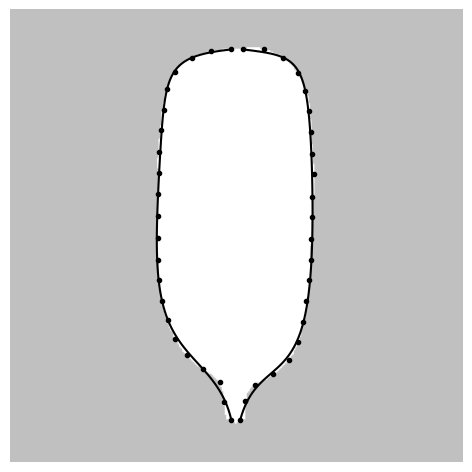

In [61]:
checkToD(5,N=5,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
...........
CP 5.0, steps:10, etime: 1.82812 err: 4.8608714896
........
CP 2.0, steps:18, etime: 2.78125 err: 1.9536863743
.................E

Right
..........
CP 5.0, steps:9, etime: 1.68750 err: 4.6798742537
.......................................
CP 2.0, steps:48, etime: 6.35938 err: 1.9950988357
.....................................^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

((0.9980238926121372, 1.8893601998351173),
 136.734375,
 (36, 1087),
 ([[148.0, 26.0],
   [21.14408099628891, 74.0147535813736],
   [277.74050827348475, -16.16844675503334],
   [-115.26387794391293, 387.14347066958135],
   [175.82693077532275, 185.06477311205447],
   [138.0, 279.0]],
  [[157.0, 26.0],
   [221.53498556216408, 31.195784630482187],
   [174.59259326552166, 30.063391164473423],
   [292.5594506047809, 409.59675857815324],
   [200.72672445431692, 166.28516586595865],
   [144.0, 281.0]]))

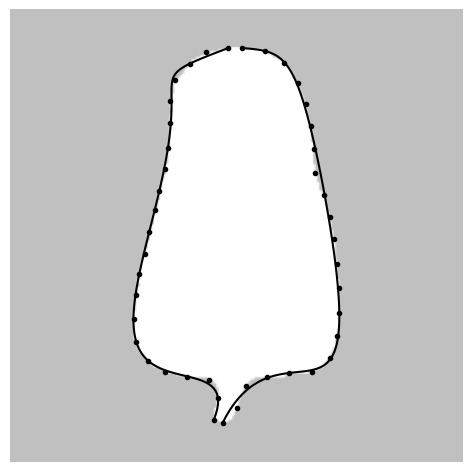

In [63]:
checkToD(6,N=5,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.87500 err: 4.5350917021
.....
CP 2.0, steps:5, etime: 1.70312 err: 1.8845946026
......E

Right
....
CP 5.0, steps:3, etime: 1.37500 err: 4.9552775011
...........
CP 2.0, steps:14, etime: 3.18750 err: 1.9506262821
.....................................................................................
....................................................................................................
......................................................E



((0.8960623255312551, 0.9992453486686094),
 45.8125,
 (12, 254),
 ([[148.0, 26.0],
   [81.9361450410076, 19.058435266321762],
   [83.30178109057901, 192.5676183888175],
   [218.9605405371384, -21.97008649964827],
   [-96.61901265216873, 393.7506498895955],
   [175.2932266339454, 183.17034955203113],
   [138.0, 279.0]],
  [[157.0, 26.0],
   [263.7996739426899, 26.386055947606813],
   [122.84612278295941, 230.68461080353893],
   [293.1012936026075, -61.412916796869226],
   [215.40719178746707, 472.1909793723258],
   [222.29030299979541, 147.78452147876217],
   [144.0, 281.0]]))

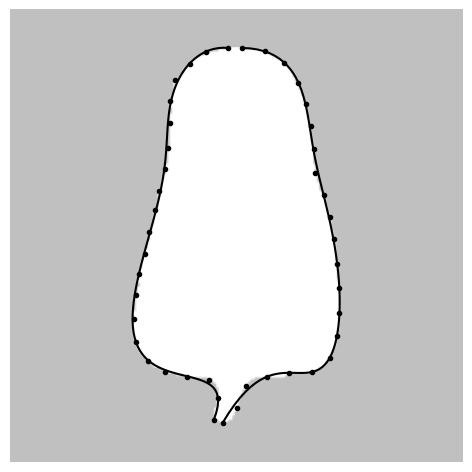

In [64]:
checkToD(6,N=6,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.46875 err: 2.8853817789
...
CP 2.0, steps:3, etime: 0.73438 err: 1.8230007833
.....E

Right
.
CP 5.0, steps:0, etime: 0.39062 err: 3.7102238948
..........................................................
CP 2.0, steps:58, etime: 5.14062 err: 1.9981217364
.........................................
....................................................................................................
...........................................E



((0.9431809600705964, 0.9994833869620593),
 21.4375,
 (9, 243),
 ([[154.0, 26.0],
   [113.69537802787342, 42.047295360809194],
   [104.08791172459517, 199.09687768373666],
   [112.1524186605521, 208.2286219388262],
   [161.0, 281.0]],
  [[162.0, 26.0],
   [193.5124756078682, 25.926140095335917],
   [212.51227117265103, 259.5875666142032],
   [172.69707002529188, 213.0788457359878],
   [168.0, 279.0]]))

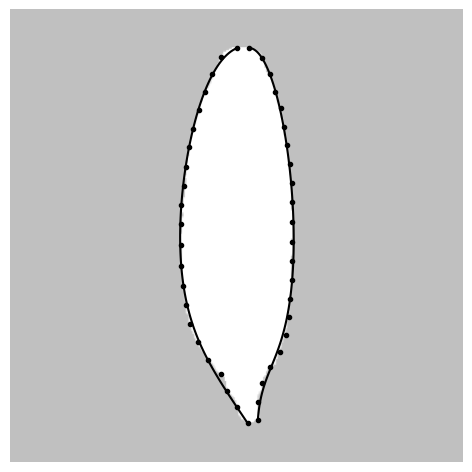

In [66]:
checkToD(7,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Right
....
CP 5.0, steps:3, etime: 1.98438 err: 4.3649832839
.......
CP 2.0, steps:10, etime: 3.50000 err: 1.9287956829
........................................E



((0, 0.9985005340465017),
 12.546875,
 (1, 51),
 ([],
  [[155.0, 26.0],
   [228.71391720765877, 2.3613780617621116],
   [247.97177356767867, 302.91786124232925],
   [32.24376345268992, -320.313390438728],
   [475.3992361645742, 610.0900047201051],
   [98.12412014727751, 147.86445929882018],
   [198.37303639439602, 236.2996377799506],
   [143.0, 280.0]]))

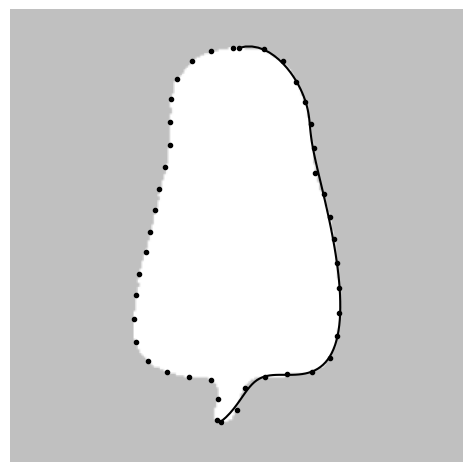

In [14]:
checkToD(6,N=7,Nsamples=22,LR=2,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.46875 err: 3.8606610167
.....
CP 2.0, steps:5, etime: 0.89062 err: 1.9691436026
........E

Right
.
CP 5.0, steps:0, etime: 0.45312 err: 3.1990791854
.......
CP 2.0, steps:7, etime: 1.03125 err: 1.9359698602
............................................................................................
.........................................................................................E



((0.9964193497334717, 0.9992407044060491),
 17.53125,
 (14, 189),
 ([[156.0, 26.0],
   [114.74460872724792, 29.51067441674272],
   [104.95760886227515, 212.70407450095593],
   [108.81111266841319, 203.52642059204004],
   [163.0, 281.0]],
  [[160.0, 26.0],
   [197.76089137589196, 22.493307701573425],
   [200.3794729588772, 253.1855251164144],
   [188.53722535963368, 190.9522056598776],
   [166.0, 280.0]]))

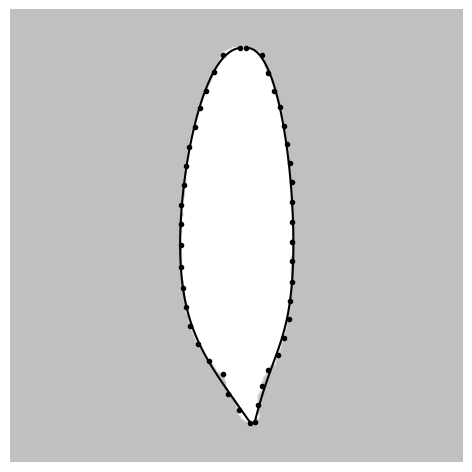

In [15]:
checkToD(7,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.48438 err: 2.9163078228
...
CP 2.0, steps:3, etime: 0.71875 err: 1.8207214741
....E

Right
.............
CP 5.0, steps:12, etime: 1.45312 err: 4.7949340755
.......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................

((0.9348916419930349, 2.128435069079871),
 95.171875,
 (8, 1128),
 ([[157.0, 26.0],
   [102.57666701895803, 25.87292755263466],
   [133.25421306246884, 214.16073122963363],
   [128.52132506134345, 188.67619055329783],
   [159.0, 280.0]],
  [[163.0, 28.0],
   [204.78411704308704, -3.4145516914033363],
   [163.15129929645275, 340.02550207426765],
   [155.7301598668697, 186.03557068843722],
   [166.0, 279.0]]))

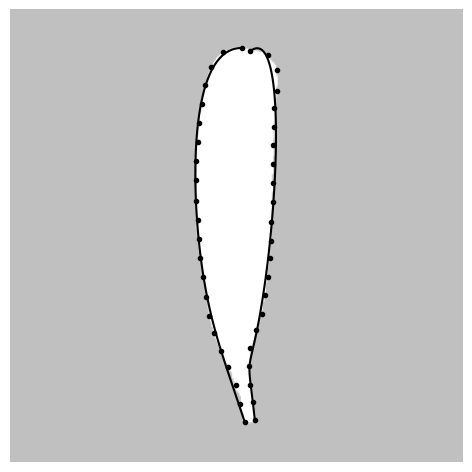

In [67]:
checkToD(8,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Right
.
CP 5.0, steps:0, etime: 0.68750 err: 2.0912187843
.
CP 2.0, steps:1, etime: 0.82812 err: 1.7064281490
.........E



((0, 0.9801321140087271),
 2.25,
 (1, 11),
 ([],
  [[163.0, 28.0],
   [215.91288810844594, 24.073955512904668],
   [127.22995481777063, 167.9579537641426],
   [226.82675322336232, 166.35654760964593],
   [140.87442157631781, 217.10375901997816],
   [166.0, 279.0]]))

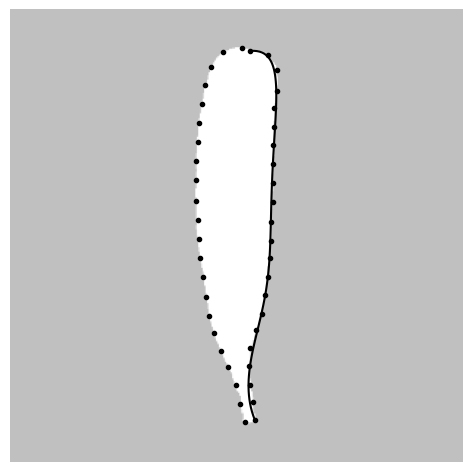

In [68]:
checkToD(8,N=5,Nsamples=22,LR=2,mode=1,err_th=1.0)

Left
.
CP 5.0, steps:0, etime: 0.46875 err: 3.6919779190
.......
CP 2.0, steps:7, etime: 1.03125 err: 1.8623938339
............................................................................................
....................................................................................................
..............E

Right
.
CP 5.0, steps:0, etime: 0.46875 err: 2.1750624432
.
CP 2.0, steps:1, etime: 0.56250 err: 1.7225236184
.........E



((0.9991106440179698, 0.9419729114032676),
 19.5625,
 (214, 11),
 ([[167.0, 26.0],
   [126.10272093033622, 25.6989177587903],
   [106.77098324212918, 202.1228262884063],
   [108.26916508453255, 176.42239731130564],
   [169.0, 281.0]],
  [[171.0, 27.0],
   [232.36702663103648, 50.63056937646009],
   [85.54895539854921, 167.7813686663827],
   [176.52712948314223, 205.35702876123818],
   [171.0, 278.0]]))

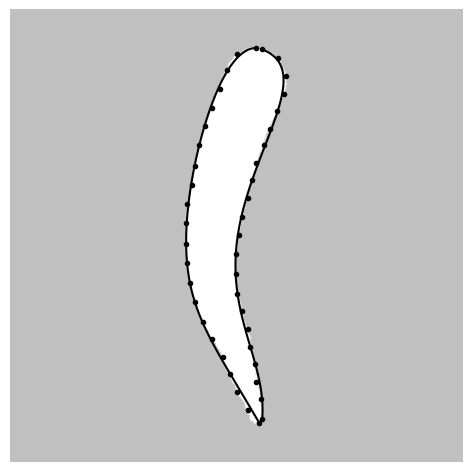

In [30]:
checkToD(2,N=4,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
............................
CP 5.0, steps:27, etime: 3.98438 err: 4.9019016869
........................................................................
CP 2.0, steps:99, etime: 12.65625 err: 1.9958883750

....................................................................................................
.......................................^^^..^.^.^.....................................^^^^.^.^......
...............................................^^....^...........................................^^^
.^^...........................................^^....^...............................................
..^^^.^..........................................^^^..^.............................................
..^^.......................................................^^..^....................................
.......................^............................................................................
.................................^................................................

((1.0919394717274367, 1.0730821192915072),
 671.453125,
 (3001, 2579),
 ([[148.0, 27.0],
   [-33.56131861505458, 0.3576259454413739],
   [87.88008960418968, 349.35093831103114],
   [195.17968173399814, 39.74765504744906],
   [130.71535921748185, 233.63439090030644],
   [149.0, 281.0]],
  [[151.0, 28.0],
   [334.7315433988178, -12.428463227624471],
   [224.01172448258728, 320.62729655530813],
   [139.31553510425294, 64.01969725463955],
   [186.07336296273277, 229.17835394845076],
   [153.0, 280.0]]))

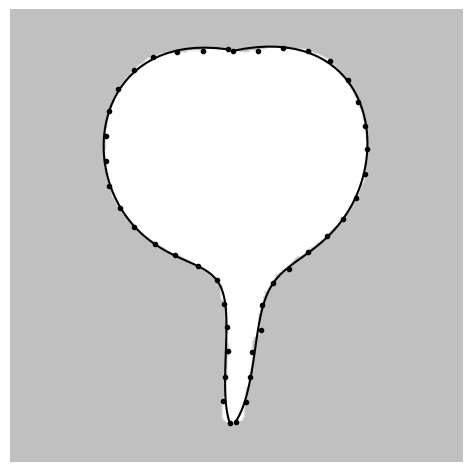

In [28]:
checkToD(1,N=5,Nsamples=22,LR=0,mode=1,err_th=1.0)

Left
...................
CP 5.0, steps:18, etime: 2.37500 err: 4.9834359588
............................
CP 2.0, steps:46, etime: 5.18750 err: 1.9376614511
.................E

Right
......................
CP 5.0, steps:21, etime: 2.71875 err: 4.9611778708
...................
CP 2.0, steps:40, etime: 4.60938 err: 1.9327659541
..............E



((0.982200310189875, 0.9650463355291242),
 13.34375,
 (64, 55),
 ([[153.0, 27.0],
   [62.30074394372684, -1.4948778144244477],
   [13.574343886885213, 209.07001797717777],
   [177.2443191321891, 178.3244467048957],
   [142.34410560678276, 122.47092586264668],
   [150.0, 280.0]],
  [[157.0, 27.0],
   [247.18540303334012, -8.388214983552446],
   [304.5997548652532, 275.03235670824364],
   [91.4677679565317, 127.16153489898167],
   [189.4047463336285, 145.5496622762515],
   [153.0, 281.0]]))

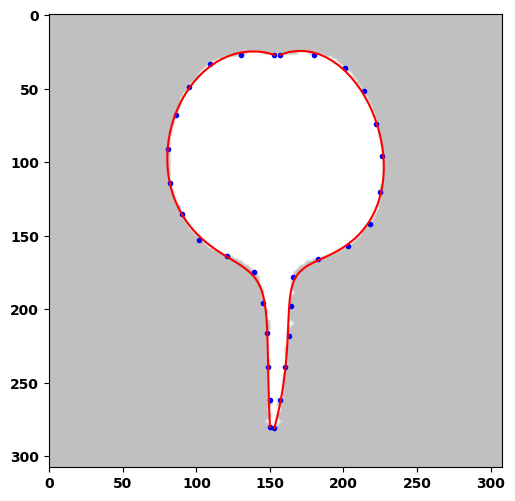

In [11]:
checkToD(4,N=5,Nsamples=16,LR=0,mode=1,err_th=1.0)

Right
....
CP 5.0, steps:3, etime: 1.82812 err: 4.3649832839
.......
CP 2.0, steps:10, etime: 3.51562 err: 1.9287956829
........................................E



((0, 0.9985005340465017),
 12.4375,
 (1, 51),
 ([],
  [[155.0, 26.0],
   [228.71391720765877, 2.3613780617621116],
   [247.97177356767867, 302.91786124232925],
   [32.24376345268992, -320.313390438728],
   [475.3992361645742, 610.0900047201051],
   [98.12412014727751, 147.86445929882018],
   [198.37303639439602, 236.2996377799506],
   [143.0, 280.0]]))

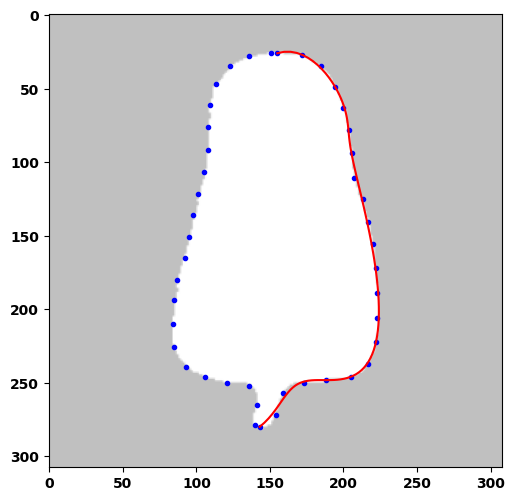

In [23]:
checkToD(6,N=7,Nsamples=22,LR=2,mode=1,err_th=1.0)

Right
....
CP 5.0, steps:3, etime: 1.85938 err: 4.3649832839
.......
CP 2.0, steps:10, etime: 3.37500 err: 1.9287956829
........................................E



((0, 0.9985005340465017),
 12.3125,
 (1, 51),
 ([],
  [[155.0, 26.0],
   [228.71391720765877, 2.3613780617621116],
   [247.97177356767867, 302.91786124232925],
   [32.24376345268992, -320.313390438728],
   [475.3992361645742, 610.0900047201051],
   [98.12412014727751, 147.86445929882018],
   [198.37303639439602, 236.2996377799506],
   [143.0, 280.0]]))

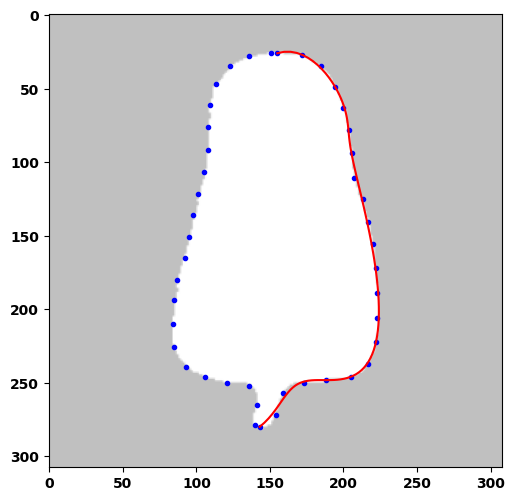

In [18]:
checkToD(6,N=7,Nsamples=22,LR=2,mode=1,err_th=1.0)

Right
....
CP 5.0, steps:3, etime: 1.96875 err: 4.3649832839
.......
CP 2.0, steps:10, etime: 3.51562 err: 1.9287956829
........................................
CP 1.0, steps:50, etime: 12.26562 err: 0.9985005340
.................................................
....................................................
CP 0.65, steps:151, etime: 34.37500 err: 0.6499440134
................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................................^^...
..^^^....^^^^...^^^...^^^^^...^^^^^....^^^^^^^^^.....................^^^^^^^

((0, 0.5426363349728683),
 655.625,
 (1, 3001),
 ([],
  [[155.0, 26.0],
   [252.1948299386031, 2.183943591947349],
   [208.37255272577272, 395.13798147714033],
   [76.24108362871971, -443.24419181548996],
   [468.4076570728789, 765.2517549918845],
   [80.8507439695756, 51.93522112928383],
   [190.16194616752634, 269.4784980933865],
   [143.0, 280.0]]))

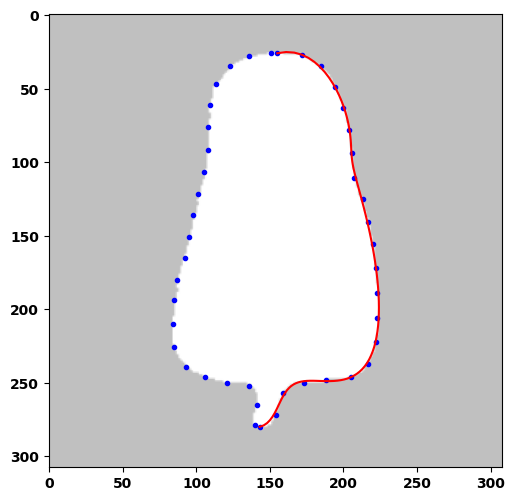

In [17]:
checkToD(6,N=7,Nsamples=22,LR=2,mode=1,err_th=0.5)

Right
...
CP 5.0, steps:2, etime: 2.15625 err: 4.8466135863
..........
CP 2.0, steps:12, etime: 4.98438 err: 1.8546483752
...............................................................
CP 1.0, steps:75, etime: 22.75000 err: 0.9982758631
........................
......
CP 0.65, steps:105, etime: 31.35938 err: 0.6426591706
..............................................................................................
.........................................................................................E



((0, 0.4998775491875501),
 83.5625,
 (1, 289),
 ([],
  [[155.0, 26.0],
   [245.14170095397046, 10.293984047613447],
   [222.0519871162448, 327.7164901116128],
   [36.573771889516, -437.6645297425134],
   [508.65974900253957, 796.1788436285198],
   [63.305502204083545, 23.02253056413469],
   [189.35466651847622, 281.59049534781764],
   [143.0, 280.0]]))

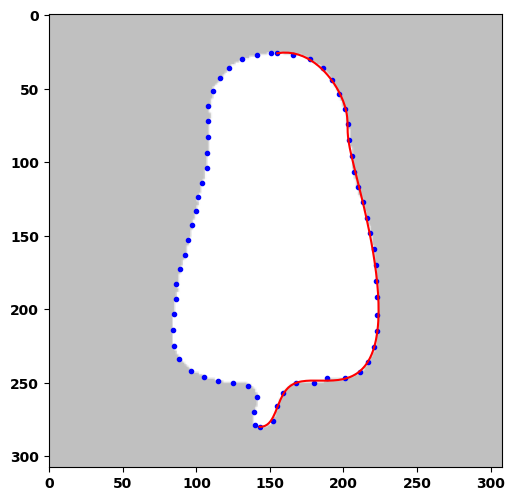

In [16]:
checkToD(6,N=7,Nsamples=32,LR=2,mode=1,err_th=0.5)

Right
....
CP 5.0, steps:3, etime: 1.60938 err: 4.8639438899
........
CP 2.0, steps:11, etime: 3.04688 err: 1.8422934648
........E



((0, 0.9621842453885474),
 4.71875,
 (1, 20),
 ([],
  [[155.0, 26.0],
   [229.83290274954956, 16.770363229189424],
   [227.46859152992596, 216.4930361828442],
   [88.131722508008, -159.49474317888442],
   [393.91108681120187, 462.53946543153353],
   [158.90028087548004, 216.1180922924599],
   [194.54495442345785, 215.97670575716862],
   [143.0, 280.0]]))

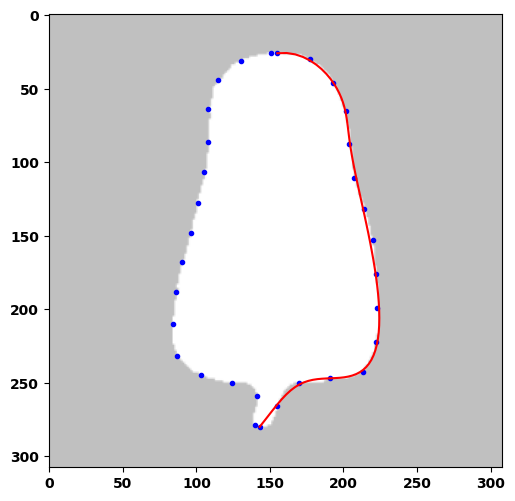

In [13]:
checkToD(6,N=7,Nsamples=16,LR=2,mode=1,err_th=1.0)

# 全周近似結果まとめ
N=11, err_th=1.0, Samples=65

..
CP 5.0, steps:1, etime: 7.04688 err: 4.2299106820
..........
CP 2.0, steps:11, etime: 19.31250 err: 1.9915668942
...........E

TEST ./pics\Beztest.png


((0.9735283461294737, 0.9735283461294737),
 33.234375,
 23,
 [[149.0, 279.0],
  [1.419439660032817, 246.97653970864664],
  [615.158803107409, 412.5430988878856],
  [-2109.4618878374536, -374.94649018237675],
  [5612.762090610104, 833.5741609939109],
  [-8580.153291588607, -662.798449462791],
  [9085.752901926753, -32.29641610010244],
  [-5662.171350254282, 466.21477410330203],
  [2621.099200431025, -286.7874475997943],
  [-370.3465773116366, 455.0943142522888],
  [315.5256414386579, 224.45886282918497],
  [156.0, 281.0]])

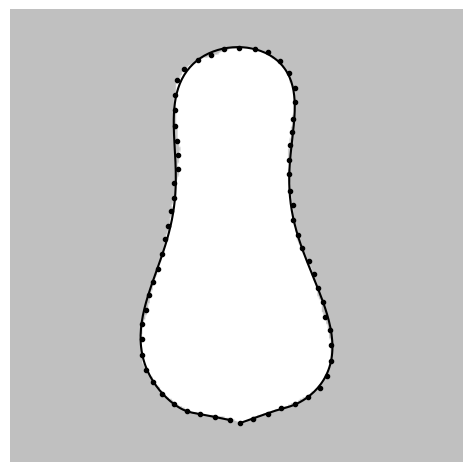

In [18]:
checkTo11(0,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

....
CP 5.0, steps:3, etime: 9.51562 err: 4.9893636792
.................................................................
CP 2.0, steps:68, etime: 89.75000 err: 1.9872527632
...............................
.................................................................E

TEST ./pics\Beztest.png


((0.9969491536642733, 0.9969491536642733),
 208.3125,
 165,
 [[147.0, 280.0],
  [116.64264062222142, 244.49314280068148],
  [406.03429115411984, -460.437676178415],
  [-836.9871172638756, 1864.434963340177],
  [1341.6121480589763, -2545.3461126934753],
  [-1376.2323543239079, 1890.8220246954922],
  [1324.5373209722645, -131.5048046840036],
  [-353.78115514813305, -1243.0154991528584],
  [658.7910976080609, 1348.9691002033444],
  [56.65084432981931, -361.42509010566704],
  [196.17903269485916, 250.4160125548364],
  [154.0, 280.0]])

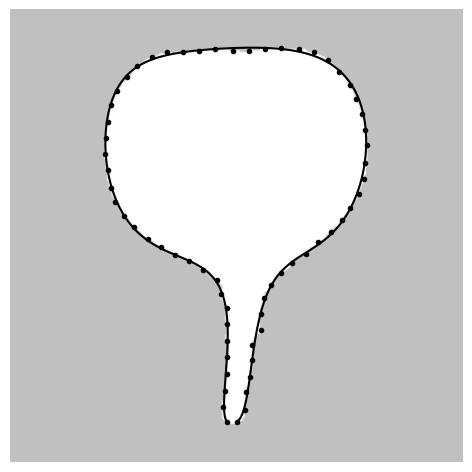

In [19]:
checkTo11(1,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

.
CP 5.0, steps:0, etime: 5.82812 err: 4.6326066178
...
CP 2.0, steps:3, etime: 9.53125 err: 1.9309207953
...............E

TEST ./pics\Beztest.png


((0.9775716202513552, 0.9775716202513552),
 28.078125,
 19,
 [[171.0, 277.0],
  [181.50857407857174, 243.86840521085574],
  [34.875137391190016, 61.006561604039106],
  [646.4515082792634, 590.9789267510976],
  [-1378.318221694111, -1045.2431154861065],
  [3067.8663037366173, 2124.5115157531504],
  [-2898.1452932696366, -3130.3969600434084],
  [2214.472274799953, 2806.3221920590136],
  [-889.1055876175178, -1231.731768142176],
  [399.17799913700895, 590.3241715613256],
  [102.6686746434366, 186.33004368991138],
  [167.0, 281.0]])

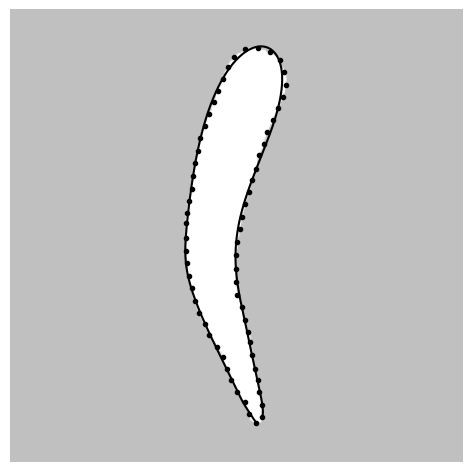

In [20]:
checkTo11(2,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

.
CP 5.0, steps:0, etime: 6.03125 err: 3.9007622813
..........
CP 2.0, steps:10, etime: 18.39062 err: 1.9745780416
.................................E

TEST ./pics\Beztest.png


((0.9852351997862347, 0.9852351997862347),
 59.15625,
 44,
 [[161.0, 279.0],
  [169.99915402715519, 257.45771033724174],
  [122.0885959378448, -140.741881134738],
  [450.0897348486403, 1331.4950983068466],
  [-831.9036206666113, -2315.3053983123737],
  [2236.8189444177633, 3086.596471084914],
  [-2097.0988300214776, -2934.0896878093577],
  [1520.6466831444898, 1731.1099862551794],
  [-455.42707042763254, -359.2439932052094],
  [275.72254854773166, 254.95878888798256],
  [117.05874018469615, 231.15070365700896],
  [154.0, 280.0]])

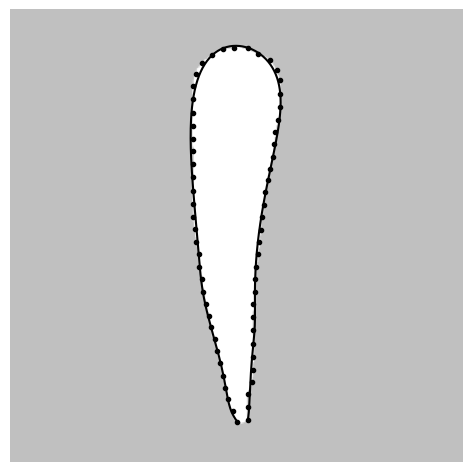

In [21]:
checkTo11(3,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

........
CP 5.0, steps:7, etime: 14.64062 err: 4.8732686829
........................................
CP 2.0, steps:47, etime: 65.07812 err: 1.9874960461
....................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................................................E

TEST ./pics\Beztest.png


((0.9976364272055265, 0.9976364272055265),
 602.28125,
 482,
 [[148.0, 279.0],
  [150.39543105625455, 245.70789098924175],
  [174.18429662873828, -672.8107164256871],
  [-39.21755679098878, 2757.435929486395],
  [-137.4419221153064, -4677.847055106039],
  [655.7360441072344, 5394.0730928594085],
  [-625.2322028313937, -4189.188273562193],
  [1150.1009759017618, 1799.022683564346],
  [-176.88758201196472, 148.07947961246046],
  [228.7197077099165, -86.80671201732567],
  [166.59206432116983, 218.84006737214946],
  [154.0, 280.0]])

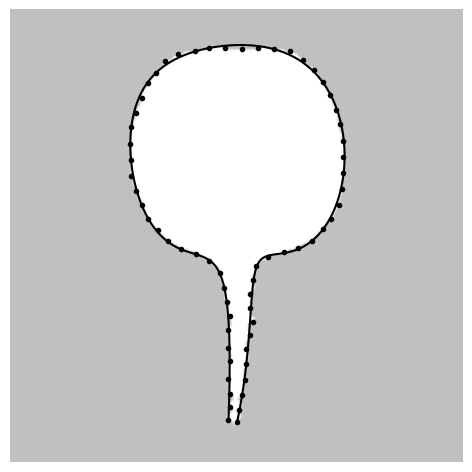

In [22]:
checkTo11(4,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

.
CP 5.0, steps:0, etime: 5.95312 err: 1.5999974894
.
CP 2.0, steps:1, etime: 7.20312 err: 1.4925408611
............E

TEST ./pics\Beztest.png


((0.9833908382969704, 0.9833908382969704),
 22.34375,
 14,
 [[150.0, 279.0],
  [118.26730940471381, 202.95245703764562],
  [288.5282354932699, 297.02615867531705],
  [-940.7010174639356, 145.17387721977687],
  [2751.6643669298423, -420.07601463899175],
  [-4133.897808015642, 1291.1120788460616],
  [4330.342225634286, -2113.6927460439792],
  [-2213.9188072974307, 1982.208122552157],
  [1072.5772954736763, -1006.8771738657982],
  [70.4611902751296, 650.4386653684397],
  [188.85142179617344, 150.90562809276224],
  [156.0, 279.0]])

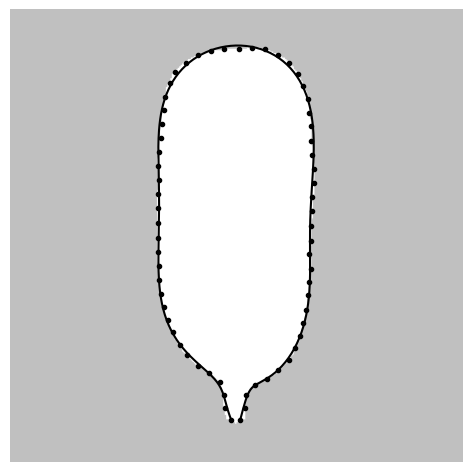

In [23]:
checkTo11(5,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

..
CP 5.0, steps:1, etime: 7.03125 err: 4.8447702049
................
CP 2.0, steps:17, etime: 27.46875 err: 1.9925390000
.....................................E

TEST ./pics\Beztest.png


((0.9969767745593562, 0.9969767745593562),
 73.78125,
 55,
 [[138.0, 279.0],
  [158.37372907424108, 129.60503711844086],
  [187.5827790956107, 647.989894046938],
  [-1254.6974898030705, -579.5479699202743],
  [4043.101359798226, 927.9504186365555],
  [-6477.271650463012, -1065.0424072949331],
  [7295.373123832537, 992.4458401602684],
  [-4932.249589092873, -799.4401391279732],
  [2713.253649339744, 492.07546592004405],
  [-446.59198117183377, 327.6502850652877],
  [264.68337911618204, 175.49534610399033],
  [144.0, 281.0]])

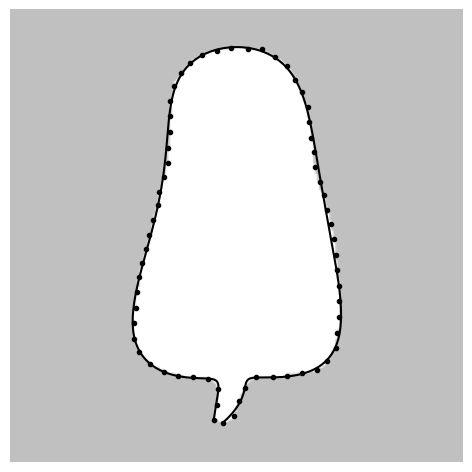

In [24]:
checkTo11(6,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

.
CP 5.0, steps:0, etime: 5.90625 err: 2.9383550066
.
CP 2.0, steps:1, etime: 7.15625 err: 1.6801819591
...E

TEST ./pics\Beztest.png


((0.9572155128529937, 0.9572155128529937),
 10.9375,
 5,
 [[168.0, 279.0],
  [157.6756629431496, 180.59875087822857],
  [224.18472208349397, 566.3519483165472],
  [366.1726600838779, -1108.8690111255141],
  [-503.2538737392024, 2484.412830802294],
  [1563.9328634030899, -2693.379796561783],
  [-1464.0796652716924, 1387.753211326281],
  [1249.720797108141, -78.03537460380309],
  [-421.26071094758566, -58.11306663155554],
  [242.36573562163227, 325.42555324153756],
  [116.59173269942085, 213.39907225237584],
  [161.0, 281.0]])

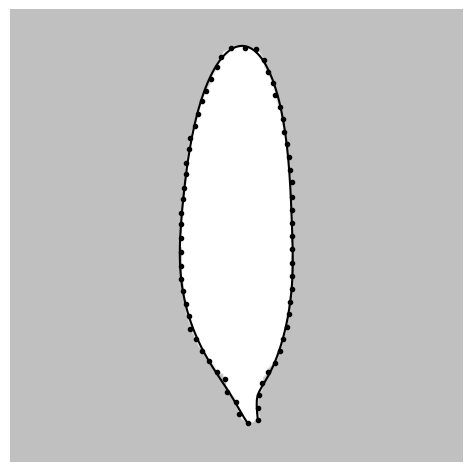

In [25]:
checkTo11(7,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

.
CP 5.0, steps:0, etime: 5.93750 err: 3.3363172919
..
CP 2.0, steps:2, etime: 8.42188 err: 1.8226914999
..................................................E

TEST ./pics\Beztest.png


((0.9986847553430915, 0.9986847553430915),
 70.859375,
 53,
 [[166.0, 279.0],
  [180.08731332251583, 251.41863031065427],
  [-39.60965067505329, -11.184449201312134],
  [1042.0979290215782, 756.795969208434],
  [-1795.6577311570763, -1135.097993873494],
  [3107.661863995708, 1805.376089242177],
  [-2536.0917815091275, -2222.907231665624],
  [1615.1394148304942, 1651.240138416479],
  [-393.57969818787456, -452.7038467023131],
  [206.00728490854078, 298.0103092681624],
  [148.74243360142611, 235.90290570860373],
  [159.0, 280.0]])

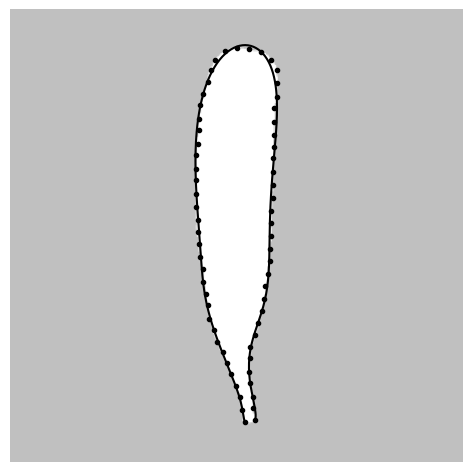

In [26]:
checkTo11(8,11,Nsamples=65,LR=0,mode=1,err_th=1.0)

# 次数による近似結果の違い

..e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e1e1e1.e1e1e1.e1e1e1..........................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................C

TEST ./pics\Beztest.png


((35.934166171998015, 35.934166171998015),
 157.21875,
 591,
 [[138.0, 279.0],
  [-56.336703924381425, 177.07644763818718],
  [353.4371916213337, -576.6806536135329],
  [175.76934606672754, 671.0943021043946],
  [268.38126633664734, 108.30801046225272],
  [144.0, 281.0]])

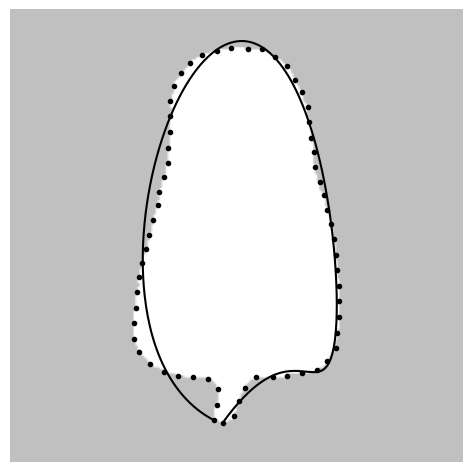

In [5]:
checkTo11(6,5,Nsamples=65,LR=0,mode=1,err_th=1.0)

....................................................................................................
....................................................................................................
................C

TEST ./pics\Beztest.png


((11.37775226212077, 11.37775226212077),
 83.71875,
 216,
 [[138.0, 279.0],
  [140.0572745114148, 67.68049674219051],
  [-86.95524203474186, 975.9108937432247],
  [218.9478383024461, -1421.982376537196],
  [272.66043068272495, 905.0233438425505],
  [251.43675494100577, 80.77403984738605],
  [144.0, 281.0]])

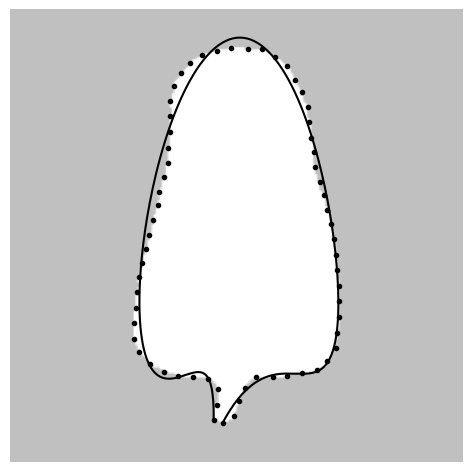

In [6]:
checkTo11(6,6,Nsamples=65,LR=0,mode=1,err_th=1.0)

....................................................................................................
............................C

TEST ./pics\Beztest.png


((11.272041254431839, 11.272041254431839),
 67.625,
 128,
 [[138.0, 279.0],
  [146.36755833436658, 92.45488536019764],
  [-71.18116906955564, 776.0726519494898],
  [180.5670757705555, -631.4844457172908],
  [179.16016181468385, -170.6872585278887],
  [307.34618017227, 575.377097207758],
  [216.4405329349563, 127.4829689893455],
  [144.0, 281.0]])

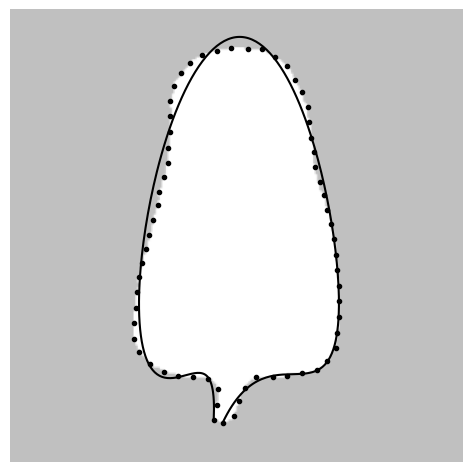

In [7]:
checkTo11(6,7,Nsamples=65,LR=0,mode=1,err_th=1.0)

....................................................................................................
....................................................................................................
............................................................................^.......................
...............................................^^...................................................
.....^^^.^^^.^....................^..^........^^^.^..C

TEST ./pics\Beztest.png


((5.800146757027325, 5.800146757027325),
 301.5,
 453,
 [[138.0, 279.0],
  [202.8016531045104, 84.81065803595986],
  [-570.9507019633579, 1001.9323376579272],
  [1609.7187600216782, -2197.778098812948],
  [-1896.647245009583, 3531.9166960260645],
  [1716.4923302956909, -3603.2230972650805],
  [-432.80956068175016, 2114.0473438059357],
  [419.89067983145, -78.28675188642316],
  [144.0, 281.0]])

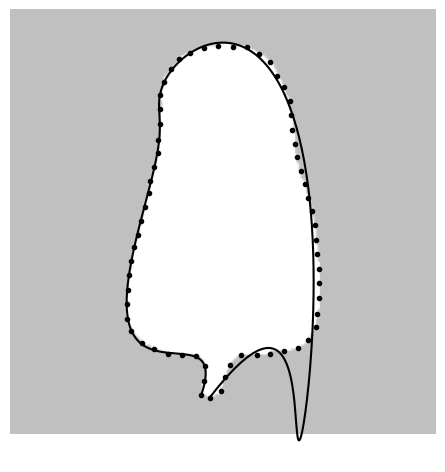

In [8]:
checkTo11(6,8,Nsamples=65,LR=0,mode=1,err_th=1.0)

.......................
CP 5.0, steps:22, etime: 23.17188 err: 4.9792939330
.............................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................
CP 2.0, steps:427, etime: 362.23438 err: 1.9987440912
........................................................................
....................................................................................................
....................................................................................................
...................................................................^..^.............................
......................................^^.^...^......................................

((1.7278069385321158, 1.7278069385321158),
 1629.6875,
 1952,
 [[138.0, 279.0],
  [212.93719794753474, 120.59649841271829],
  [-592.5600559462441, 712.5745449910122],
  [1599.899236582599, -957.0796811202529],
  [-1851.859430791706, 744.2923216497747],
  [1766.9783119496474, 96.3281672389915],
  [-688.5723142782892, -761.3974339289223],
  [554.0732727129244, 717.5932365961548],
  [212.17776759002396, 106.52243640104221],
  [144.0, 281.0]])

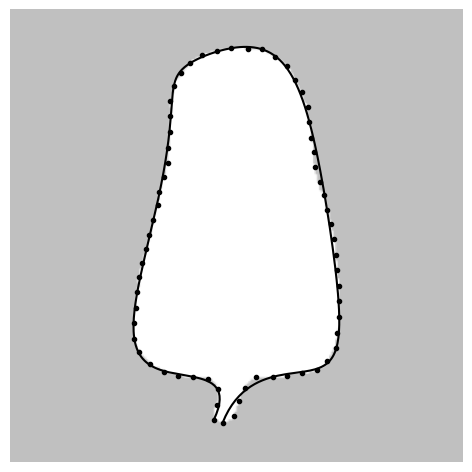

In [9]:
checkTo11(6,9,Nsamples=65,LR=0,mode=1,err_th=1.0)

...............
CP 5.0, steps:14, etime: 19.50000 err: 4.9681032359
.....................................................................................
.............
CP 2.0, steps:112, etime: 119.48438 err: 1.9972159095
.......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................^^^^^^^^^...........
........................................................................^^^^^^......................
.....................................^^^^^^.^^.^^..............................^^^^^^^^^^^...^.....^
..^..^..^.^^^^^^.^..^..^.^.^^^^........^.........^........^...^^^^^^^...^.^.^.......

((1.0006958609760621, 1.0006958609760621),
 3066.1875,
 3001,
 [[138.0, 279.0],
  [220.90609421721854, 92.34716455656745],
  [-774.5429183291566, 949.1545062007381],
  [2345.6713698459357, -2050.781297576508],
  [-3385.5954568915295, 3122.9338441812206],
  [3641.051727406518, -3279.9281292312144],
  [-2010.6510853137172, 2489.6499086416907],
  [1124.0540183328148, -1362.782355541603],
  [33.50667177606356, 889.1050970327473],
  [260.22192492561607, 81.33446373383703],
  [144.0, 281.0]])

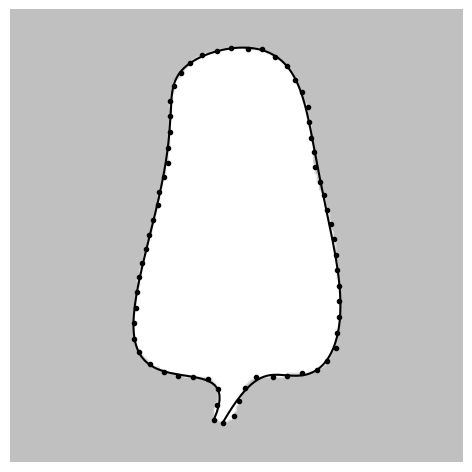

In [10]:
checkTo11(6,10,Nsamples=65,LR=0,mode=1,err_th=1.0)

..
CP 5.0, steps:1, etime: 6.96875 err: 4.8447702049
................
CP 2.0, steps:17, etime: 27.10938 err: 1.9925390000
.....................................
CP 1.0, steps:54, etime: 73.31250 err: 0.9969767746
.............................................
......................................................................................
CP 0.65, steps:185, etime: 235.18750 err: 0.6499130020
..............
....................................................................................................
....................................................................................................
....................................................................................................
.....^........................................^^^..^...................................^^^..........
....................^..^.^^^^.^^^.^^^^^.^^^^..^.....................................................
...^^^............^^^^.............^^........................^^^^^^^....^^..^^^^

((0.5763333068972725, 0.5763333068972725),
 3702.609375,
 3001,
 [[138.0, 279.0],
  [170.23412587858235, 123.90382448580523],
  [26.618684014245222, 687.4725982649289],
  [-720.4615738780166, -751.9168503246841],
  [3008.4845845574605, 1302.9513760056138],
  [-5047.922575935788, -2031.3094757328927],
  [5884.9025803929435, 2699.992446219951],
  [-3990.620333980059, -2583.2765242597025],
  [2259.389629130142, 1525.540203602054],
  [-292.26996009607115, -36.85348402367529],
  [233.0628882500392, 248.23154976356972],
  [144.0, 281.0]])

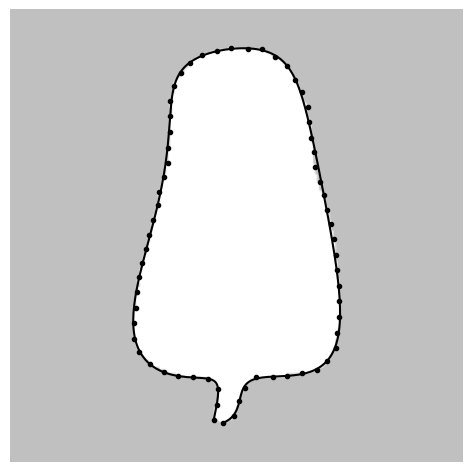

In [12]:
checkTo11(6,11,Nsamples=65,LR=0,mode=1,err_th=0.5)

.
CP 5.0, steps:0, etime: 6.32812 err: 3.3563993247
...........
CP 2.0, steps:11, etime: 22.50000 err: 1.9552111631
...........................
CP 1.0, steps:38, etime: 61.95312 err: 0.9829220112
...........................
CP 0.65, steps:65, etime: 101.62500 err: 0.6470104761
..................................
...................E

TEST ./pics\Beztest.png


((0.4995337124245274, 0.4995337124245274),
 179.359375,
 119,
 [[138.0, 279.0],
  [129.41090742694342, 236.77343910176504],
  [445.23674976731985, -11.746192254527882],
  [-1823.5813242799422, 1758.9102911191703],
  [4334.306155791703, -4227.270728037536],
  [-5221.925537698144, 6955.115178980461],
  [3820.3466339793786, -8130.432083234757],
  [-505.30315781096294, 7043.676328409341],
  [-780.0490519529274, -4528.422056902941],
  [1197.3806158258744, 2203.424658808744],
  [-92.18382037403731, -197.79662154459115],
  [213.62269838125505, 268.7988037681108],
  [144.0, 281.0]])

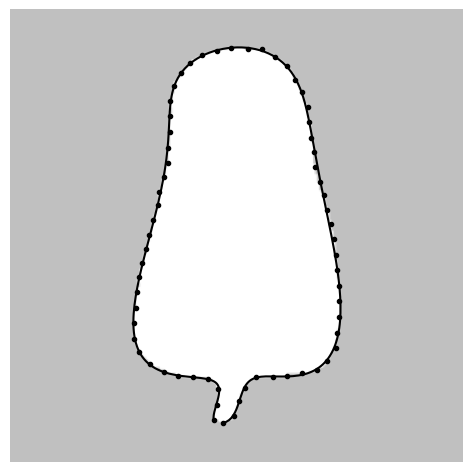

In [13]:
checkTo11(6,12,Nsamples=65,LR=0,mode=1,err_th=0.5)

....................................................................................................
....................................................................................................
..............................................................C

TEST ./pics\Beztest.png


((7.457770289031097, 7.457770289031097),
 45.640625,
 262,
 [[171.0, 277.0],
  [87.35219492098382, 47.94828086732308],
  [375.92735300565715, -69.30000381003617],
  [-15.564896842504133, 0.7677221869778325],
  [167.0, 281.0]])

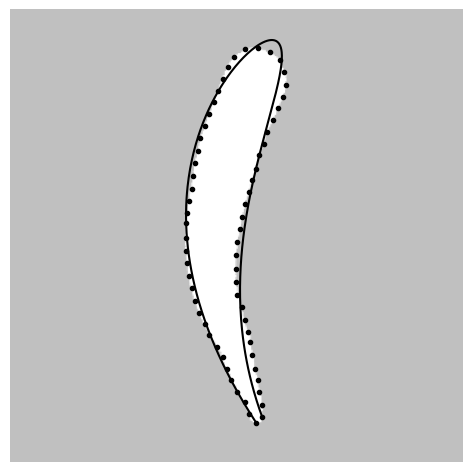

In [14]:
checkTo11(2,4,Nsamples=65,LR=0,mode=1,err_th=0.5)

....................................................................................................
.....................................................................................
CP 5.0, steps:184, etime: 50.56250 err: 4.9975052400
...............
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.....................................

((2.6645129767397853, 2.6645129767397853),
 561.90625,
 2144,
 [[171.0, 277.0],
  [116.7141263426004, 9.51654637173623],
  [181.25832920798905, 249.13214880891596],
  [318.6653375989358, -209.42341184804138],
  [-4.127238675662891, 55.43392039443059],
  [167.0, 281.0]])

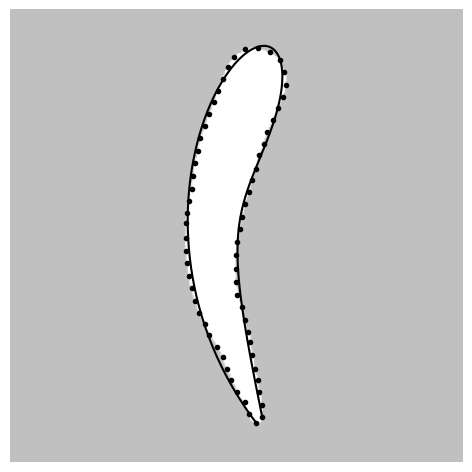

In [15]:
checkTo11(2,5,Nsamples=65,LR=0,mode=1,err_th=0.5)

............................
CP 5.0, steps:27, etime: 12.25000 err: 4.9451066902
........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................^^..........................................^^..^.^......................
.........................^^^........................................................^^^^.^.^.^......
..^^^^.........................^^^..^^..^..C

TEST ./pics\Beztest.png


((2.251572301271643, 2.251572301271643),
 276.546875,
 743,
 [[171.0, 277.0],
  [129.673600701211, 13.450896640201888],
  [108.40410933143743, 344.38754759395925],
  [441.9399736991572, -344.7733371427288],
  [-76.2457537961885, 87.02352586772518],
  [145.0462834141325, 222.01316462516056],
  [167.0, 281.0]])

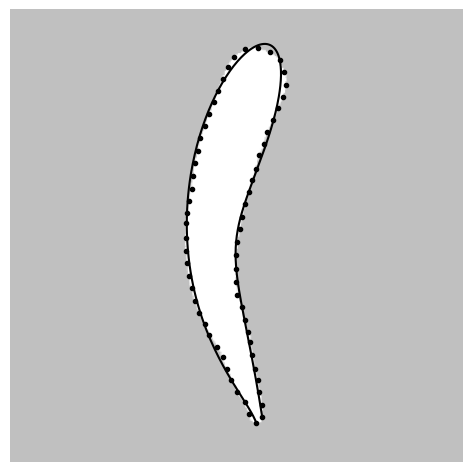

In [16]:
checkTo11(2,6,Nsamples=65,LR=0,mode=1,err_th=0.5)

................
CP 5.0, steps:15, etime: 10.71875 err: 4.9920801925
.........................................................
CP 2.0, steps:72, etime: 39.51562 err: 1.9948563411
...........................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................................^............................................
...............^...............................^...............................................^....
..................................^..............................^^........
CP 1.0, steps:674, etime: 343.12500 err: 0.9998547839
.........................
......^................................^......^^..^...........................^^^..........^....^.^^
...............................

((0.837118558464427, 0.837118558464427),
 1506.703125,
 3001,
 [[171.0, 277.0],
  [177.9521778784907, 199.86289727164132],
  [-42.1109373908939, -85.58276977406696],
  [637.0665487749015, 345.62300602436494],
  [-218.7185399244815, -525.3217116518343],
  [324.83201453782283, 446.38167356492033],
  [10.051316300688939, 3.7980967464343824],
  [167.0, 281.0]])

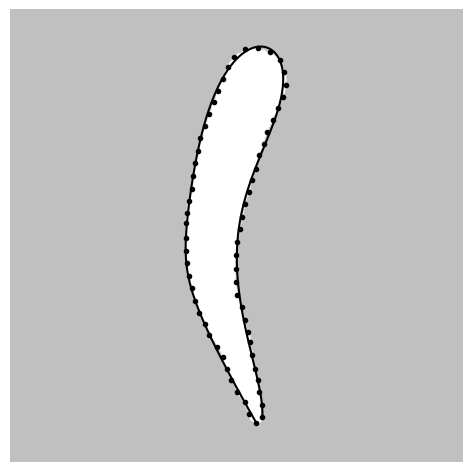

In [17]:
checkTo11(2,7,Nsamples=65,LR=0,mode=1,err_th=0.5)

Right
.
CP 5.0, steps:0, etime: 2.56250 err: 2.7063146791
..
CP 2.0, steps:2, etime: 3.48438 err: 1.9196344887
......
CP 1.0, steps:8, etime: 6.25000 err: 0.9858617105
...........
CP 0.65, steps:19, etime: 11.35938 err: 0.6456744623
................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................^^.^^^.^.^.^.^.^^^.......................
........................................^^^^....^....^....^^^.^^.^^.^^.^^.^^.^..^...................
.........^^^^...^^^^^^.......^^.^^^^^^^^^^^^^^^^^^^.^^^.^..^^^^^..^^^^^...^^^^.^

((0, 0.5247675831451561),
 1395.71875,
 (1, 3001),
 ([],
  [[157.0, 27.0],
   [184.75530669228024, 21.44002810040363],
   [214.93299692549982, 57.89040425445432],
   [203.20031804546096, -157.9184380869213],
   [468.87222312576364, 679.8830032474815],
   [-114.43386406753629, -183.17754761655615],
   [281.01358023614625, 251.95728873441263],
   [145.32752032846193, 185.69633172967107],
   [161.48783669628938, 250.38461590961444],
   [153.0, 281.0]]))

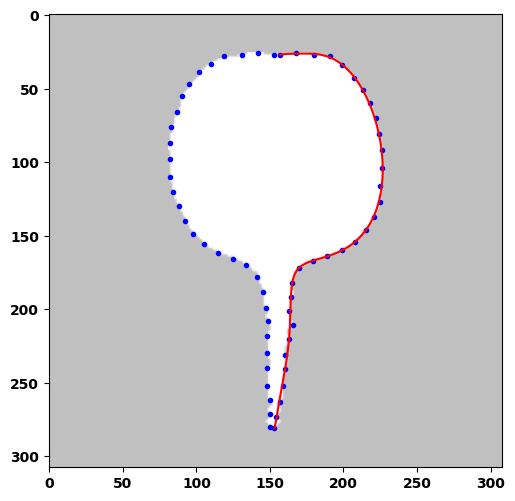

In [12]:
%%time
checkToD(4,N=9,LR=2,err_th=0.5,lr=0.001)

Right
.
CP 5.0, steps:0, etime: 3.43750 err: 1.5718157826
.
CP 2.0, steps:1, etime: 4.00000 err: 1.3185747232
...
CP 1.0, steps:4, etime: 5.68750 err: 0.9907674717
...............
CP 0.65, steps:19, etime: 14.17188 err: 0.6468492724
................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................^...^..^^^..^^^^..........................................................
........................................................^^^^^..............^^...^^....^....^^.^..^^.
^^.^^^.^^^..^^^^^.^^^^^.^^.^^^^..^..............................................

((0, 0.5195263070924786),
 1707.96875,
 (1, 3001),
 ([],
  [[157.0, 27.0],
   [181.85283899551317, 24.158997209569037],
   [167.4222971201351, 38.332268311111285],
   [405.55777648833106, -98.05536879070654],
   [-25.963015402378204, 556.4337834583571],
   [587.7756810265744, -268.8066761242717],
   [-174.5651575470364, 586.0399449711718],
   [301.7870919800615, -144.7979637129586],
   [146.4593121947795, 285.64900919334985],
   [156.91654889121986, 256.8736451583328],
   [153.0, 281.0]]))

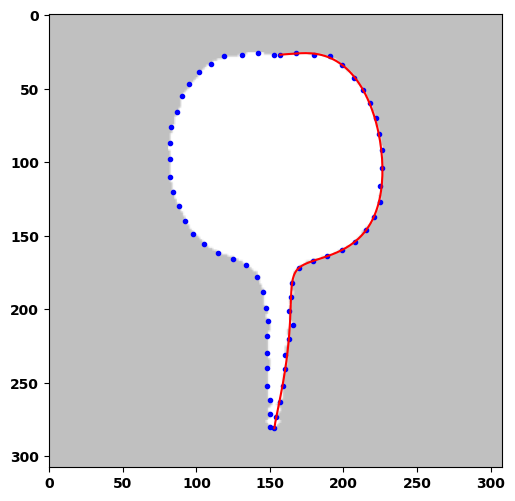

In [13]:
%%time
checkToD(4,N=10,LR=2,err_th=0.5,lr=0.001)

Right
.
CP 5.0, steps:0, etime: 3.43750 err: 1.2808578605
.
CP 2.0, steps:1, etime: 4.10938 err: 1.1481544018
..
CP 1.0, steps:3, etime: 5.46875 err: 0.9290544465
.....
CP 0.65, steps:8, etime: 8.92188 err: 0.6411546148
..............................................................E

Wall time: 51.4 s


((0, 0.499668909018885),
 51.375,
 (1, 71),
 ([],
  [[157.0, 27.0],
   [194.83778294741012, 34.47245856680536],
   [217.2827755745356, -96.85803745875104],
   [383.24232244098647, 628.7359459120147],
   [-307.8832637883235, -1138.5316908959267],
   [1201.9309063839903, 1730.2065895934845],
   [-704.9038619068203, -915.1152376737524],
   [572.8329667712754, 599.3655988645563],
   [49.265378980577474, 54.469932723090345],
   [186.3762605809505, 252.501368857541],
   [156.31752564663074, 250.25721591429513],
   [153.0, 281.0]]))

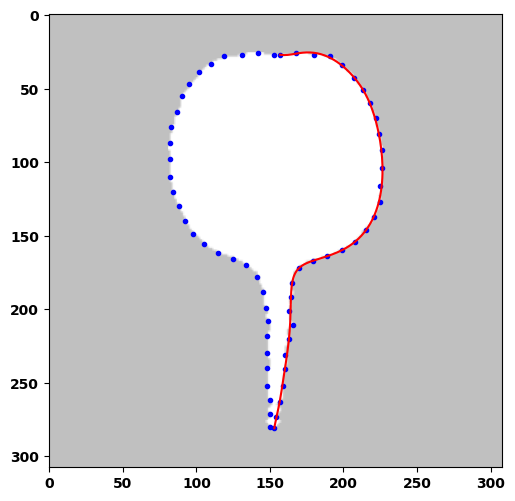

In [14]:
%%time
checkToD(4,N=11,LR=2,err_th=0.5,lr=0.001)

Left
......................
CP 5.0, steps:21, etime: 4.04688 err: 4.8879243534
..............................................................................
....................................................................................................
..........................
CP 2.0, steps:225, etime: 35.34375 err: 1.9999491557
..........................................................................
....................................................................................................
..........^.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

((1.1235400835582585, 0.7917834489054183),
 909.03125,
 (2869, 3001),
 ([[148.0, 27.0],
   [-35.38404569210482, -3.3736341487925543],
   [90.88828533180224, 366.7221823174053],
   [196.40108277314124, 13.569229277011061],
   [130.65379589384543, 257.8035920959564],
   [149.0, 281.0]],
  [[151.0, 28.0],
   [340.1319130299346, -15.47596593589747],
   [211.95536596962657, 345.0998372951195],
   [149.96983639860397, 27.09557916218427],
   [179.21903720857364, 254.27007742859894],
   [153.0, 280.0]]))

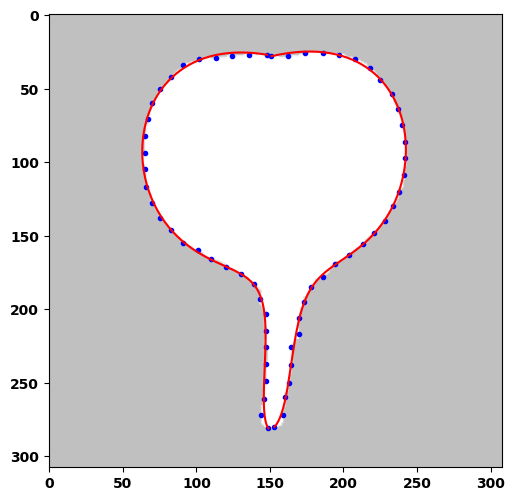

In [20]:
%%time
checkToD(1,N=5,err_th=0.5,lr=0.0015)

Left
.......
CP 5.0, steps:6, etime: 1.15625 err: 4.3118219705
..........................
CP 2.0, steps:32, etime: 3.82812 err: 1.9645175601
.................................
CP 1.0, steps:65, etime: 7.26562 err: 0.9989126298
..........................
CP 0.65, steps:91, etime: 9.92188 err: 0.6436916187
........
..............E

Right
..........
CP 5.0, steps:9, etime: 1.46875 err: 4.6036585905
............
CP 2.0, steps:21, etime: 2.84375 err: 1.9400371223
.....................
CP 1.0, steps:42, etime: 5.00000 err: 0.9760185313
.................
CP 0.65, steps:59, etime: 6.71875 err: 0.6437436519
.................E

Wall time: 20.8 s


((0.499283652300193, 0.49741342206849476),
 20.8125,
 (114, 77),
 ([[154.0, 27.0],
   [32.90255177521977, 43.03036642628181],
   [235.38050682963464, 111.96023040462414],
   [-24.189503381911088, 252.98887120687672],
   [151.0, 279.0]],
  [[157.0, 26.0],
   [267.4860232753467, 41.322847076605925],
   [61.60135939497141, 154.9989202782046],
   [340.28880229263535, 240.12132529517422],
   [154.0, 280.0]]))

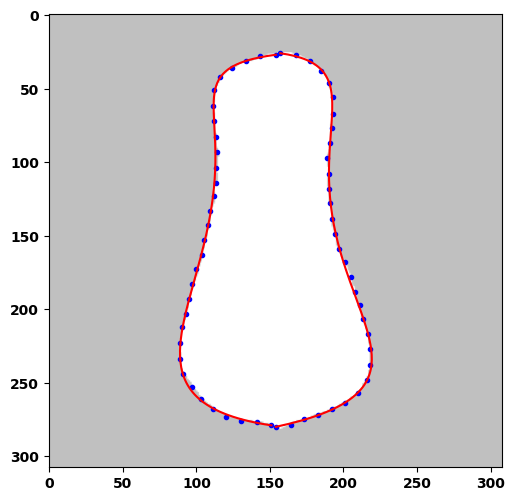

In [18]:
%%time
checkToD(0,N=4,err_th=0.5,lr=0.0015)

....................................................................................................
....................................................................................................
.................................................................C

....................................................................................................
....................................................................................................
........................................C

Wall time: 32 s


((33.61164510082403, 48.6095515876373),
 32.0,
 (265, 240),
 ([[154.0, 27.0],
   [125.85064078860877, -31.594108377995006],
   [38.16404127378264, 319.6690789644979],
   [151.0, 279.0]],
  [[157.0, 26.0],
   [169.6464845277597, -32.2633590049885],
   [271.15478186057123, 320.5132074389504],
   [154.0, 280.0]]))

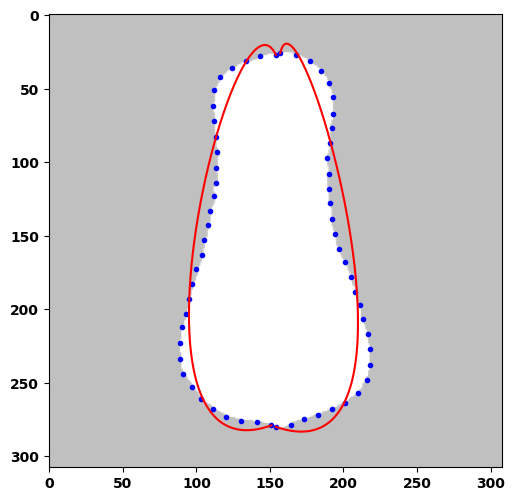

In [14]:
%%time
checkToD(0,N=3,err_th=0.5)

.........
CP 5.0, steps:8, etime: 1.34375 err: 4.8156384459
..................................
CP 2.0, steps:42, etime: 4.76562 err: 1.9769622870
.........................................
CP 1.0, steps:83, etime: 8.85938 err: 0.9874181315
................
..............
CP 0.65, steps:113, etime: 11.87500 err: 0.6428368847
..........................E

...............
CP 5.0, steps:14, etime: 2.04688 err: 4.5689235521
..............
CP 2.0, steps:28, etime: 3.46875 err: 1.9798876248
.........................
CP 1.0, steps:53, etime: 5.96875 err: 0.9767090355
....................
CP 0.65, steps:73, etime: 7.96875 err: 0.6398372813
...................E

Wall time: 24.6 s


((0.49668074636758824, 0.49711326471181116),
 24.734375,
 (140, 93),
 ([[154.0, 27.0],
   [32.83936920798376, 43.122347100387564],
   [235.4833741371077, 111.73963567913006],
   [-24.226132575828025, 252.98995850447417],
   [151.0, 279.0]],
  [[157.0, 26.0],
   [267.4990844834438, 41.353710521343906],
   [61.580147224012975, 154.95933317019055],
   [340.2969182679209, 240.12232643671547],
   [154.0, 280.0]]))

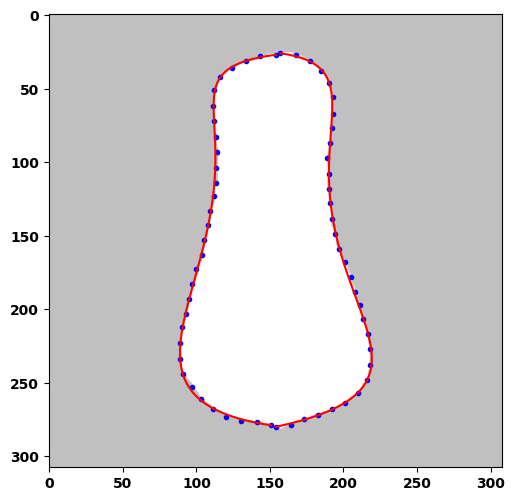

In [12]:
%%time
checkToD(0,N=4,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.90625 err: 3.9003206849
..
CP 2.0, steps:2, etime: 1.20312 err: 1.9779057208
..
CP 1.0, steps:4, etime: 1.50000 err: 0.9264861346
..
CP 0.65, steps:6, etime: 1.79688 err: 0.5368626604
.E

..
CP 5.0, steps:1, etime: 1.04688 err: 4.0319682937
...
CP 2.0, steps:4, etime: 1.48438 err: 1.5858393153
..
CP 1.0, steps:6, etime: 1.79688 err: 0.8902421117
..
CP 0.65, steps:8, etime: 2.09375 err: 0.5686447268
.E

Wall time: 4.4 s


((0.49697905573902357, 0.4924863510026046),
 4.375,
 (8, 10),
 ([[154.0, 27.0],
   [36.820560621934774, 34.05030761773013],
   [211.94230374421616, 143.9484938337196],
   [47.3581716845332, 176.78305417392633],
   [54.55524265535238, 272.6920727360837],
   [151.0, 279.0]],
  [[157.0, 26.0],
   [273.2900000372532, 45.940243275248115],
   [62.12107158061507, 130.0704972166173],
   [289.9540021248442, 214.4580810497768],
   [240.12513781903164, 265.56111456194657],
   [154.0, 280.0]]))

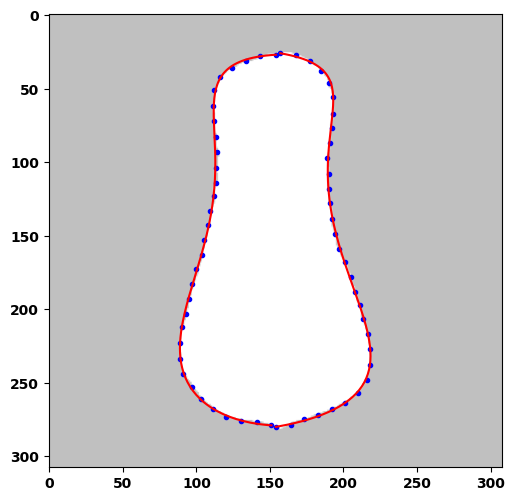

In [15]:
%%time
checkToD(0,N=5,err_th=0.5)

.
CP 5.0, steps:0, etime: 1.25000 err: 1.8697723598
.
CP 2.0, steps:1, etime: 1.46875 err: 1.5683805942
....
CP 1.0, steps:5, etime: 2.29688 err: 0.8538625258
..
CP 0.65, steps:7, etime: 2.71875 err: 0.6281357047
..E

.
CP 5.0, steps:0, etime: 1.26562 err: 1.2609995652
.
CP 2.0, steps:1, etime: 1.48438 err: 0.9250558571
.
CP 1.0, steps:2, etime: 1.68750 err: 0.8175989125
..
CP 0.65, steps:4, etime: 2.10938 err: 0.6279796839
..E

Wall time: 5.88 s


((0.4886699492306217, 0.46482398654098567),
 5.84375,
 (10, 7),
 ([[154.0, 27.0],
   [59.57324823863286, 30.92147885697553],
   [142.10293543388468, 118.30507670787426],
   [150.8235183036316, 137.82133641734725],
   [28.222560596326847, 218.69778275449167],
   [83.4652049296137, 276.84205828013756],
   [151.0, 279.0]],
  [[157.0, 26.0],
   [228.28920678432027, 21.24551300146109],
   [202.62031425368244, 162.8459939623358],
   [77.3142159672841, 97.36030096283991],
   [349.8391474633886, 257.64130051536387],
   [191.80275711133638, 270.5669236832109],
   [154.0, 280.0]]))

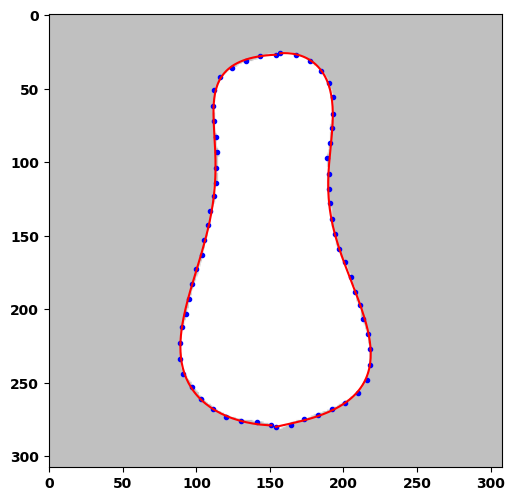

In [17]:
%%time
checkToD(0,N=6,err_th=0.5)

............................
CP 5.0, steps:27, etime: 3.29688 err: 4.7830844250
........................................................................
....................................................................................................
............C

...................................
CP 5.0, steps:34, etime: 4.04688 err: 4.9190819033
.................................................................
....................................................................................................
...................................................................C

Wall time: 50 s


((2.076649482713184, 2.0298458446971344),
 50.046875,
 (212, 267),
 ([[148.0, 27.0],
   [-36.43487553888242, 4.387739380443991],
   [118.05301958643506, 329.67756250017953],
   [146.54168067758533, 41.740971989841746],
   [149.0, 281.0]],
  [[151.0, 28.0],
   [345.25484186865907, -7.954288297432792],
   [176.85582538802737, 321.03248859941493],
   [205.49290633736874, 37.917934430209876],
   [153.0, 280.0]]))

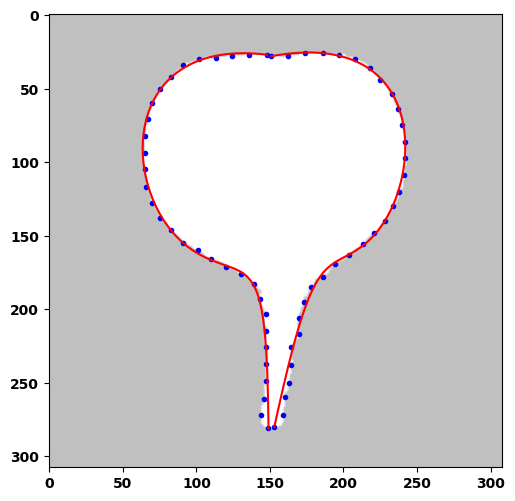

In [18]:
%%time
checkToD(1,N=4,err_th=0.5)

.............................
CP 5.0, steps:28, etime: 5.20312 err: 4.9779641152
.......................................................................
...................................................................................
CP 2.0, steps:182, etime: 28.40625 err: 1.9998485935
.................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................................................

((1.12156300071975, 0.792704532766406),
 706.78125,
 (1681, 2981),
 ([[148.0, 27.0],
   [-35.52315989294961, -3.356496651386881],
   [91.15995503778997, 367.0636724248741],
   [196.3384264725776, 13.094511844815024],
   [130.65437063264645, 258.18840329550846],
   [149.0, 281.0]],
  [[151.0, 28.0],
   [340.31531433694244, -15.368513125067619],
   [211.60504071648518, 345.13677122944387],
   [150.19149648951495, 27.1762495939466],
   [179.2114717782623, 254.00384061868627],
   [153.0, 280.0]]))

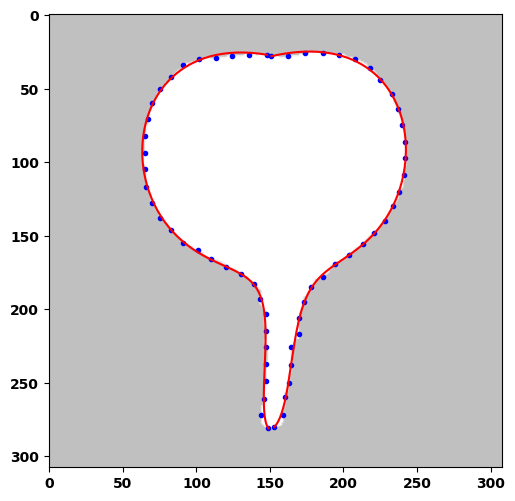

In [19]:
%%time
checkToD(1,N=5,err_th=0.5)

.
CP 5.0, steps:0, etime: 1.28125 err: 1.9599917605
.
CP 2.0, steps:1, etime: 1.50000 err: 1.4925236242
..
CP 1.0, steps:3, etime: 1.93750 err: 0.9847833824
....
CP 0.65, steps:7, etime: 2.79688 err: 0.6067206725
.....E

.
CP 5.0, steps:0, etime: 1.26562 err: 2.1420666688
.
CP 2.0, steps:1, etime: 1.46875 err: 1.6834158080
.....
CP 1.0, steps:6, etime: 2.51562 err: 0.9657774231
.......
CP 0.65, steps:13, etime: 3.98438 err: 0.6428159849
.............................E

Wall time: 14.2 s


((0.49579383325090337, 0.49967024376667224),
 14.203125,
 (13, 43),
 ([[148.0, 27.0],
   [74.08894075730889, 41.377638210353474],
   [60.797714931143496, -73.43616126348833],
   [-55.62185383894711, 443.00576229532277],
   [264.08440203812813, -42.93012472572366],
   [117.9935219024838, 270.1510088327996],
   [149.0, 281.0]],
  [[151.0, 28.0],
   [202.31824297957465, 33.17927367381678],
   [300.47539441974567, -69.32491116591133],
   [286.22689853811215, 406.8126325579321],
   [118.11586302116191, -18.203551413784137],
   [185.57359589150815, 260.24410920373566],
   [153.0, 280.0]]))

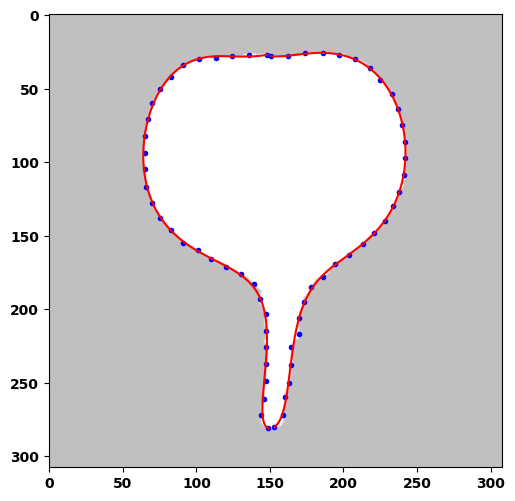

In [20]:
%%time
checkToD(1,N=6,err_th=0.5)

............................
CP 5.0, steps:27, etime: 3.23438 err: 4.7830844250
........................................................................
....................................................................................................
............C

...................................
CP 5.0, steps:34, etime: 3.96875 err: 4.9190819033
.................................................................
....................................................................................................
...................................................................C

Wall time: 49.8 s


((2.076649482713184, 2.0298458446971344),
 49.8125,
 (212, 267),
 ([[148.0, 27.0],
   [-36.43487553888242, 4.387739380443991],
   [118.05301958643506, 329.67756250017953],
   [146.54168067758533, 41.740971989841746],
   [149.0, 281.0]],
  [[151.0, 28.0],
   [345.25484186865907, -7.954288297432792],
   [176.85582538802737, 321.03248859941493],
   [205.49290633736874, 37.917934430209876],
   [153.0, 280.0]]))

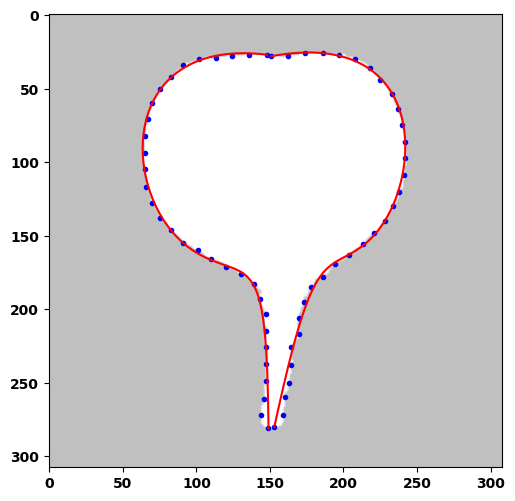

In [21]:
%%time
checkToD(2,N=4,err_th=0.5)

.............................
CP 5.0, steps:28, etime: 5.03125 err: 4.9779641152
.......................................................................
...................................................................................
CP 2.0, steps:182, etime: 28.14062 err: 1.9998485935
.................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................................................

((1.12156300071975, 0.792704532766406),
 704.546875,
 (1681, 2981),
 ([[148.0, 27.0],
   [-35.52315989294961, -3.356496651386881],
   [91.15995503778997, 367.0636724248741],
   [196.3384264725776, 13.094511844815024],
   [130.65437063264645, 258.18840329550846],
   [149.0, 281.0]],
  [[151.0, 28.0],
   [340.31531433694244, -15.368513125067619],
   [211.60504071648518, 345.13677122944387],
   [150.19149648951495, 27.1762495939466],
   [179.2114717782623, 254.00384061868627],
   [153.0, 280.0]]))

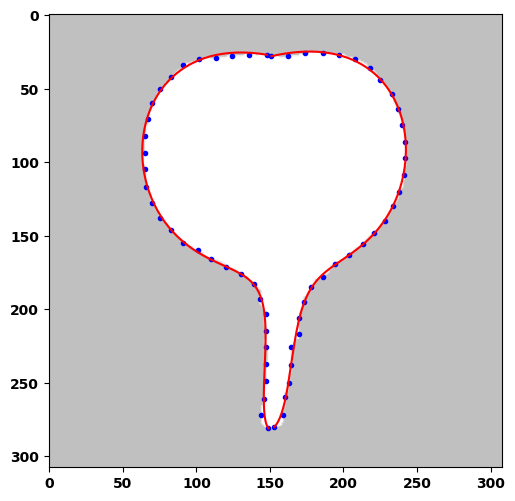

In [22]:
%%time
checkToD(1,N=5,err_th=0.5)

.
CP 5.0, steps:0, etime: 1.18750 err: 1.9599917605
.
CP 2.0, steps:1, etime: 1.39062 err: 1.4925236242
..
CP 1.0, steps:3, etime: 1.81250 err: 0.9847833824
....
CP 0.65, steps:7, etime: 2.67188 err: 0.6067206725
.....E

.
CP 5.0, steps:0, etime: 1.18750 err: 2.1420666688
.
CP 2.0, steps:1, etime: 1.39062 err: 1.6834158080
.....
CP 1.0, steps:6, etime: 2.45312 err: 0.9657774231
.......
CP 0.65, steps:13, etime: 3.93750 err: 0.6428159849
.............................E

Wall time: 14.1 s


((0.49579383325090337, 0.49967024376667224),
 14.078125,
 (13, 43),
 ([[148.0, 27.0],
   [74.08894075730889, 41.377638210353474],
   [60.797714931143496, -73.43616126348833],
   [-55.62185383894711, 443.00576229532277],
   [264.08440203812813, -42.93012472572366],
   [117.9935219024838, 270.1510088327996],
   [149.0, 281.0]],
  [[151.0, 28.0],
   [202.31824297957465, 33.17927367381678],
   [300.47539441974567, -69.32491116591133],
   [286.22689853811215, 406.8126325579321],
   [118.11586302116191, -18.203551413784137],
   [185.57359589150815, 260.24410920373566],
   [153.0, 280.0]]))

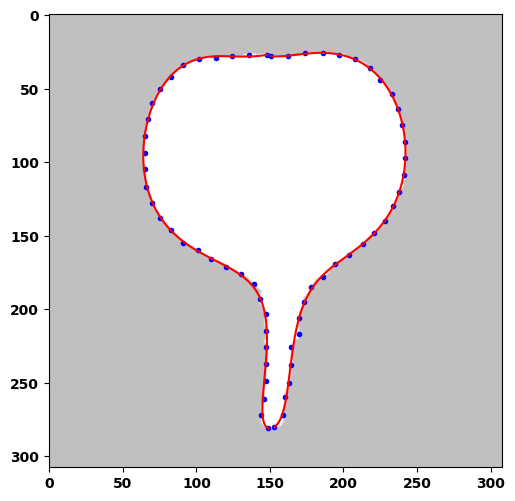

In [23]:
%%time
checkToD(1,N=6,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.57812 err: 3.8285697084
........
CP 2.0, steps:8, etime: 1.40625 err: 1.8923084484
...........................................................................................
....................................................................................................
..................
CP 1.0, steps:217, etime: 22.95312 err: 0.9993611713
..................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................

((0.6366912749588101, 0.5651855835371603),
 513.96875,
 (3001, 1998),
 ([[167.0, 26.0],
   [128.34888536969407, 20.847214333933163],
   [128.01972735962022, 164.05555845361474],
   [83.71858342454212, 147.91955848594625],
   [169.0, 281.0]],
  [[171.0, 27.0],
   [232.7739851552072, 48.40301358836834],
   [95.45120892010742, 143.4314080171081],
   [169.63153969429916, 203.63096155825448],
   [171.0, 278.0]]))

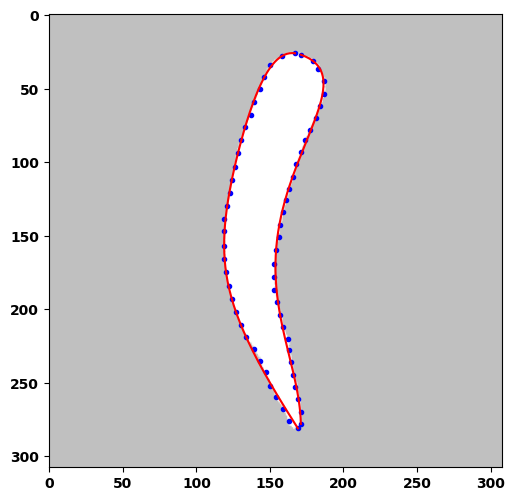

In [24]:
%%time
checkToD(2,N=4,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.89062 err: 1.8093140184
.
CP 2.0, steps:1, etime: 1.06250 err: 1.4363963109
..
CP 1.0, steps:3, etime: 1.35938 err: 0.9204084285
..
CP 0.65, steps:5, etime: 1.65625 err: 0.6165728254
..E

.
CP 5.0, steps:0, etime: 0.90625 err: 1.2817775583
.
CP 2.0, steps:1, etime: 1.06250 err: 0.9346157423
.
CP 1.0, steps:2, etime: 1.20312 err: 0.8413542984
.....
CP 0.65, steps:7, etime: 1.96875 err: 0.6490860148
.............E

Wall time: 6.04 s


((0.4679022989508819, 0.497684258087661),
 6.015625,
 (8, 21),
 ([[167.0, 26.0],
   [119.69442475029575, 23.240381768451552],
   [131.46805432598157, 204.5213265051738],
   [79.73612895425417, 113.45114635335182],
   [150.57927630732033, 263.3340347026735],
   [169.0, 281.0]],
  [[171.0, 27.0],
   [229.01135598888067, 50.22873099963551],
   [119.31533518574206, 116.58611416585136],
   [146.04300340831003, 196.63288957927494],
   [166.32414371241714, 213.60320522223367],
   [171.0, 278.0]]))

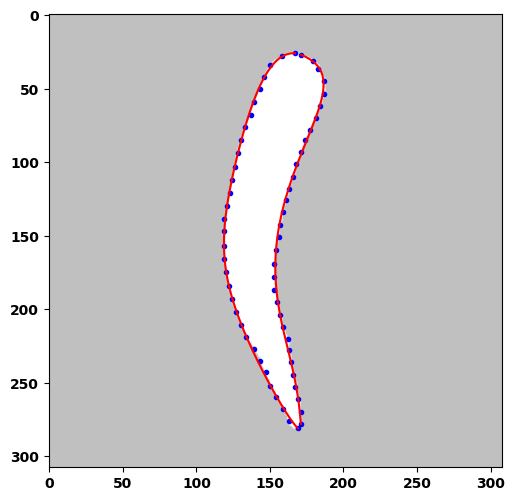

In [27]:
%%time
checkToD(2,N=5,err_th=0.5)

.
CP 5.0, steps:0, etime: 1.26562 err: 0.6264042583
.
CP 2.0, steps:1, etime: 1.48438 err: 0.5498995557
^
CP 1.0, steps:2, etime: 1.68750 err: 0.5658363532
^
CP 0.65, steps:3, etime: 1.89062 err: 0.5515008121
..E

.
CP 5.0, steps:0, etime: 1.26562 err: 1.0844507596
.
CP 2.0, steps:1, etime: 1.48438 err: 0.9327758300
.
CP 1.0, steps:2, etime: 1.70312 err: 0.8779291544
....
CP 0.65, steps:6, etime: 2.57812 err: 0.6284845306
.....E

Wall time: 6.06 s


((0.4863490419661082, 0.47837342452349224),
 6.046875,
 (6, 12),
 ([[167.0, 26.0],
   [111.66660245338585, 34.33229331268871],
   [168.77565677526837, 134.2059676028587],
   [51.51922039320447, 141.01669689728817],
   [144.42465880799622, 197.2781709069411],
   [139.42272520430606, 251.0468161224432],
   [169.0, 281.0]],
  [[171.0, 27.0],
   [224.34584919112146, 54.50937837042557],
   [140.27678590963026, 81.36303191392327],
   [153.114172703812, 178.81256174156977],
   [138.4720448532025, 174.62304957649783],
   [171.70609236467982, 236.93145262726506],
   [171.0, 278.0]]))

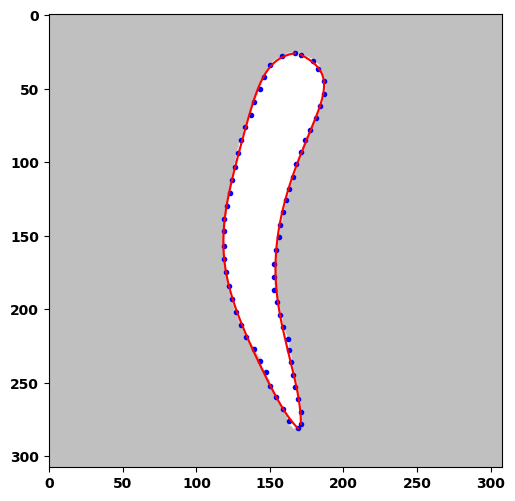

In [28]:
%%time
checkToD(2,N=6,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.59375 err: 3.5925958121
.....
CP 2.0, steps:5, etime: 1.09375 err: 1.9829726337
..............................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................^.^..^..........................................................^.^^^..^
^..^..^.............................C

.
CP 5.0, steps:0, etime: 0.60938 err: 2.3602775712
.
CP 2.0, steps:1, etime: 0.70312 err: 1.4456154314
..
CP 1.0, steps:3, etime: 0.90625 err: 0.951071

((1.0148538755914274, 0.4959468792926547),
 76.828125,
 (736, 15),
 ([[152.0, 26.0],
   [100.85162886449957, 16.502662790654618],
   [125.29405898117136, 154.4072291285532],
   [137.44346008921985, 255.70874811168457],
   [156.0, 281.0]],
  [[156.0, 26.0],
   [230.58773240063306, 32.96137443174276],
   [126.96992252640345, 181.03595838709117],
   [181.75451457621335, 192.58565607279206],
   [159.0, 280.0]]))

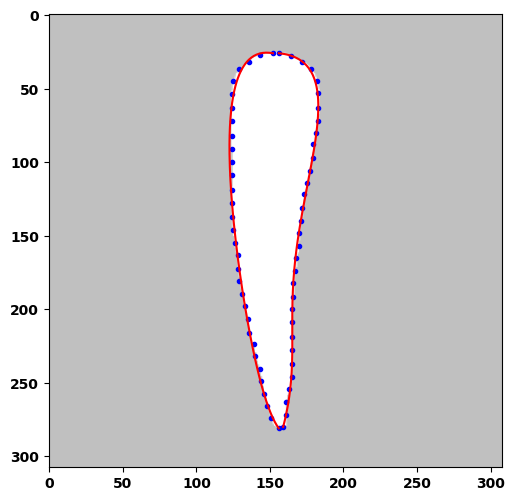

In [29]:
%%time
checkToD(3,N=4,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.90625 err: 1.4812134442
.
CP 2.0, steps:1, etime: 1.06250 err: 1.3171270916
..........
CP 1.0, steps:11, etime: 2.75000 err: 0.9994075455
........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................................................
CP 0.65, steps:571, etime: 86.78125 err: 0.6496760359
............................
....................................................................................................
....................................................................................

((0.5037869323094343, 0.4695746804196947),
 456.265625,
 (3001, 3),
 ([[152.0, 26.0],
   [88.34920887400679, 27.371145317467317],
   [160.90341740958584, 135.7156649645112],
   [89.55808122284694, 68.16697356018001],
   [143.97759753826074, 266.0719071882214],
   [156.0, 281.0]],
  [[156.0, 26.0],
   [223.37675160361707, 28.681341896950148],
   [149.87321023161675, 155.3909825742395],
   [167.05331241700338, 137.3574873163107],
   [169.97614206665966, 233.31628250455068],
   [159.0, 280.0]]))

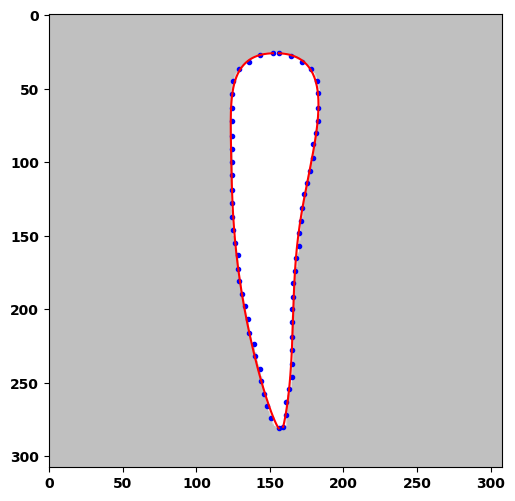

In [30]:
%%time
checkToD(3,N=5,err_th=0.5)

.E

.
CP 5.0, steps:0, etime: 1.26562 err: 0.7439031206
.
CP 2.0, steps:1, etime: 1.48438 err: 0.6055781395
.
CP 1.0, steps:2, etime: 1.70312 err: 0.5440211985
.E

Wall time: 3.37 s


((0.43359603243850586, 0.4580456376121378),
 3.34375,
 (1, 4),
 ([[152.0, 26.0],
   [84.90942978751178, 25.619299414997982],
   [172.25564538417336, 129.72372242975462],
   [70.2714259124052, 139.0400882198579],
   [164.5107165081609, 205.32882160597777],
   [127.57038897352413, 238.55539767314053],
   [156.0, 281.0]],
  [[156.0, 26.0],
   [213.9427625950866, 28.58921201540536],
   [169.28420072354012, 116.52064778113218],
   [165.1314931107896, 139.29834092577238],
   [163.82692564180388, 172.84098841189473],
   [169.2633695566849, 241.579223916651],
   [159.0, 280.0]]))

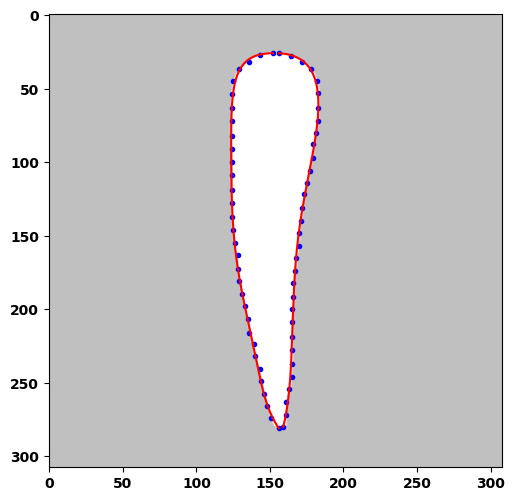

In [31]:
%%time
checkToD(3,N=6,err_th=0.5)

..................................
CP 5.0, steps:33, etime: 4.07812 err: 4.7015100185
.........
CP 2.0, steps:42, etime: 5.04688 err: 1.8048171052
......
CP 1.0, steps:48, etime: 5.65625 err: 0.9722251062
......
CP 0.65, steps:54, etime: 6.29688 err: 0.6398425412
.........E

................................................
CP 5.0, steps:47, etime: 5.79688 err: 4.9850054289
....................................................
..................................................C

Wall time: 24 s


((0.49446354662408787, 2.500070078832139),
 24.015625,
 (64, 150),
 ([[153.0, 27.0],
   [9.954663164103613, -1.0003598387318915],
   [106.0372820648245, 328.67442954700044],
   [151.59653919199087, 31.22748423810582],
   [150.0, 280.0]],
  [[157.0, 27.0],
   [307.254036794831, 5.485648961513247],
   [175.6311045596604, 360.417604192277],
   [184.41855689292566, -0.3461046342499875],
   [153.0, 281.0]]))

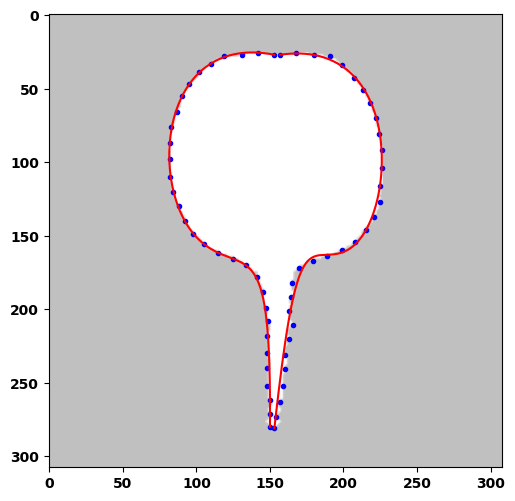

In [32]:
%%time
checkToD(4,N=4,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.84375 err: 1.4812134442
.
CP 2.0, steps:1, etime: 0.98438 err: 1.3171270916
..........
CP 1.0, steps:11, etime: 2.53125 err: 0.9994075455
........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................................................
CP 0.65, steps:571, etime: 90.45312 err: 0.6496760359
............................
....................................................................................................
....................................................................................

((0.5037869323094343, 0.4695746804196947),
 467.96875,
 (3001, 3),
 ([[152.0, 26.0],
   [88.34920887400679, 27.371145317467317],
   [160.90341740958584, 135.7156649645112],
   [89.55808122284694, 68.16697356018001],
   [143.97759753826074, 266.0719071882214],
   [156.0, 281.0]],
  [[156.0, 26.0],
   [223.37675160361707, 28.681341896950148],
   [149.87321023161675, 155.3909825742395],
   [167.05331241700338, 137.3574873163107],
   [169.97614206665966, 233.31628250455068],
   [159.0, 280.0]]))

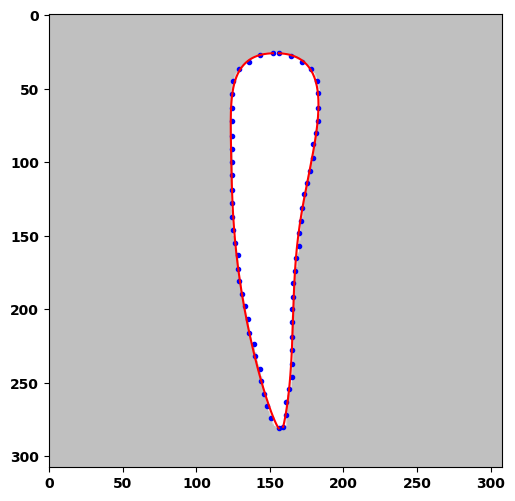

In [33]:
%%time
checkToD(3,N=5,err_th=0.5)

.E

.
CP 5.0, steps:0, etime: 1.14062 err: 0.7439031206
.
CP 2.0, steps:1, etime: 1.37500 err: 0.6055781395
.
CP 1.0, steps:2, etime: 1.56250 err: 0.5440211985
.E

Wall time: 3.11 s


((0.43359603243850586, 0.4580456376121378),
 3.078125,
 (1, 4),
 ([[152.0, 26.0],
   [84.90942978751178, 25.619299414997982],
   [172.25564538417336, 129.72372242975462],
   [70.2714259124052, 139.0400882198579],
   [164.5107165081609, 205.32882160597777],
   [127.57038897352413, 238.55539767314053],
   [156.0, 281.0]],
  [[156.0, 26.0],
   [213.9427625950866, 28.58921201540536],
   [169.28420072354012, 116.52064778113218],
   [165.1314931107896, 139.29834092577238],
   [163.82692564180388, 172.84098841189473],
   [169.2633695566849, 241.579223916651],
   [159.0, 280.0]]))

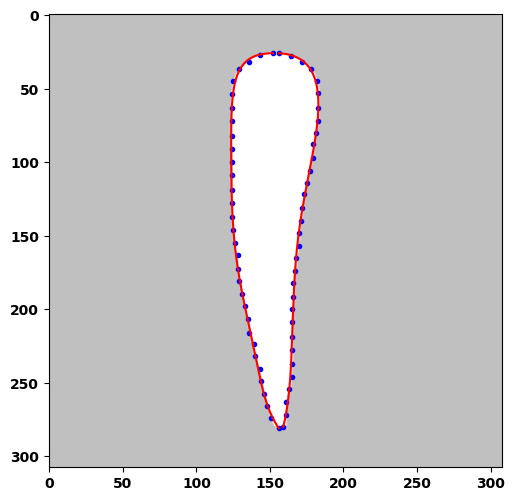

In [34]:
%%time
checkToD(3,N=6,err_th=0.5)

..................................
CP 5.0, steps:33, etime: 3.85938 err: 4.7015100185
.........
CP 2.0, steps:42, etime: 4.76562 err: 1.8048171052
......
CP 1.0, steps:48, etime: 5.35938 err: 0.9722251062
......
CP 0.65, steps:54, etime: 5.95312 err: 0.6398425412
.........E

................................................
CP 5.0, steps:47, etime: 5.26562 err: 4.9850054289
....................................................
..................................................C

Wall time: 22.9 s


((0.49446354662408787, 2.500070078832139),
 22.890625,
 (64, 150),
 ([[153.0, 27.0],
   [9.954663164103613, -1.0003598387318915],
   [106.0372820648245, 328.67442954700044],
   [151.59653919199087, 31.22748423810582],
   [150.0, 280.0]],
  [[157.0, 27.0],
   [307.254036794831, 5.485648961513247],
   [175.6311045596604, 360.417604192277],
   [184.41855689292566, -0.3461046342499875],
   [153.0, 281.0]]))

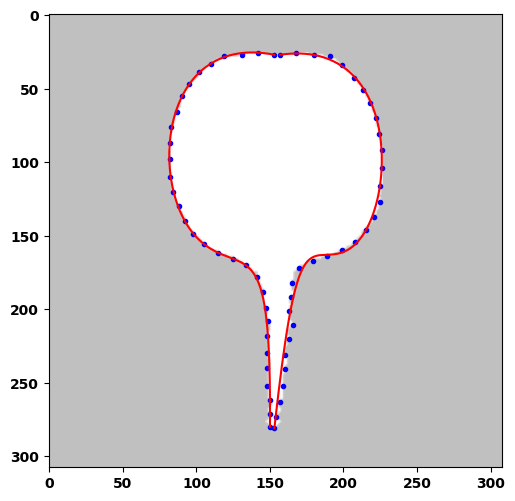

In [35]:
%%time
checkToD(4,N=4,err_th=0.5)

...................
CP 5.0, steps:18, etime: 3.65625 err: 4.9754369687
.........................
CP 2.0, steps:43, etime: 7.42188 err: 1.9489555814
..................
CP 1.0, steps:61, etime: 10.14062 err: 0.9839042445
..............
CP 0.65, steps:75, etime: 12.23438 err: 0.6341878952
...........E

...........................
CP 5.0, steps:26, etime: 4.81250 err: 4.9460672243
......................
CP 2.0, steps:48, etime: 8.10938 err: 1.9202000350
.....................
CP 1.0, steps:69, etime: 11.23438 err: 0.9915861772
..............................
....................................................................................................
....................................................................................................
....................................................................................................
..^^^..^....................................^^^..^..^...............................^^^^..^.........
.......................^^^^.^.^^...^.

((0.4929888274876747, 0.7102464961326721),
 113.34375,
 (87, 651),
 ([[153.0, 27.0],
   [44.31379797848537, -2.527937144473469],
   [41.68769964788437, 232.21717060222053],
   [168.37509373447412, 175.92568621903357],
   [142.9548149600813, 111.93525085484517],
   [150.0, 280.0]],
  [[157.0, 27.0],
   [273.63869793351006, -6.434935345951341],
   [259.44049475575184, 315.3083729707919],
   [112.51848872323632, 101.9161848955079],
   [187.5200077458218, 140.74057239141536],
   [153.0, 281.0]]))

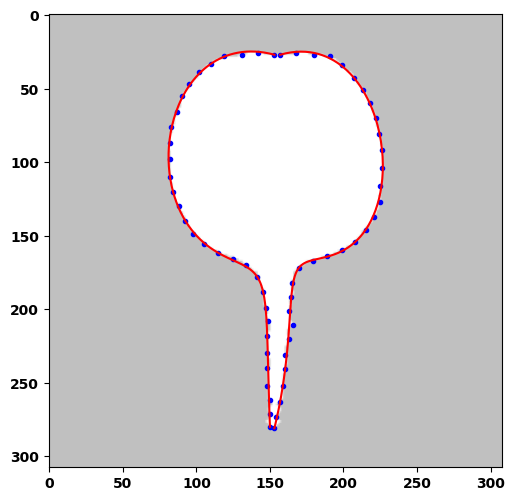

In [36]:
%%time
checkToD(4,N=5,err_th=0.5)

..
CP 5.0, steps:1, etime: 1.46875 err: 4.6386782048
.......
CP 2.0, steps:8, etime: 2.93750 err: 1.9072973032
......
CP 1.0, steps:14, etime: 4.20312 err: 0.9050247659
....
CP 0.65, steps:18, etime: 5.03125 err: 0.6433732285
.....E

............
CP 5.0, steps:11, etime: 3.56250 err: 4.6273287476
.............
CP 2.0, steps:24, etime: 6.28125 err: 1.9427102534
...........................................................................
CP 1.0, steps:99, etime: 21.98438 err: 0.9985664363

....................................................................................................
....................................................................................................
.............................................................................................
CP 0.65, steps:392, etime: 83.53125 err: 0.6498776542
.......
....................................................................................................
.................................................

((0.4844625890170057, 0.5547875759178517),
 644.078125,
 (24, 3001),
 ([[153.0, 27.0],
   [109.179144893945, 26.81308124009868],
   [7.986052852131416, -28.86223363643974],
   [85.01690742526756, 456.8203815542476],
   [188.13529884236934, -80.60453334746911],
   [139.51197590263038, 283.3104197170636],
   [150.0, 280.0]],
  [[157.0, 27.0],
   [260.2834422998569, 8.803650560067279],
   [197.10388695651727, 145.16673598568312],
   [314.17147058907057, 178.3048171041584],
   [83.1583839631003, 197.95926063296452],
   [195.6916497607021, 95.43360057638814],
   [153.0, 281.0]]))

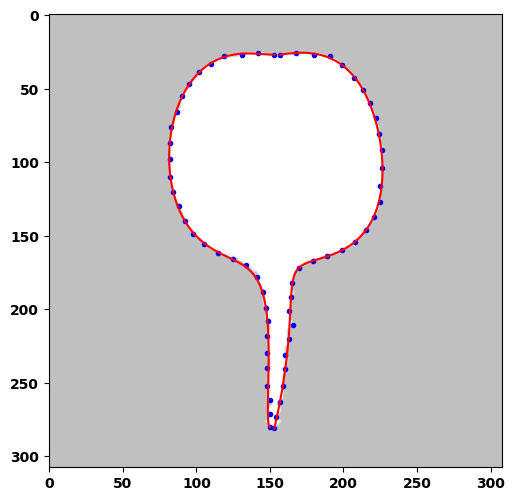

In [37]:
%%time
checkToD(4,N=6,err_th=0.5)

In [ ]:
checkToD(4,N=8,err_th=0.5)

.
CP 5.0, steps:0, etime: 2.18750 err: 1.2169937616
.
CP 2.0, steps:1, etime: 2.56250 err: 1.0851740876
.
CP 1.0, steps:2, etime: 2.92188 err: 0.9875582097
....
CP 0.65, steps:6, etime: 4.37500 err: 0.6030570666
...E

.
CP 5.0, steps:0, etime: 2.20312 err: 4.1041149640
.....
CP 2.0, steps:5, etime: 4.15625 err: 1.9632507191
.......
CP 1.0, steps:12, etime: 6.71875 err: 0.9595610040
...............
CP 0.65, steps:27, etime: 12.20312 err: 0.6466695716
.............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^........................................................................................
....................................................................................................
.....................................................................

.
CP 5.0, steps:0, etime: 1.76562 err: 4.3144876166
....
CP 2.0, steps:4, etime: 2.87500 err: 1.9825481100
.......
CP 1.0, steps:11, etime: 4.84375 err: 0.9706631637
...........
CP 0.65, steps:22, etime: 8.03125 err: 0.6338452104
.........E

..
CP 5.0, steps:1, etime: 1.98438 err: 4.8538959318
......
CP 2.0, steps:7, etime: 3.67188 err: 1.8606904208
...........
CP 1.0, steps:18, etime: 6.76562 err: 0.9974217997
......................
CP 0.65, steps:40, etime: 12.93750 err: 0.6479724086
...........................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................

((0.49529878024587354, 0.5351929741628454),
 865.453125,
 (32, 3001),
 ([[153.0, 27.0],
   [91.79411149621073, 34.11865769726255],
   [119.20247513383775, -45.87017349767156],
   [-89.63536558629447, 303.09774135492336],
   [267.34866231188187, 166.76755017342623],
   [116.38820180472923, 78.1279682750516],
   [151.74643633897716, 265.61467778052435],
   [150.0, 280.0]],
  [[157.0, 27.0],
   [211.88655985970578, 26.1061204163813],
   [230.48082427492903, -26.67389620267643],
   [346.88197663087016, 407.1321564670776],
   [37.5157875288076, 36.35489255142046],
   [206.0035945572075, 167.49849104941705],
   [163.17612836575816, 210.89275606302778],
   [153.0, 281.0]]))

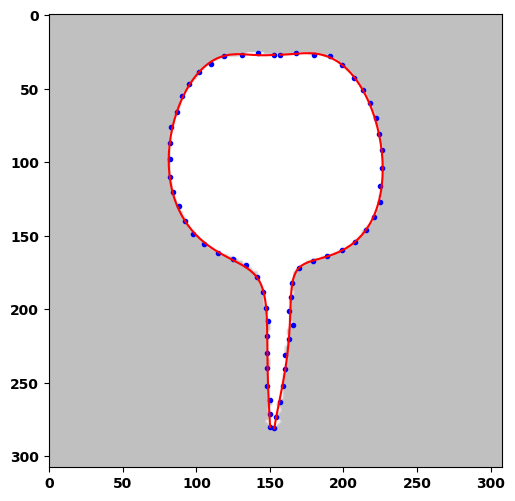

In [4]:
checkToD(4,N=7,err_th=0.5)

In [ ]:
checkToD(5,N=8,err_th=0.5)

.
CP 5.0, steps:0, etime: 2.28125 err: 1.2169937616
.
CP 2.0, steps:1, etime: 2.64062 err: 1.0851740876
.
CP 1.0, steps:2, etime: 3.00000 err: 0.9875582097
....
CP 0.65, steps:6, etime: 4.43750 err: 0.6030570666
...E

.
CP 5.0, steps:0, etime: 2.29688 err: 4.1041149640
.....
CP 2.0, steps:5, etime: 4.14062 err: 1.9632507191
.......
CP 1.0, steps:12, etime: 6.70312 err: 0.9595610040
...............
CP 0.65, steps:27, etime: 12.17188 err: 0.6466695716
.............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^........................................................................................
....................................................................................................
.....................................................................

..............................
CP 5.0, steps:29, etime: 3.73438 err: 4.9450927479
......................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................

((2.293532874632524, 1.3910604351399845),
 234.953125,
 (1234, 974),
 ([[152.0, 27.0],
   [41.811936653299426, -1.2791465848628116],
   [136.40005179788656, 384.07212893771595],
   [100.38167496082751, 158.3205932702775],
   [152.0, 280.0]],
  [[156.0, 27.0],
   [264.7171746431591, -9.691182502147704],
   [164.00572918036002, 408.63860135381714],
   [202.60329216355666, 169.3214301112088],
   [154.0, 280.0]]))

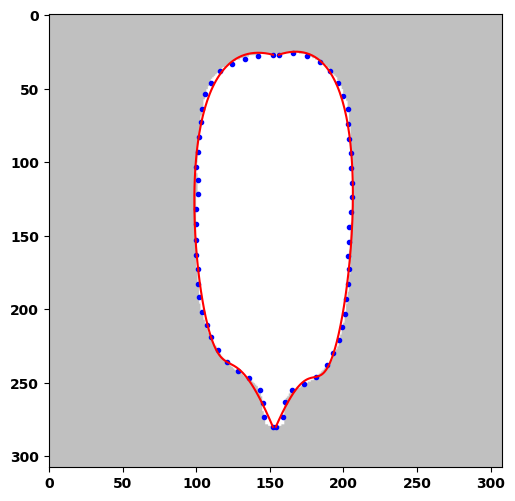

In [38]:
%%time
checkToD(5,N=4,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.90625 err: 3.9444518864
....
CP 2.0, steps:4, etime: 1.53125 err: 1.7133291329
......
CP 1.0, steps:10, etime: 2.71875 err: 0.9926048114
.........................................................................................
....................................................................................................
....................................................................................................
...................................................................C

..
CP 5.0, steps:1, etime: 1.09375 err: 4.8593425593
............
CP 2.0, steps:13, etime: 2.93750 err: 1.9810414099
...........................................
CP 1.0, steps:56, etime: 9.92188 err: 0.9933722455
...........................................
....................................................................................................
...................................................................................................
CP 0.65, steps:2

((0.7197131566311554, 0.5902283971168494),
 515.75,
 (367, 3001),
 ([[152.0, 27.0],
   [67.9534262170475, 38.556629379184756],
   [128.29789603245086, 32.415245175907714],
   [68.0478467582257, 329.47116320714804],
   [119.50256038232251, 176.96308328636994],
   [152.0, 280.0]],
  [[156.0, 27.0],
   [230.4465720750063, 25.507970312712757],
   [196.75293087437, 54.18912562540496],
   [216.89415163992018, 363.44638628175136],
   [182.8072346445696, 186.54141078123854],
   [154.0, 280.0]]))

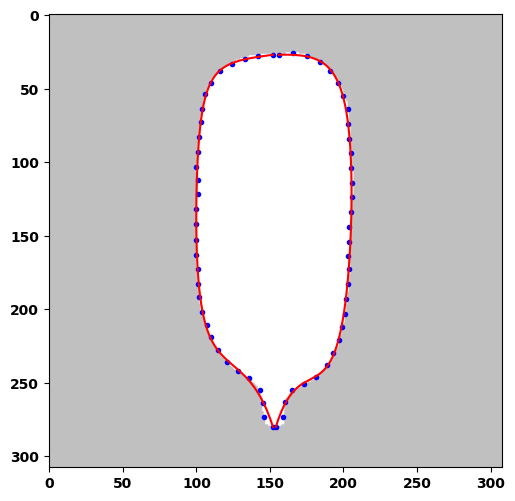

In [39]:
%%time
checkToD(5,N=5,err_th=0.5)

.
CP 5.0, steps:0, etime: 1.28125 err: 1.8399861575
.
CP 2.0, steps:1, etime: 1.50000 err: 1.5996334221
.........
CP 1.0, steps:10, etime: 3.42188 err: 0.9737361674
......................................
CP 0.65, steps:48, etime: 11.59375 err: 0.6497857703
...................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................^.^.^.^.^..^^^^..^..^^..^..^.........
..................^.^^^^.^^^^..^^.^......^^.^^..^.^..^.^^^.^^^^^.^.^^..^^.^^..^..^..^............^^^
^.^^.^..^^.^^^^^^.^^^.^^^.^^^^.^^^.^^^.^^.^^^^^...^^.^..^^.^^^^.^^^^.^.^^^^^^^..^^^^^

((0.6132190034387527, 0.4996513267402855),
 652.9375,
 (3001, 49),
 ([[152.0, 27.0],
   [51.359382474921674, 33.71581455766366],
   [157.6498218150122, 112.07086043159553],
   [50.9898689732259, 66.97081630751482],
   [113.07195984411017, 346.6288403924027],
   [115.66613556969419, 174.54084918126557],
   [152.0, 280.0]],
  [[156.0, 27.0],
   [230.22565629528134, 12.268987144427177],
   [200.28841969148667, 157.43766542851768],
   [194.36725159936057, -2.5397082508598703],
   [227.96534521584869, 372.3913258931211],
   [182.2808357831994, 184.641911967351],
   [154.0, 280.0]]))

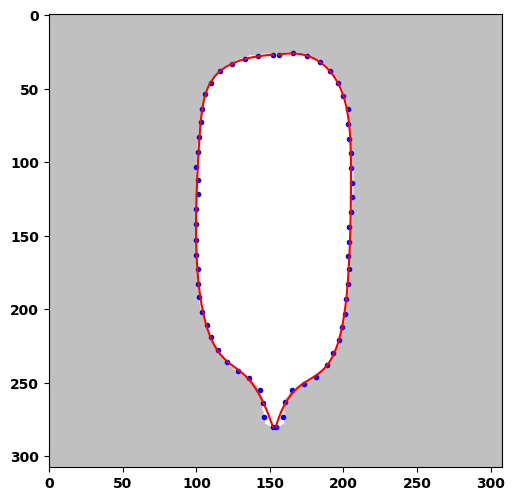

In [40]:
%%time
checkToD(5,N=6,err_th=0.5)

.
CP 5.0, steps:0, etime: 1.71875 err: 1.5304759204
.
CP 2.0, steps:1, etime: 2.00000 err: 1.4059141160
.......
CP 1.0, steps:8, etime: 3.96875 err: 0.9906053875
...........
CP 0.65, steps:19, etime: 7.06250 err: 0.6411115453
...........................................E

.
CP 5.0, steps:0, etime: 1.73438 err: 1.2786149803
.
CP 2.0, steps:1, etime: 2.01562 err: 1.1588663615
..
CP 1.0, steps:3, etime: 2.57812 err: 0.9464348189
.....
CP 0.65, steps:8, etime: 4.00000 err: 0.6425384496
......E

Wall time: 25.1 s


((0.4999762012595662, 0.4950852699284258),
 25.03125,
 (63, 15),
 ([[152.0, 27.0],
   [112.16895638637172, 31.34440471299992],
   [28.440193935976808, 28.75762190658195],
   [222.45854892436165, 228.80213523723458],
   [-24.98415714618035, 12.524125408255033],
   [162.6794339802617, 391.05007232080203],
   [108.36294151746705, 165.38820817120143],
   [152.0, 280.0]],
  [[156.0, 27.0],
   [198.5414577911589, 21.43872811676117],
   [248.7482192995035, 38.121940713049845],
   [158.14377724632465, 255.8365363577684],
   [226.7564596289946, -12.31932165332409],
   [215.5837841454428, 378.87703703325604],
   [177.3377591148665, 188.6290347645372],
   [154.0, 280.0]]))

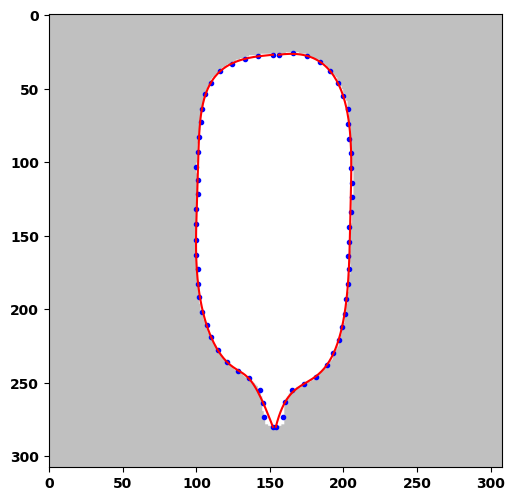

In [41]:
%%time
checkToD(5,N=7,err_th=0.5)

.
CP 5.0, steps:0, etime: 2.45312 err: 1.1426982113
.
CP 2.0, steps:1, etime: 2.81250 err: 1.0698930593
.
CP 1.0, steps:2, etime: 3.17188 err: 0.9730098405
.........
CP 0.65, steps:11, etime: 6.45312 err: 0.6394044306
..........E

.
CP 5.0, steps:0, etime: 2.17188 err: 1.3711734844
.
CP 2.0, steps:1, etime: 2.54688 err: 1.2131234124
...
CP 1.0, steps:4, etime: 3.62500 err: 0.9584825297
.......
CP 0.65, steps:11, etime: 6.15625 err: 0.6288086036
......E

Wall time: 18.6 s


((0.4932819043278695, 0.49494167999060384),
 18.625,
 (22, 18),
 ([[152.0, 27.0],
   [106.67733987294355, 40.555377826153645],
   [99.9737856288617, -34.744173285046585],
   [35.32937620200668, 329.142327723191],
   [248.58975656932222, -119.11099892402233],
   [-69.00731838850075, 338.5723976136371],
   [186.9983664113297, 228.51064779565573],
   [122.19551718214022, 225.168882754588],
   [152.0, 280.0]],
  [[156.0, 27.0],
   [196.2736381282125, 24.411890811173613],
   [214.23348571726427, 18.967065436728507],
   [241.71228165407558, 196.11014971549614],
   [128.2960453965322, 105.33810028531826],
   [274.0603897921279, 130.11511980749714],
   [182.9717193610966, 338.82082846837307],
   [177.44148264105723, 199.01521645997778],
   [154.0, 280.0]]))

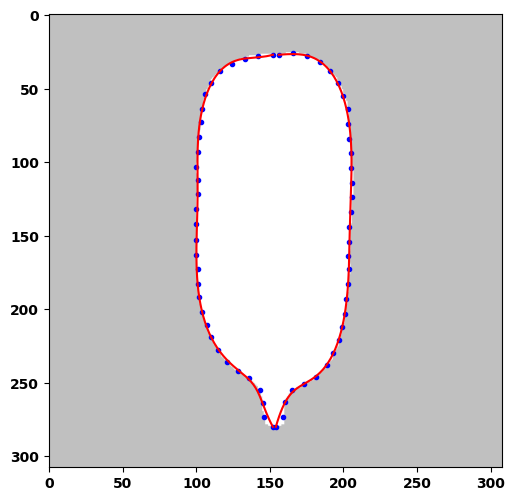

In [42]:
%%time
checkToD(5,N=8,err_th=0.5)

....................................................................................................
............................................................................................e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.
e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.
e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.

((10.759120348955518, 3.7403362521514842),
 110.78125,
 (846, 224),
 ([[151.0, 26.0],
   [154.05961126072435, -161.5975418050269],
   [-13.209571658503984, 493.3834714995032],
   [139.63040637393965, 150.69603111982056],
   [140.0, 279.0]],
  [[155.0, 26.0],
   [234.87272393612113, -12.593838792499161],
   [238.28367975980942, 420.9277565717873],
   [220.8883270994696, 164.12046231303955],
   [143.0, 280.0]]))

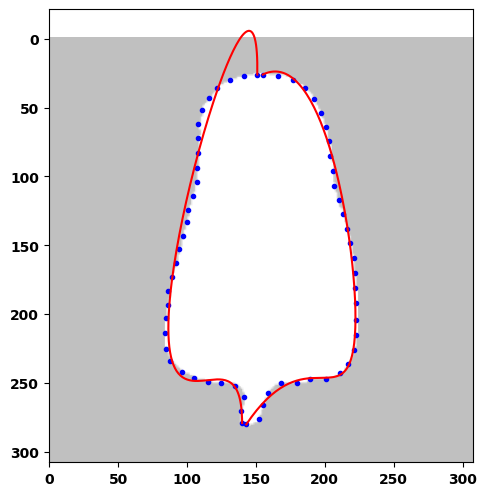

In [43]:
%%time
checkToD(6,N=4,err_th=0.5)

..........
CP 5.0, steps:9, etime: 2.26562 err: 4.8525716855
............
CP 2.0, steps:21, etime: 4.06250 err: 1.9626456557
..............................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................C

.........
CP 5.0, steps:8, etime: 2.10938 err: 4.9460369164
...........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........

((1.0998578658590668, 2.4173718234644643),
 146.625,
 (424, 529),
 ([[151.0, 26.0],
   [33.712583490570076, 51.92324442368136],
   [246.87103731442042, 44.4330648226481],
   [-92.42239143197335, 376.8959306919682],
   [168.4042470205056, 183.77663719060388],
   [140.0, 279.0]],
  [[155.0, 26.0],
   [222.54626073580306, 33.98278216972726],
   [169.68725613672967, 10.014992952377966],
   [293.8976065152084, 412.35343255789684],
   [203.70410175256674, 168.01258943478993],
   [143.0, 280.0]]))

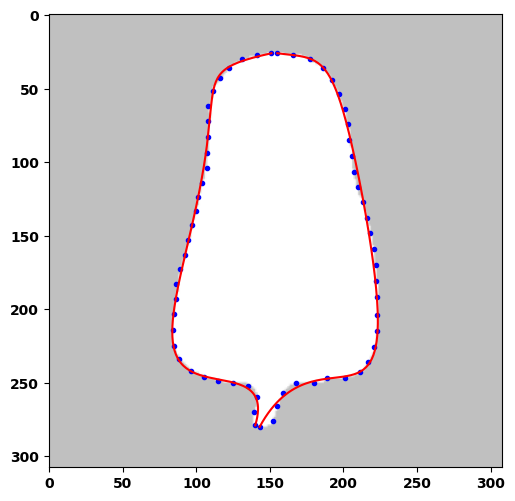

In [44]:
%%time
checkToD(6,N=5,err_th=0.5)

.
CP 5.0, steps:0, etime: 1.32812 err: 3.6678168690
....
CP 2.0, steps:4, etime: 2.18750 err: 1.6869097253
....
CP 1.0, steps:8, etime: 3.07812 err: 0.8540463499
...
CP 0.65, steps:11, etime: 3.75000 err: 0.6093757942
...E

......
CP 5.0, steps:5, etime: 2.39062 err: 4.6517107076
.............
CP 2.0, steps:18, etime: 5.23438 err: 1.9803311502
.................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................

((0.4883280793518234, 1.4710833719896985),
 170.09375,
 (15, 745),
 ([[151.0, 26.0],
   [62.97803266950952, 21.789902310847527],
   [127.37214122250374, 195.55196148472388],
   [164.31250996797056, -44.64511325505906],
   [-55.5542311671446, 431.7186197063016],
   [160.24827791284446, 169.02346402459037],
   [140.0, 279.0]],
  [[155.0, 26.0],
   [272.66227315083023, 24.641631978332526],
   [110.16986475121622, 263.78086410233436],
   [307.1672335291121, -104.62156122161986],
   [202.62244562027354, 488.4017493198464],
   [230.146267675838, 146.42562935848056],
   [143.0, 280.0]]))

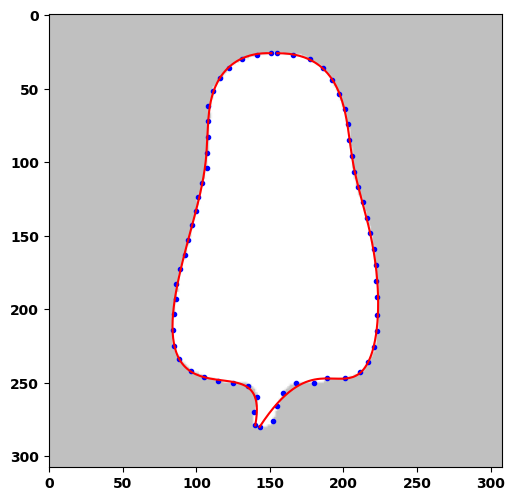

In [45]:
%%time
checkToD(6,N=6,err_th=0.5)

.
CP 5.0, steps:0, etime: 2.00000 err: 2.4657221680
.
CP 2.0, steps:1, etime: 2.28125 err: 1.9664767743
....
CP 1.0, steps:5, etime: 3.40625 err: 0.9563063865
...
CP 0.65, steps:8, etime: 4.23438 err: 0.6256919466
..........E

...
CP 5.0, steps:2, etime: 2.29688 err: 4.8466135863
..........
CP 2.0, steps:12, etime: 5.14062 err: 1.8546483752
...............................................................
CP 1.0, steps:75, etime: 22.85938 err: 0.9982758631
........................
......
CP 0.65, steps:105, etime: 31.31250 err: 0.6426591706
..............................................................................................
.........................................................................................E

Wall time: 1min 30s


((0.49810126199710186, 0.4998775491875501),
 90.40625,
 (19, 289),
 ([[151.0, 26.0],
   [88.51767376159223, 29.50047809924938],
   [85.23136982434303, 75.08994912735018],
   [173.1941067992047, 205.0759704470062],
   [51.077602237725046, 15.607403391112065],
   [17.642896451889538, 426.7731872697095],
   [152.3856568049842, 167.70295237786578],
   [140.0, 279.0]],
  [[155.0, 26.0],
   [245.14170095397046, 10.293984047613447],
   [222.0519871162448, 327.7164901116128],
   [36.573771889516, -437.6645297425134],
   [508.65974900253957, 796.1788436285198],
   [63.305502204083545, 23.02253056413469],
   [189.35466651847622, 281.59049534781764],
   [143.0, 280.0]]))

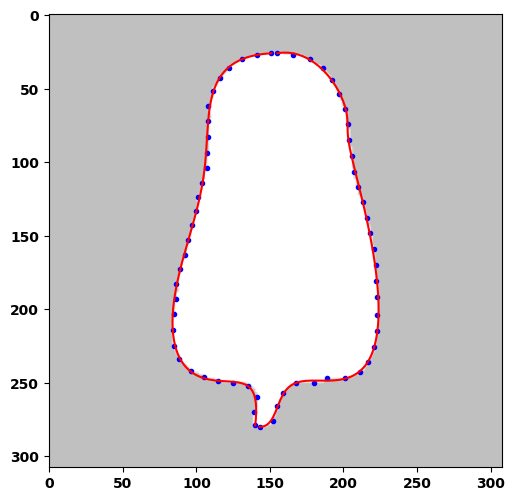

In [52]:
%%time
checkToD(6,N=7,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.64062 err: 3.8194976778
......
CP 2.0, steps:6, etime: 1.28125 err: 1.8834762722
................................................C

.
CP 5.0, steps:0, etime: 0.90625 err: 2.9733586013
......
CP 2.0, steps:6, etime: 1.56250 err: 1.8495187058
................................................
CP 1.0, steps:54, etime: 6.68750 err: 0.9987280273
.............................................
....................................................................................................
..........................................
CP 0.65, steps:241, etime: 26.53125 err: 0.6492750933
..........................................................
....................................................E

Wall time: 44.7 s


((1.1515676342913357, 0.4996343423544741),
 44.765625,
 (55, 352),
 ([[156.0, 26.0],
   [115.4391526352242, 21.9317670246073],
   [106.57275295594852, 223.804598615714],
   [106.81320182485868, 198.63412309480387],
   [163.0, 281.0]],
  [[160.0, 26.0],
   [194.86094301060274, 14.472108189417948],
   [208.55618220131907, 272.99730705547256],
   [177.67219345380192, 206.45005365728667],
   [166.0, 280.0]]))

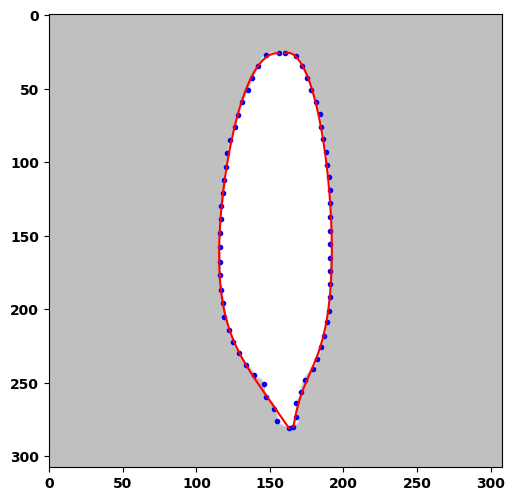

In [46]:
%%time
checkToD(7,N=4,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.96875 err: 2.3059502386
.
CP 2.0, steps:1, etime: 1.12500 err: 1.8850818540
..................................................................................................
...................................................................
CP 1.0, steps:166, etime: 27.00000 err: 0.9998325815
.................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.....^.^^^.^^..^....................

((0.9547038516541954, 0.49972446746634835),
 158.734375,
 (891, 103),
 ([[156.0, 26.0],
   [130.65042907966895, 15.928047335611025],
   [84.5385675391065, 163.62212442525302],
   [143.26459592282302, 231.66850935789188],
   [90.97064863311923, 180.10104051641235],
   [163.0, 281.0]],
  [[160.0, 26.0],
   [189.00185313936362, 32.01110099740634],
   [190.10909263534506, 93.76258773224207],
   [207.78953650980299, 269.94586880652633],
   [177.99827624033068, 202.52867983677893],
   [166.0, 280.0]]))

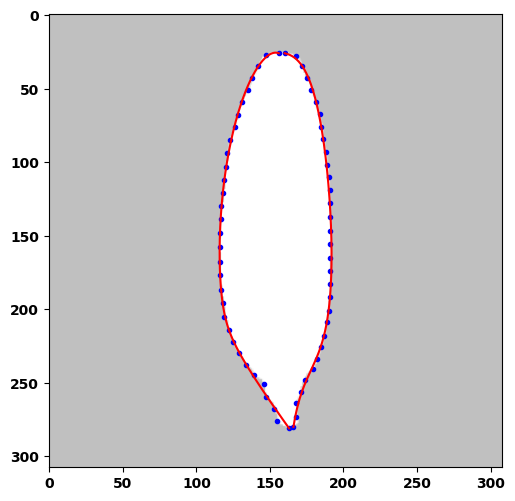

In [47]:
%%time
checkToD(7,N=5,err_th=0.5)

.
CP 5.0, steps:0, etime: 1.35938 err: 1.7386100451
.
CP 2.0, steps:1, etime: 1.57812 err: 1.7187077618
..................................................................................................
....................................................................................................
..................................................
CP 1.0, steps:249, etime: 56.18750 err: 0.9998841772
..................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................^^..^^.^^...........................
.........................^.^..^..^.^^.^^.^..^.^^^.^^^.^..C

.
CP 5.0, steps:0, etime: 1.28125 err: 0.7154381707
.
CP 2.0, steps:1, etime:

((0.9592020040967977, 0.4841743369602641),
 165.734375,
 (757, 4),
 ([[156.0, 26.0],
   [133.77725201877857, 17.739435277483246],
   [100.07597572671665, 118.53984286106716],
   [113.47897429717031, 200.8443008471487],
   [125.8062725897149, 215.59806922841156],
   [105.07709367134409, 199.73182677560746],
   [163.0, 281.0]],
  [[160.0, 26.0],
   [188.63322901663895, 27.32555998003989],
   [202.334925406025, 153.7422165113955],
   [167.45927216194406, 82.34810138817232],
   [228.10189746500066, 255.23146323937647],
   [165.45641510473286, 224.9138479659997],
   [166.0, 280.0]]))

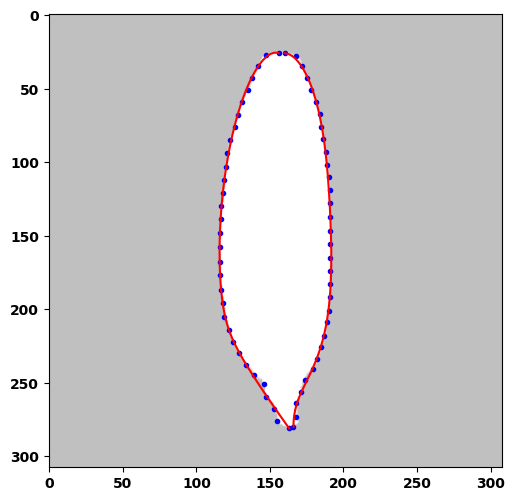

In [48]:
%%time
checkToD(7,N=6,err_th=0.5)

Left
.
CP 5.0, steps:0, etime: 1.57812 err: 1.2163212066
.
CP 2.0, steps:1, etime: 1.85938 err: 1.0409825542
.
CP 1.0, steps:2, etime: 2.15625 err: 0.9118063843
...
CP 0.65, steps:5, etime: 3.01562 err: 0.6253308625
........................E

Right
.E



((0.49879452001041924, 0.43316016043761757),
 11.5625,
 (30, 1),
 ([[156.0, 26.0],
   [123.48660493891553, 7.525364681787106],
   [106.67324472241083, 255.3132905831244],
   [144.94107176574633, -177.22864219725088],
   [80.74703793798344, 458.01055747494155],
   [122.8244969633095, 96.97401975671237],
   [137.11168790706023, 271.5629146283014],
   [163.0, 281.0]],
  [[160.0, 26.0],
   [187.96316483208736, 23.912982401251124],
   [183.37868310916875, 135.31927416450046],
   [210.72313596993683, 60.845174402567736],
   [162.9975990328833, 225.85906235586273],
   [228.6050964170367, 200.36874245958938],
   [160.9216788172697, 245.592504035802],
   [166.0, 280.0]]))

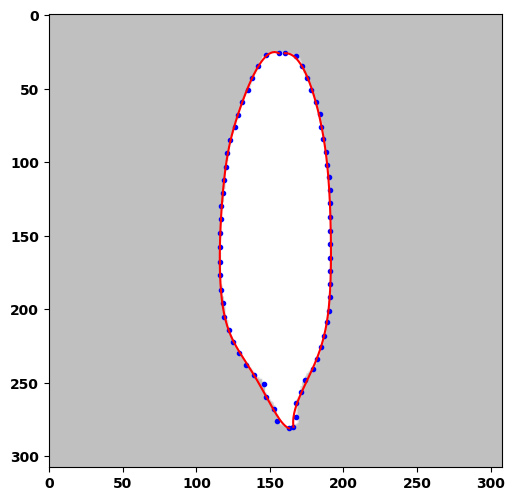

In [7]:
checkToD(7,N=7,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.59375 err: 3.5311107508
....
CP 2.0, steps:4, etime: 1.00000 err: 1.8381272561
....
CP 1.0, steps:8, etime: 1.39062 err: 0.9304193354
...
CP 0.65, steps:11, etime: 1.70312 err: 0.5699538445
.E

........
CP 5.0, steps:7, etime: 1.29688 err: 4.7847875192
............................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................

((0.49827044889044575, 2.0694330930420906),
 137.640625,
 (13, 1321),
 ([[159.0, 26.0],
   [101.95500072423918, 19.130584525502584],
   [134.261488718735, 224.87176903352517],
   [127.05399331060305, 187.7009344775463],
   [161.0, 281.0]],
  [[162.0, 27.0],
   [205.40197577293392, -4.760732825639714],
   [162.19387293618888, 335.0405020169606],
   [159.92329140490574, 172.4542411100469],
   [164.0, 280.0]]))

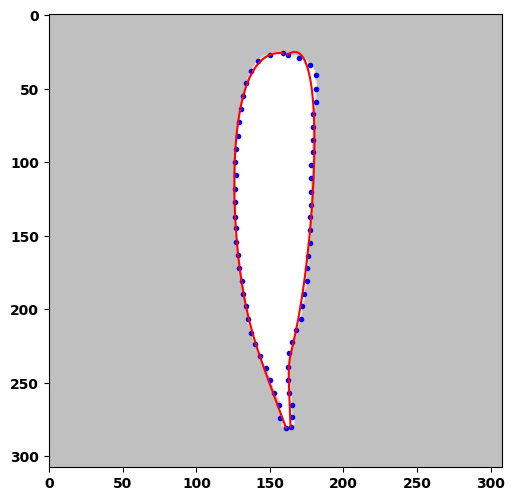

In [49]:
%%time
checkToD(8,N=4,err_th=0.5)

.
CP 5.0, steps:0, etime: 0.92188 err: 0.7415600764
.
CP 2.0, steps:1, etime: 1.06250 err: 0.5669263553
.
CP 1.0, steps:2, etime: 1.21875 err: 0.5433158593
.
CP 0.65, steps:3, etime: 1.37500 err: 0.5006981858
.E

.
CP 5.0, steps:0, etime: 0.89062 err: 2.5917305613
.....
CP 2.0, steps:5, etime: 1.65625 err: 1.9306142865
...........................
CP 1.0, steps:32, etime: 5.76562 err: 0.9931735552
.............................
CP 0.65, steps:61, etime: 10.14062 err: 0.6452354853
......................................
..............................E

Wall time: 22.1 s


((0.4323723716917827, 0.4991129901222361),
 22.0625,
 (5, 130),
 ([[159.0, 26.0],
   [97.7109560198162, 25.03766121248838],
   [154.25273840599317, 170.83339475056908],
   [96.80343635548641, 147.8022176375315],
   [149.61655503927958, 239.6960591648168],
   [161.0, 281.0]],
  [[162.0, 27.0],
   [213.10065792230185, 34.155826815078534],
   [139.59888063494628, 68.18645838308711],
   [209.17731498723856, 314.28194342829954],
   [151.7810122859956, 134.40679453746537],
   [164.0, 280.0]]))

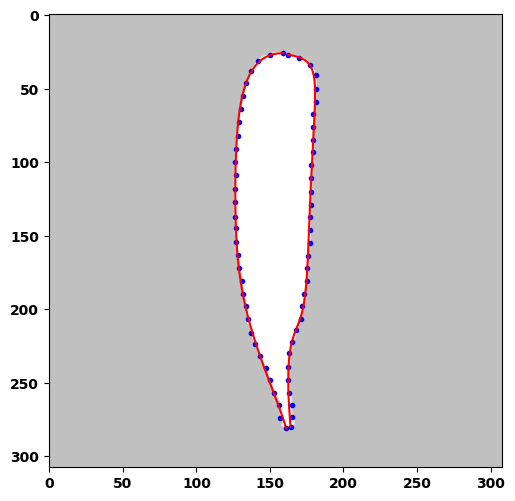

In [50]:
%%time
checkToD(8,N=5,err_th=0.5)

Right
.
CP 5.0, steps:0, etime: 3.23438 err: 1.5718157826
.
CP 2.0, steps:1, etime: 3.79688 err: 1.3185747232
...
CP 1.0, steps:4, etime: 5.48438 err: 0.9907674717
...............
CP 0.65, steps:19, etime: 14.03125 err: 0.6468492724
................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................^...^..^^^..^^^^..........................................................
........................................................^^^^^..............^^...^^....^....^^.^..^^.
^^.^^^.^^^..^^^^^.^^^^^.^^.^^^^..^..............................................

((0, 0.5195263070924786),
 1710.921875,
 (1, 3001),
 ([],
  [[157.0, 27.0],
   [181.85283899551317, 24.158997209569037],
   [167.4222971201351, 38.332268311111285],
   [405.55777648833106, -98.05536879070654],
   [-25.963015402378204, 556.4337834583571],
   [587.7756810265744, -268.8066761242717],
   [-174.5651575470364, 586.0399449711718],
   [301.7870919800615, -144.7979637129586],
   [146.4593121947795, 285.64900919334985],
   [156.91654889121986, 256.8736451583328],
   [153.0, 281.0]]))

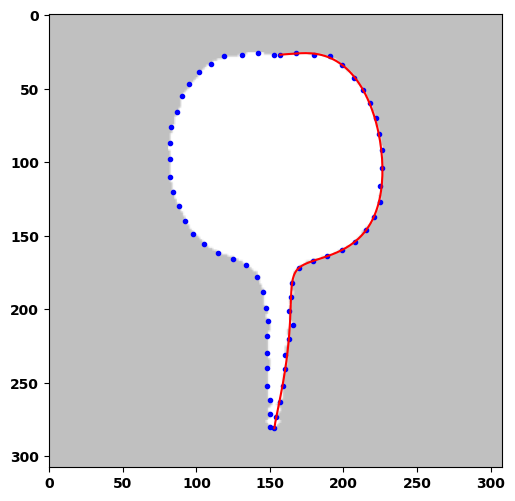

In [17]:
%%time
checkToD(4,LR=2,N=10,err_th=0.5)

Right
.
CP 5.0, steps:0, etime: 3.45312 err: 1.2808578605
.
CP 2.0, steps:1, etime: 4.12500 err: 1.1481544018
..
CP 1.0, steps:3, etime: 5.67188 err: 0.9290544465
.....
CP 0.65, steps:8, etime: 9.06250 err: 0.6411546148
..............................................................E

Wall time: 51.7 s


((0, 0.499668909018885),
 51.65625,
 (1, 71),
 ([],
  [[157.0, 27.0],
   [194.83778294741012, 34.47245856680536],
   [217.2827755745356, -96.85803745875104],
   [383.24232244098647, 628.7359459120147],
   [-307.8832637883235, -1138.5316908959267],
   [1201.9309063839903, 1730.2065895934845],
   [-704.9038619068203, -915.1152376737524],
   [572.8329667712754, 599.3655988645563],
   [49.265378980577474, 54.469932723090345],
   [186.3762605809505, 252.501368857541],
   [156.31752564663074, 250.25721591429513],
   [153.0, 281.0]]))

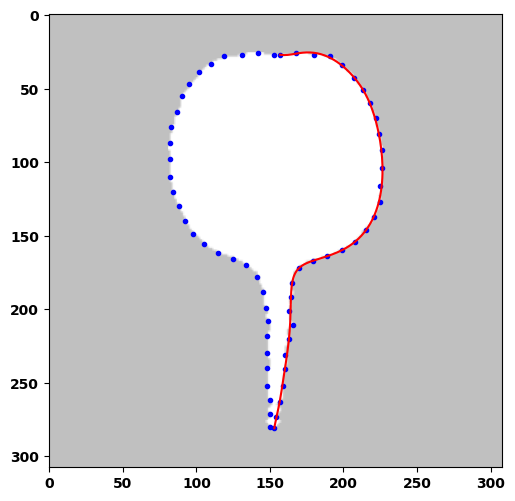

In [18]:
%%time
checkToD(4,LR=2,N=11,err_th=0.5)

Right
.
CP 5.0, steps:0, etime: 2.10938 err: 4.1041149640
.....
CP 2.0, steps:5, etime: 4.15625 err: 1.9632507191
.......
CP 1.0, steps:12, etime: 6.71875 err: 0.9595610040
...............
CP 0.65, steps:27, etime: 12.21875 err: 0.6466695716
.............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................

((0, 0.5404381005350566),
 1104.4375,
 (1, 3001),
 ([],
  [[157.0, 27.0],
   [197.99988578948353, 26.754032302360013],
   [235.88822975252543, -12.030517658681628],
   [267.571806177199, 203.86856714132517],
   [258.6924841558286, 251.3893370139091],
   [54.54603989095702, 90.9316355430513],
   [215.27889352115005, 150.47262837693114],
   [156.2789961476449, 238.86611976679586],
   [153.0, 281.0]]))

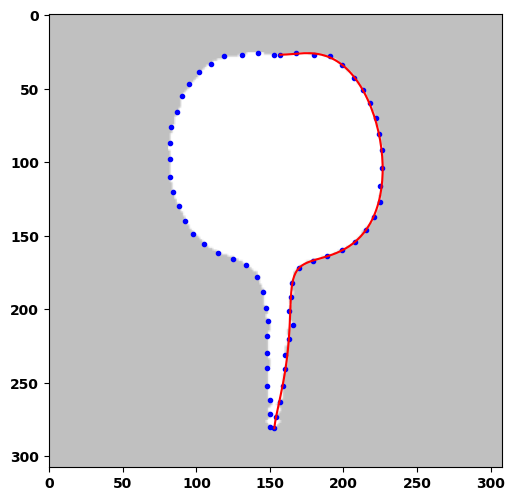

In [19]:
%%time
checkToD(4,N=8,LR=2,err_th=0.5,lr=0.001)

# 7次　err_th 1.0 

Left
.
CP 5.0, steps:0, etime: 1.68750 err: 1.1998948837
.
CP 2.0, steps:1, etime: 1.96875 err: 1.0102007052
.E

Right
.
CP 5.0, steps:0, etime: 1.75000 err: 1.0504657574
.E

TEST ./pics\Beztest.png
Wall time: 4.62 s


((0.9098056378705006, 0.6371690504052849),
 4.515625,
 (3, 2),
 ([[152.0, 27.0],
   [85.8004049654844, 31.89098375822191],
   [100.36948013635312, 60.85881842376201],
   [158.21482235921314, 225.25880984937618],
   [98.48795118886635, 68.78397845127758],
   [41.25790090274584, 282.6287024287265],
   [95.49824107817165, 266.47979417122315],
   [149.0, 279.0]],
  [[159.0, 26.0],
   [215.6436001065384, 26.919007533996567],
   [206.01548535902637, 95.73810520991246],
   [143.34130502293317, 191.38115470952204],
   [183.07351058968885, 96.26459244535766],
   [303.92636039802335, 292.3041148870559],
   [190.44834822866758, 261.52014618918395],
   [156.0, 281.0]]))

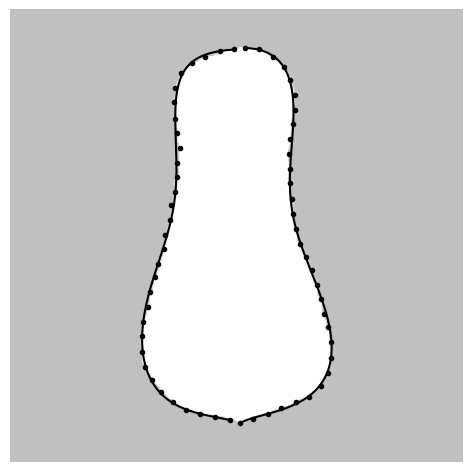

In [24]:
%%time
checkToD7(0,N=7,LR=0,err_th=1,lr=0.001)

Left
.
CP 5.0, steps:0, etime: 1.90625 err: 1.8717054153
.
CP 2.0, steps:1, etime: 2.18750 err: 1.4638693659
..E

Right
.
CP 5.0, steps:0, etime: 1.68750 err: 1.7470927523
.
CP 2.0, steps:1, etime: 1.96875 err: 1.3686890412
...E

TEST ./pics\Beztest.png
Wall time: 6.31 s


((0.9347018148002663, 0.9715960272206965),
 6.03125,
 (4, 5),
 ([[146.0, 27.0],
   [79.70965778451362, 39.04994437404342],
   [75.5920609379749, -39.7845821162225],
   [-15.697752524949397, 242.5986439661648],
   [82.43209853515171, 180.88735264589857],
   [220.2405009739459, 97.66210676350201],
   [125.95547414737516, 251.48621810322564],
   [147.0, 280.0]],
  [[153.0, 28.0],
   [214.52897686108037, 36.91594955933986],
   [222.3621663860685, -64.1949166808921],
   [348.44928863553, 271.9142999201703],
   [192.77965635614635, 106.92006834904133],
   [128.97631086954937, 157.02460664054604],
   [183.28283204701427, 240.96633675905622],
   [154.0, 280.0]]))

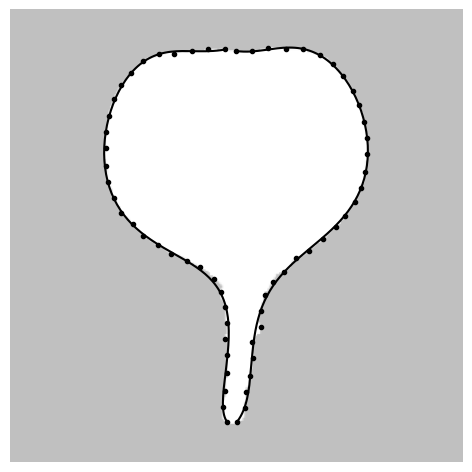

In [5]:
%%time
checkToD7(1,N=7,LR=0,err_th=1,lr=0.001)

Left
.E

Right
.E

TEST ./pics\Beztest.png
Wall time: 3.66 s


((0.3710800314857454, 0.7184684084579339),
 3.46875,
 (1, 1),
 ([[165.0, 26.0],
   [123.34608496536163, 32.87944592593569],
   [138.9305030553959, 125.45850718092083],
   [126.23466223610687, 91.76612206240551],
   [68.78622700696334, 201.9721475790905],
   [155.34713272408476, 204.33589431785066],
   [138.99205940546966, 246.37977825697968],
   [167.0, 281.0]],
  [[172.0, 27.0],
   [217.7082969714737, 34.643374485739265],
   [141.2378452545854, 134.25982639852697],
   [191.35219808609315, 72.00080373529002],
   [106.85015590353946, 186.5795211880618],
   [169.07222244028713, 213.91881599464145],
   [166.61331274219046, 230.3268394123145],
   [171.0, 277.0]]))

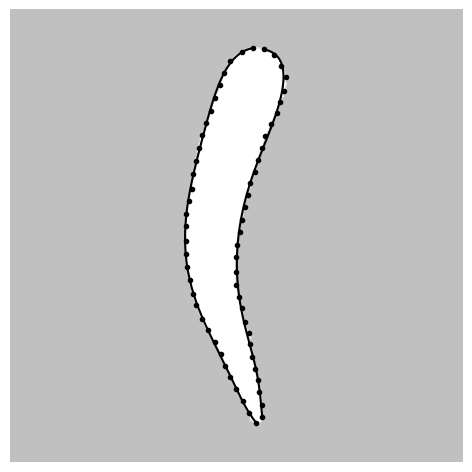

In [6]:
%%time
checkToD7(2,N=7,LR=0,err_th=1,lr=0.001)

Left
.E

Right
.E

TEST ./pics\Beztest.png
Wall time: 3.61 s


((0.2998914337117996, 0.7441197497215332),
 3.5,
 (1, 1),
 ([[150.0, 26.0],
   [100.09499144929484, 31.60149094435544],
   [132.81520208437612, 82.726822225133],
   [135.68541899146123, 167.4474369185478],
   [93.86959637300278, 135.3397475782098],
   [158.29041354759, 228.07501838563306],
   [132.8765778760715, 237.70863139038727],
   [154.0, 280.0]],
  [[158.0, 26.0],
   [198.1051299088978, 26.68041002900041],
   [197.26441711626646, 92.65849942351741],
   [145.24912259481508, 153.631453029716],
   [181.91580640946458, 109.56601847626432],
   [159.2905967703319, 227.46981534023226],
   [166.86280077872215, 231.34560479613333],
   [161.0, 279.0]]))

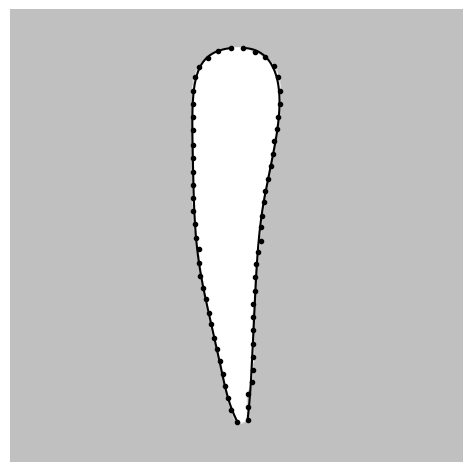

In [7]:
%%time
checkToD7(3,N=7,LR=0,err_th=1,lr=0.001)

Left
.
CP 5.0, steps:0, etime: 1.68750 err: 4.0714816142
....
CP 2.0, steps:4, etime: 2.79688 err: 1.9652164986
......E

Right
...
CP 5.0, steps:2, etime: 2.25000 err: 4.1510875797
......
CP 2.0, steps:8, etime: 3.98438 err: 1.9828220543
.............E

TEST ./pics\Beztest.png
Wall time: 12.5 s


((0.989116310500425, 0.9663702908886568),
 12.375,
 (11, 22),
 ([[151.0, 27.0],
   [71.02900781317376, 37.98012035030071],
   [167.06113085119236, -52.028425275006406],
   [-142.06957790604966, 313.0409967160309],
   [292.1824701417846, 135.24475026362438],
   [109.60499399621936, 102.00586161786237],
   [154.92148529076954, 270.35938979952346],
   [148.0, 279.0]],
  [[159.0, 27.0],
   [229.0974610226314, 36.69657434932951],
   [148.25656400891435, -69.25041819485392],
   [480.60296087843005, 420.51689680083774],
   [-68.42822570335728, 47.50503441349505],
   [258.37836442018016, 130.72044264422252],
   [144.25272704927266, 268.10373413666645],
   [154.0, 280.0]]))

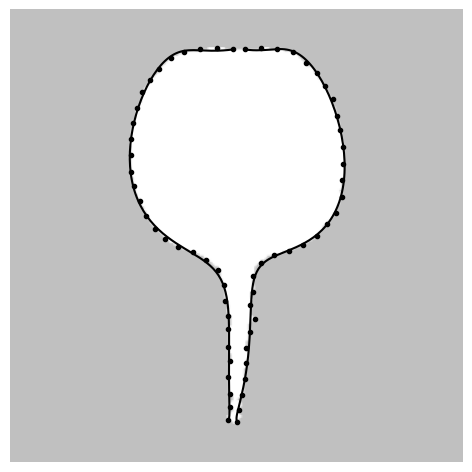

In [8]:
%%time
checkToD7(4,N=7,LR=0,err_th=1,lr=0.001)

Left
.E

Right
.E

TEST ./pics\Beztest.png
Wall time: 3.69 s


((0.9113386353574853, 0.9525875664787918),
 3.578125,
 (1, 1),
 ([[150.0, 27.0],
   [112.16047739575599, 22.958325907748993],
   [35.47414480310025, 68.4661745541828],
   [190.80548290949753, 157.26066602583106],
   [41.97789440283051, 115.09495015443743],
   [85.62798702371586, 272.0779017911519],
   [147.5066308830149, 222.70339105818883],
   [150.0, 279.0]],
  [[158.0, 27.0],
   [206.41891085298374, 20.428248960444392],
   [221.70825131390632, 64.15823366684883],
   [216.59687820399432, 182.26106892244897],
   [145.54778847195624, 95.75426533496676],
   [283.8656854259381, 278.74182603164513],
   [149.9036465583836, 225.41753964324718],
   [156.0, 279.0]]))

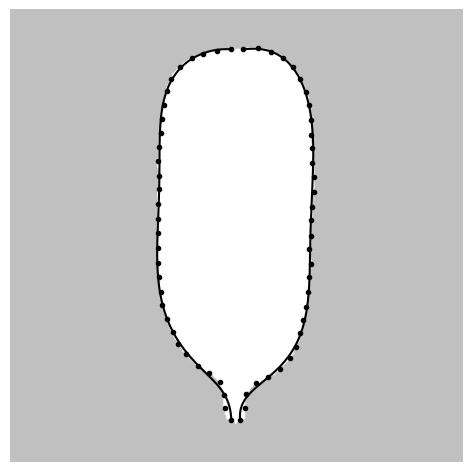

In [9]:
%%time
checkToD7(5,N=7,LR=0,err_th=1,lr=0.001)

Left
.
CP 5.0, steps:0, etime: 1.71875 err: 1.4150307359
.
CP 2.0, steps:1, etime: 2.01562 err: 1.0493444240
.E

Right
..
CP 5.0, steps:1, etime: 2.17188 err: 4.5722402881
.......
CP 2.0, steps:8, etime: 4.17188 err: 1.9781953984
...............E

TEST ./pics\Beztest.png
Wall time: 11.1 s


((0.94370217467285, 0.9965374817944901),
 11.0,
 (3, 24),
 ([[148.0, 26.0],
   [94.54563168331627, 34.0965650925596],
   [99.7719703225154, 36.01963813240929],
   [109.26252476962362, 307.8604383589817],
   [145.37773475441276, -79.42873347198733],
   [-55.26163202877228, 445.5016289461956],
   [179.8538445461571, 172.0529087106706],
   [138.0, 279.0]],
  [[157.0, 26.0],
   [225.45351815966387, 17.54238422988186],
   [237.4688649767064, 200.19915827000483],
   [72.945880416956, -82.9368561108529],
   [417.13731179727466, 341.504970220964],
   [134.58646944450308, 298.0736756139768],
   [205.7271642052468, 189.73671346588765],
   [144.0, 281.0]]))

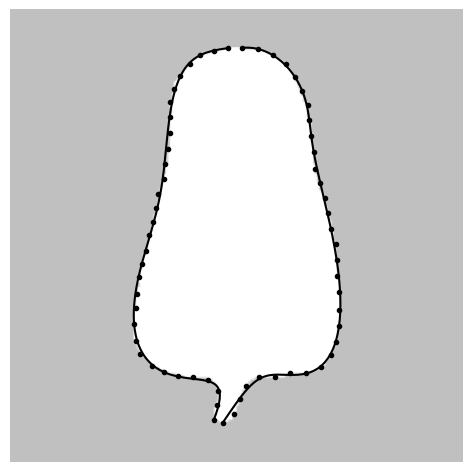

In [10]:
%%time
checkToD7(6,N=7,LR=0,err_th=1,lr=0.001)

Left
.
CP 5.0, steps:0, etime: 1.68750 err: 1.0775553667
.E

Right
.E

TEST ./pics\Beztest.png
Wall time: 3.91 s


((0.9175647276034908, 0.3050453378437994),
 4.0,
 (2, 1),
 ([[154.0, 26.0],
   [125.85255382236303, 26.87457979161683],
   [112.6618951574996, 149.8167143789595],
   [126.29196606285856, 43.309235893955744],
   [103.77722792508455, 236.24761980356683],
   [103.53950341318306, 199.55335527027168],
   [144.94848317306673, 248.81698201994675],
   [161.0, 281.0]],
  [[162.0, 26.0],
   [192.3934046839607, 30.112633757730357],
   [166.23937178772084, 127.7355531272196],
   [240.91304723075837, 82.11046791459057],
   [131.37288723913161, 188.03900907785288],
   [247.38521231681608, 231.1181019709848],
   [156.4912626193076, 228.39664491974028],
   [168.0, 279.0]]))

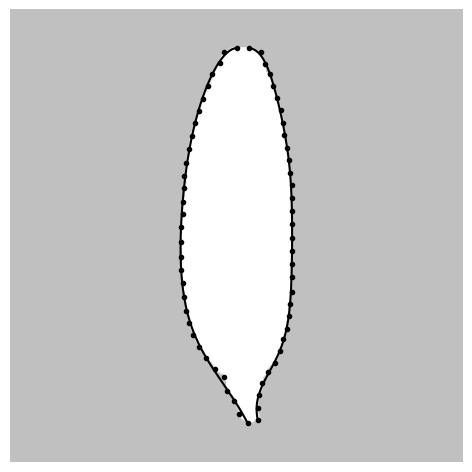

In [11]:
%%time
checkToD7(7,N=7,LR=0,err_th=1,lr=0.001)

Left
.E

Right
.E

TEST ./pics\Beztest.png
Wall time: 3.61 s


((0.2926229057692542, 0.5543670256058364),
 3.484375,
 (1, 1),
 ([[157.0, 26.0],
   [108.05988651753565, 24.1992594250077],
   [154.36584729760034, 117.60657951164774],
   [85.88123858188013, 104.37910893944785],
   [160.6906706767059, 179.6060629199862],
   [105.30492621458728, 215.22966802383837],
   [157.59312813812457, 235.9517640603019],
   [159.0, 280.0]],
  [[163.0, 28.0],
   [205.48301627304994, 22.1736500815213],
   [169.04254565857528, 138.731700327025],
   [149.18356876613592, 73.98851424155865],
   [229.90250895258828, 218.65057865123276],
   [141.53983823295601, 181.6636506328186],
   [162.08386291448673, 245.66061240174193],
   [166.0, 279.0]]))

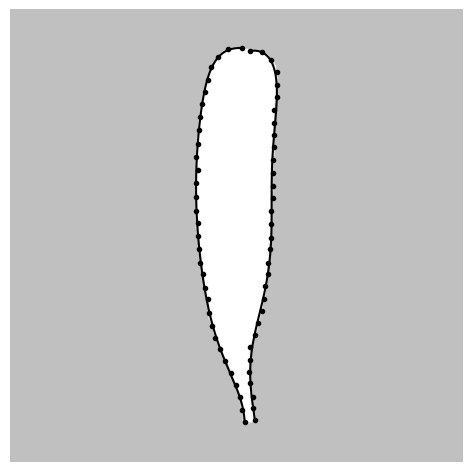

In [ ]:
%%time
checkToD7(8,N=7,LR=0,err_th=1,lr=0.001)

# ここから全周11次

....
CP 5.0, steps:3, etime: 6.09375 err: 4.5527658154
..............
CP 2.0, steps:17, etime: 17.35938 err: 1.9336684677
...........E

TEST ./pics\Beztest.png


((0.9517892587936932, 0.9517892587936932),
 26.296875,
 29,
 [[149.0, 279.0],
  [94.88682457598976, 263.3617224322408],
  [325.3113142732051, 346.80664895310224],
  [-1162.652323825951, 57.35171395876141],
  [2779.320672336839, -235.69036576810927],
  [-2538.3385546954073, 1021.9651734571382],
  [410.95253857489166, -1549.9915546518725],
  [2432.815135595581, 1264.701693401626],
  [-2226.3763680716893, -572.2017160823792],
  [1314.786478817076, 298.8307613117228],
  [42.502009008716186, 267.32730087820596],
  [208.7114987100018, 268.39059005512024],
  [156.0, 281.0]])

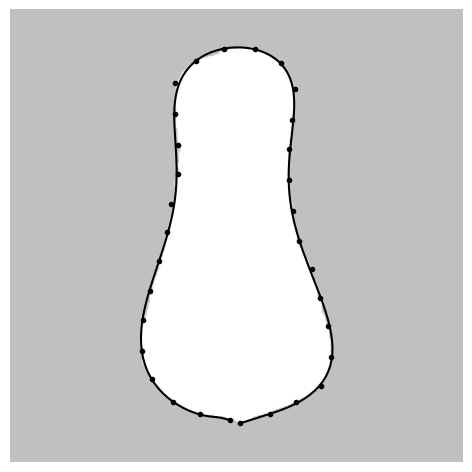

In [18]:
 checkTo11(0,12,LR=0,Nsamples=65,mode=1,err_th=1.0,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 8.62500 err: 4.1845683594
..........
CP 2.0, steps:11, etime: 23.17188 err: 1.8976459298
..........E

TEST ./pics\Beztest.png


((0.9823271476497842, 0.9823271476497842),
 37.765625,
 22,
 [[149.0, 279.0],
  [5.619374585572343, 253.31690787095306],
  [567.6919023706743, 335.2952928322662],
  [-1610.7208732233241, 105.17235664350487],
  [3445.8604727627885, -397.0828811872278],
  [-3305.1823399724913, 1417.9627017591501],
  [976.8992222838122, -2063.512722677434],
  [2334.320028163208, 1564.4104236145706],
  [-2514.1392479446954, -540.1647772739504],
  [1685.0717907735032, 168.40390266470925],
  [-191.49749367698334, 353.22506127391046],
  [289.2641166674406, 237.67601515805075],
  [156.0, 281.0]])

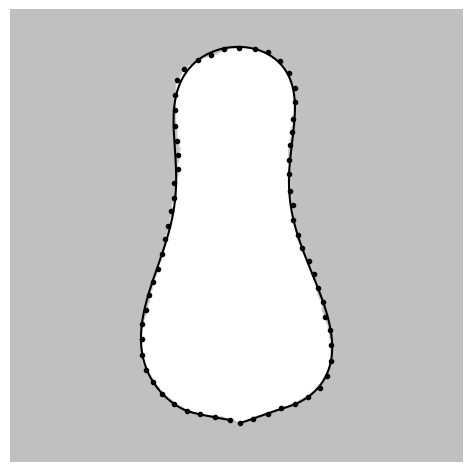

In [20]:
 checkTo11(0,12,LR=0,Nsamples=65,mode=1,err_th=1.0,pat=1000,maxTry=3000,lr=0.001)

In [101]:
 checkTo11(0,12,LR=0,Nsamples=16,mode=1,err_th=1.0,pat=1000,maxTry=3000,lr=0.001)

KeyboardInterrupt: 

e1.........^..........^^^^^^^^..........................
CP 5.0, steps:53, etime: 31.67188 err: 4.9881386406
..............................................
......................
CP 2.0, steps:121, etime: 69.23438 err: 1.9828272454
....................E

TEST ./pics\Beztest.png


((0.9861409998601468, 0.9861409998601468),
 80.28125,
 142,
 [[149.0, 279.0],
  [-79.43471599939377, 288.30731218428247],
  [-578.862447527551, -927.0104813003426],
  [9149.548733576028, 1266.539305200455],
  [-34356.90811361129, 3199.644221341974],
  [71938.82131250009, -10822.806500819752],
  [-93581.0146324149, 14746.585139765722],
  [78731.50209927121, -9588.024975574433],
  [-42541.90553437923, 1583.2475003153706],
  [15726.470938952498, 1606.0791087438552],
  [-3642.820015062216, -887.5877835020597],
  [797.385058728086, 151.76398840614488],
  [156.0, 281.0]])

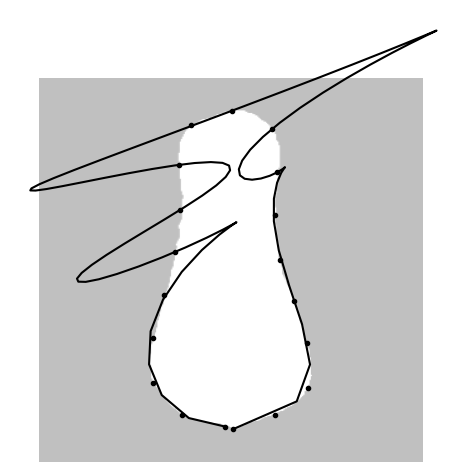

In [15]:
 checkTo11(0,N=12,LR=0,Nsamples=19,mode=1,err_th=1.0,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 3.14062 err: 2.0529129989
^^^^.
CP 2.0, steps:6, etime: 5.98438 err: 1.3907463511
.^^..E

TEST ./pics\Beztest.png


((0.9836850298086792, 0.9836850298086792),
 8.890625,
 12,
 [[149.0, 279.0],
  [99.2453645072826, 253.1453289651936],
  [-174.88164963437922, 366.100790849493],
  [1131.6461413626619, -344.426746600039],
  [-2994.1961412722358, 1139.3091873929598],
  [6910.907577212, -1315.5810863549202],
  [-10063.976113015275, 1426.2834515136253],
  [10296.417212648848, -1229.163872113156],
  [-6503.658514849623, 546.4066524249122],
  [3293.5654897359764, 146.98703481250834],
  [-875.0664335757459, 135.3135989401006],
  [513.8347165580748, 183.1320298965279],
  [156.0, 281.0]])

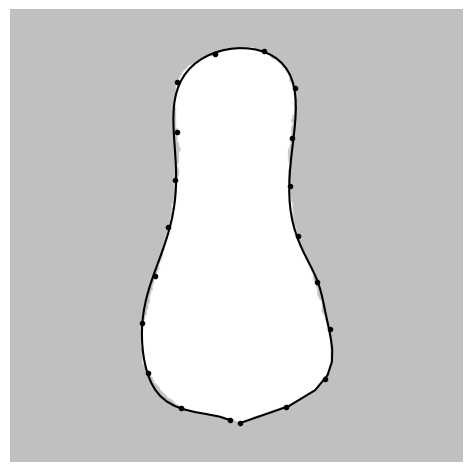

In [16]:
 checkTo11(0,N=12,LR=0,Nsamples=20,mode=1,err_th=1.0,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 3.28125 err: 3.9392063987
^....
CP 2.0, steps:6, etime: 6.23438 err: 1.6065143333
.E

TEST ./pics\Beztest.png


((0.8431573635868506, 0.8431573635868506),
 6.84375,
 8,
 [[147.0, 280.0],
  [155.0491441594914, -18.672094214293026],
  [101.26327347739344, 633.951947268457],
  [-69.36393373858188, -1294.3718819560843],
  [159.0092703666458, 4018.1551249314825],
  [69.75845159126773, -7595.846828950049],
  [-291.1265362093309, 9737.173486312977],
  [1042.575107737499, -8715.241058827065],
  [-547.3102928463438, 5624.203069383078],
  [852.349573634141, -2620.320387914995],
  [-24.574053979149888, 1232.7952961377266],
  [249.45952468892534, -158.45920979387574],
  [154.0, 280.0]])

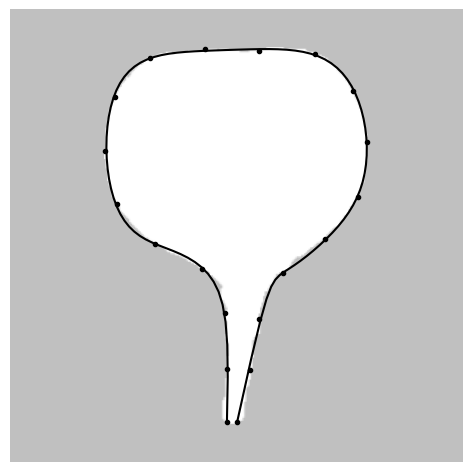

In [17]:
 checkTo11(1,N=12,LR=0,Nsamples=20,mode=1,err_th=1.0,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 7.32812 err: 2.5250353202
.
CP 2.0, steps:1, etime: 9.01562 err: 1.8657013387
..........
CP 1.0, steps:11, etime: 26.00000 err: 0.9830654243
.................
CP 0.65, steps:28, etime: 54.82812 err: 0.6466974028
........................E

TEST ./pics\Beztest.png


((0.496245670175586, 0.496245670175586),
 95.765625,
 53,
 [[171.0, 277.0],
  [171.05855514620532, 244.32979016561504],
  [185.68003761416105, 405.33009166342754],
  [-132.83891153093788, -1457.6701514572173],
  [1176.071858343345, 5631.037216699127],
  [-2503.3598582469494, -11521.465458371518],
  [4886.655540912869, 16858.760704497272],
  [-4883.386051338805, -17913.04045334925],
  [3657.56768763555, 13430.083416834384],
  [-1532.4687643323953, -6651.984301531565],
  [526.8110100753894, 2400.161276596941],
  [109.90911046976265, -186.51741498803696],
  [123.7291497323347, 250.35939541163123],
  [167.0, 281.0]])

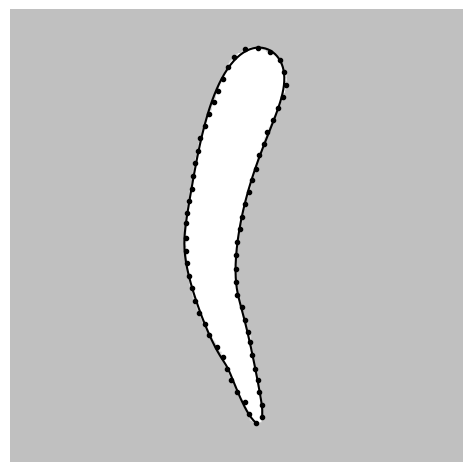

In [23]:
 checkTo11(2,N=13,LR=0,Nsamples=65,mode=1,err_th=0.5,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 4.07812 err: 2.8577238948
.
CP 2.0, steps:1, etime: 5.06250 err: 1.8979148982
.........
CP 1.0, steps:10, etime: 13.67188 err: 0.9933257728
.................
CP 0.65, steps:27, etime: 30.12500 err: 0.6459057997
................E

TEST ./pics\Beztest.png


((0.4930826545466044, 0.4930826545466044),
 45.546875,
 44,
 [[171.0, 277.0],
  [160.8990372230209, 228.17989122017272],
  [233.84960238584475, 421.7025842856728],
  [-261.80863906521023, -1287.9398266268438],
  [1437.654955732086, 4914.73672123138],
  [-2912.575453315793, -9992.747615244132],
  [5351.500025323814, 14814.395384007017],
  [-5268.233355749757, -16057.937052199644],
  [3887.7873287822376, 12274.569090384277],
  [-1628.476011301156, -6160.271931874765],
  [555.3420261813066, 2228.2691893412048],
  [107.67862531884691, -123.45532045960184],
  [117.74151585546707, 224.60128186014379],
  [167.0, 281.0]])

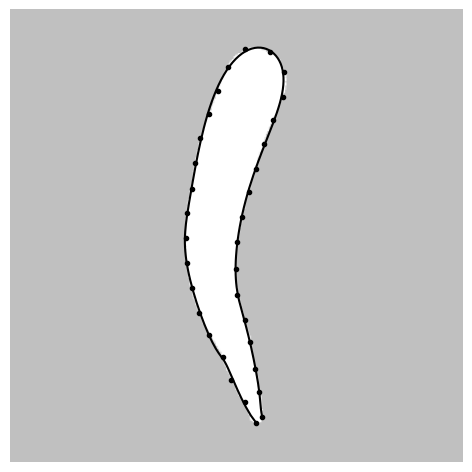

In [24]:
 checkTo11(2,N=13,LR=0,Nsamples=33,mode=1,err_th=0.5,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 4.29688 err: 3.5575914854
..
CP 2.0, steps:3, etime: 5.68750 err: 1.9283977623
................
CP 1.0, steps:19, etime: 16.81250 err: 0.9775040873
......................................................
CP 0.65, steps:73, etime: 54.59375 err: 0.6494960373
..........................
....................................................................................................
.............E

TEST ./pics\Beztest.png


((0.49965509525956375, 0.49965509525956375),
 151.75,
 213,
 [[171.0, 277.0],
  [158.9217927779857, 196.11530638046662],
  [118.41805682357177, -114.73846808072729],
  [379.66626482997896, 1684.833587227164],
  [-731.1003261265073, -3540.028161779811],
  [1976.414080836885, 5354.109796892098],
  [-1636.748677253342, -5593.1085005236755],
  [1252.9301055975293, 3764.8394972811698],
  [-380.6392560022876, -1302.8709939676787],
  [211.46355243828484, 491.4756098980769],
  [147.4090241205404, 233.56442056983832],
  [167.0, 281.0]])

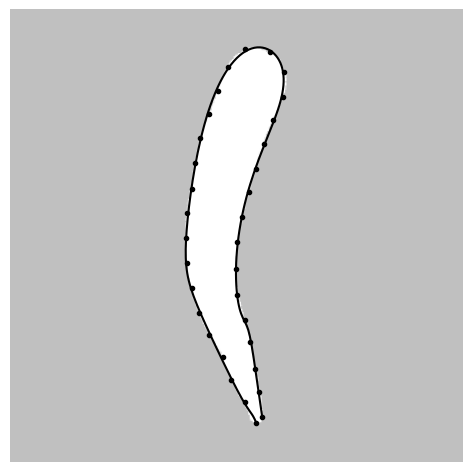

In [25]:
 checkTo11(2,N=11,LR=0,Nsamples=33,mode=1,err_th=0.5,pat=1000,maxTry=3000,lr=0.001)

...
CP 5.0, steps:2, etime: 5.09375 err: 4.7499113215
...............
CP 2.0, steps:17, etime: 15.51562 err: 1.9904692025
.......................................
CP 1.0, steps:56, etime: 42.76562 err: 0.9986717459
...........................................
....................................................................................................
....................................................................................................
...........^...^^.^....^..^..^^^^^^^^^^^^^^............^..^.^.^.^.^......^...^..^^..^..^^..^...^..^.
..^.^.^...^^...^...^...^^...........^...^.......^...^..................^..^..^....................^.
...^^.^^...^..^..^...........^....^^^^..^^^...^^^^^.^^^^^^^^^^^^^^^^^.^^^...^^^^......^^^^^^^^^^..^^
^^^^^^^^^^^^^^^^.^^^^^^^^^^^^....................................^..^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^.
^^^....^^^^.^^.^.^^.^....^.^.^.^^^^.^.^^.^^^^^^.^^.^^^^^^.^...^.^^^^^^..^^^.^^^^^^^^^^^^^...^.^..^.^
..^..^^.^^^^^^^^^^^^^^....^^^.^^.^^

((0.6932021230323522, 0.6932021230323522),
 2104.515625,
 3001,
 [[138.0, 279.0],
  [104.01273632932764, 258.47835968497037],
  [612.3744276379025, 14.433235432684988],
  [-2294.073343926609, 1181.5372120826578],
  [5351.578267694152, -1711.0991334296828],
  [-7215.490298712433, 1099.2637675310507],
  [7070.605521158295, 489.46212958890595],
  [-4329.479166711872, -1551.622908181221],
  [2243.7111008034153, 1200.579734622846],
  [-239.31894443975924, 33.76419960501507],
  [219.2211601958096, 237.62876202007126],
  [144.0, 281.0]])

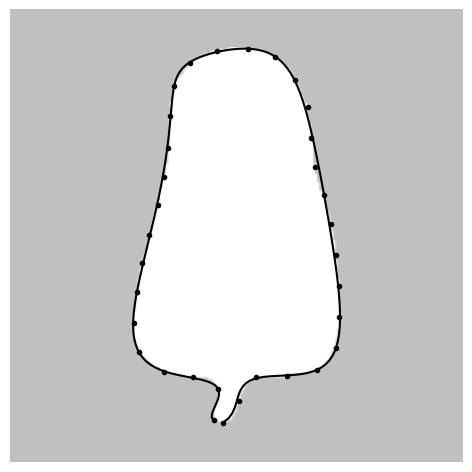

In [26]:
 checkTo11(6,N=11,LR=0,Nsamples=33,mode=1,err_th=0.5,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 2.79688 err: 4.6150787682
.^^^..^^.............................
CP 2.0, steps:37, etime: 21.20312 err: 1.9366546288
...................
CP 1.0, steps:56, etime: 30.79688 err: 0.9984461313
..................
CP 0.65, steps:74, etime: 39.78125 err: 0.6441287240
.................E

TEST ./pics\Beztest.png


((0.4999536207682789, 0.4999536207682789),
 48.3125,
 92,
 [[138.0, 279.0],
  [-3.0574740048049174, 313.1574633517302],
  [1152.2839906587728, -273.6536494496324],
  [-3650.1853112302697, 2009.5107448658696],
  [7582.855005839675, -3116.225316114604],
  [-9782.581575937513, 2544.468283337177],
  [9153.903779318904, -480.5007335511822],
  [-5489.746304225028, -1094.4559721574392],
  [2637.8407995565253, 1047.0014226547842],
  [-296.27534812037806, 16.743305572520114],
  [214.9614254221296, 260.0901771576918],
  [144.0, 281.0]])

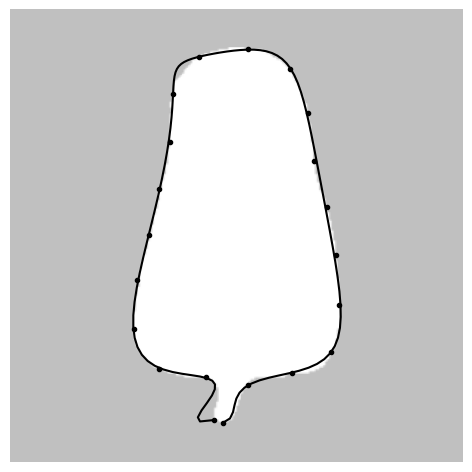

In [27]:
 checkTo11(6,N=11,LR=0,Nsamples=21,mode=1,err_th=0.5,pat=1000,maxTry=3000,lr=0.001)

.....
CP 5.0, steps:4, etime: 5.07812 err: 4.8358872012
.........................
CP 2.0, steps:29, etime: 19.28125 err: 1.9497332008
................................................................E

TEST ./pics\Beztest.png


((0.9996932154067476, 0.9996932154067476),
 55.578125,
 94,
 [[138.0, 279.0],
  [76.49076787108001, 277.3089727506905],
  [733.249201788356, -135.72102675259652],
  [-2604.3561322225914, 1730.8784618865172],
  [5922.626239172153, -2948.927517594972],
  [-8021.910708484006, 2968.2358382399375],
  [7932.437638241192, -1489.4664591949095],
  [-4954.473181365084, -222.15621317945903],
  [2570.7163104430897, 790.7661338799804],
  [-339.55902430187206, 44.264410470364574],
  [218.52013215106263, 272.40717143137306],
  [144.0, 281.0]])

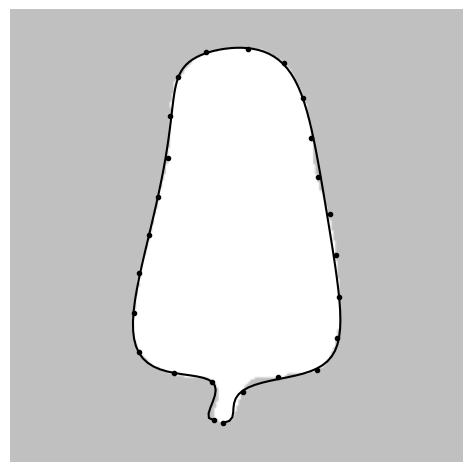

In [29]:
 checkTo11(6,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 3.98438 err: 4.9185081893
.......................
CP 2.0, steps:24, etime: 18.40625 err: 1.9609508934
................................................E

TEST ./pics\Beztest.png


((0.9970385873563534, 0.9970385873563534),
 48.75,
 73,
 [[138.0, 279.0],
  [109.44619775769826, 255.77416221384374],
  [562.7592321567082, -0.2175388553479356],
  [-2181.089390813848, 1346.120193228232],
  [5254.57351950401, -2369.337888290997],
  [-7266.534345618254, 2438.4069947991406],
  [7271.531461633786, -1225.8202893129978],
  [-4470.453817201827, -242.04743920250007],
  [2291.7675993281127, 750.5190456032108],
  [-235.56662558030936, 64.78564525857594],
  [208.30874605113152, 260.11725938354],
  [144.0, 281.0]])

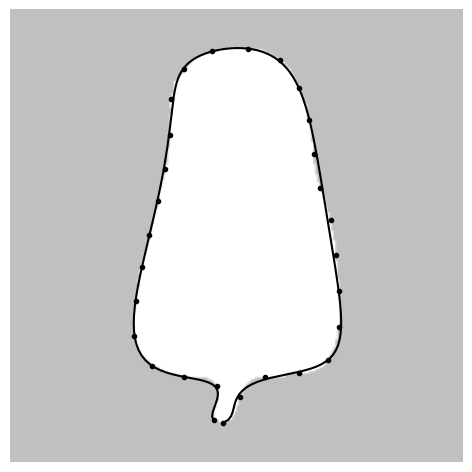

In [30]:
checkTo11(6,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...
CP 5.0, steps:2, etime: 4.95312 err: 4.7499113215
...............
CP 2.0, steps:17, etime: 15.39062 err: 1.9904692025
.......................................E

TEST ./pics\Beztest.png


((0.9986717458734398, 0.9986717458734398),
 42.640625,
 57,
 [[138.0, 279.0],
  [132.23236987643799, 237.37180543128798],
  [415.24526447246245, 108.16417933801024],
  [-1835.4655931709578, 952.779587542806],
  [4807.8178740938065, -1580.620172817707],
  [-6972.33288513044, 1492.3022386113125],
  [7271.813651434869, -570.2544419492692],
  [-4629.123363939176, -395.86715424001204],
  [2435.8927386157147, 611.7940627030537],
  [-308.36170641156116, 200.7442234108568],
  [229.33544268984485, 213.45479136453721],
  [144.0, 281.0]])

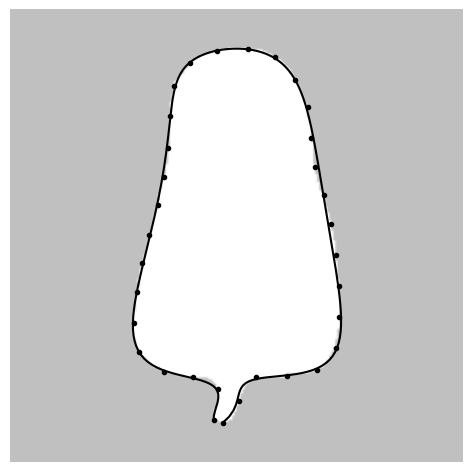

In [31]:
checkTo11(6,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...
CP 5.0, steps:2, etime: 5.57812 err: 4.6316501871
...........
CP 2.0, steps:13, etime: 13.92188 err: 1.9684300601
............................E

TEST ./pics\Beztest.png


((0.9789281045925974, 0.9789281045925974),
 35.5,
 42,
 [[138.0, 279.0],
  [140.64806324780935, 223.0896844881021],
  [340.3176467575114, 175.19926192061362],
  [-1674.7820182954954, 746.3254184338313],
  [4674.538129926488, -1366.0284448963373],
  [-7051.670518136386, 1691.8923815255982],
  [7579.566376343832, -1389.8446550759204],
  [-4959.777825549424, 645.358881215281],
  [2663.5665026259358, -69.17600955959747],
  [-421.326875255692, 450.42964617340374],
  [265.77489376405657, 165.56951105708367],
  [144.0, 281.0]])

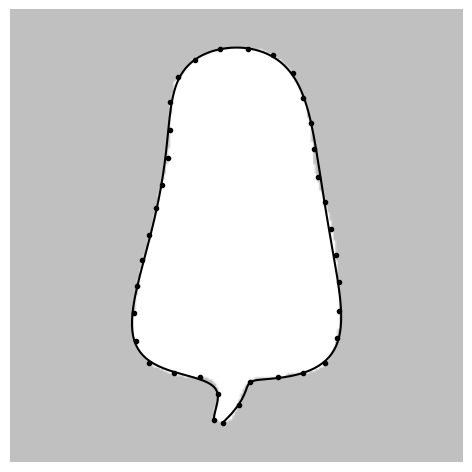

In [46]:
checkTo11(6,N=11,LR=0,Nsamples=37,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...
CP 5.0, steps:2, etime: 6.04688 err: 4.6859418594
................
CP 2.0, steps:18, etime: 19.26562 err: 1.9789738421
...................................................................E

TEST ./pics\Beztest.png


((0.9976266603720073, 0.9976266603720073),
 74.765625,
 86,
 [[138.0, 279.0],
  [154.62097650213087, 183.80575673855714],
  [215.85496197532078, 333.02074039384553],
  [-1259.9591090725905, 378.68923780516],
  [3834.2751794247365, -705.3805580338578],
  [-5888.928280554994, 496.9453976028937],
  [6489.967911736592, 313.86165355874454],
  [-4269.629838513668, -999.3149693017183],
  [2339.847663643079, 913.1475592938859],
  [-297.19651958387743, 85.03059402485866],
  [224.80743178502286, 243.28153197742373],
  [144.0, 281.0]])

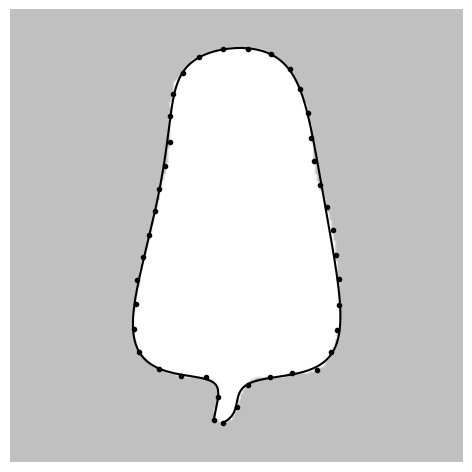

In [32]:
checkTo11(6,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..........
CP 5.0, steps:9, etime: 12.04688 err: 4.8526021360
..........................................................................................
........................................
CP 2.0, steps:139, etime: 119.40625 err: 1.9997563049
............................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................E

TEST ./pics\Beztest.png


((0.99889470996172, 0.99889470996172),
 480.0,
 575,
 [[148.0, 279.0],
  [151.67441951315593, 199.30346270081367],
  [190.01993570549868, -504.43357491237265],
  [-207.802202952103, 2392.7446898011794],
  [268.9189431469174, -4218.709135047985],
  [103.62675754760744, 4927.666785482101],
  [-65.83411114556527, -3779.8135994363925],
  [710.6679559068716, 1551.1398506223136],
  [52.73850699890982, 184.03659586243106],
  [171.16012480304371, -36.27745482382829],
  [176.00225883125364, 180.93133968862867],
  [154.0, 280.0]])

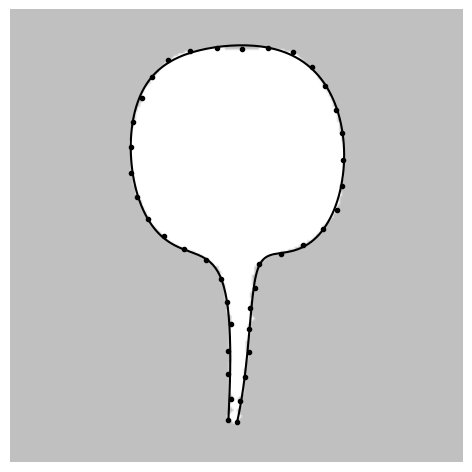

In [33]:
checkTo11(4,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.........
CP 5.0, steps:8, etime: 9.26562 err: 4.9908500281
........................................
CP 2.0, steps:48, etime: 37.20312 err: 1.9803283442
...................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................E

TEST ./pics\Beztest.png


((0.9984627803046467, 0.9984627803046467),
 379.8125,
 540,
 [[148.0, 279.0],
  [153.642423966946, 164.14802695996565],
  [157.33617871232093, -370.61230644970954],
  [-94.46442508759924, 2018.545002121041],
  [205.16582261170421, -3423.4613223939396],
  [-87.88878685879446, 4017.1409187039417],
  [255.2257726259994, -3233.5037491505586],
  [497.5787093180989, 1450.859243773817],
  [130.79299471834307, 132.19486995861027],
  [147.1668552575932, -2.2567084858946256],
  [179.0501056200044, 177.90820005848732],
  [154.0, 280.0]])

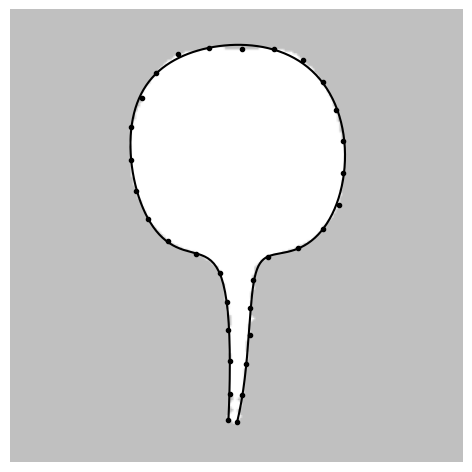

In [34]:
checkTo11(4,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..^.......
CP 5.0, steps:9, etime: 9.17188 err: 4.9666905494
..................................
CP 2.0, steps:43, etime: 30.57812 err: 1.9909372507
........................................................
....................................................................................................
....................................................................................................
........................................................E

TEST ./pics\Beztest.png


((0.9982231836749967, 0.9982231836749967),
 227.71875,
 356,
 [[148.0, 279.0],
  [138.20644713991018, 156.96513257289584],
  [326.9228368612409, -188.18925882717178],
  [-808.7318704737327, 1243.1748319243598],
  [1932.3539256318006, -1710.210622492493],
  [-2703.4897597558615, 1784.353401551036],
  [2783.5657096077634, -1197.6766591073524],
  [-1177.5126011127293, 100.41251406696928],
  [863.8882624421059, 711.6827987687518],
  [-25.872048445856553, -122.80658842248053],
  [203.9451265254149, 155.19247966292502],
  [154.0, 280.0]])

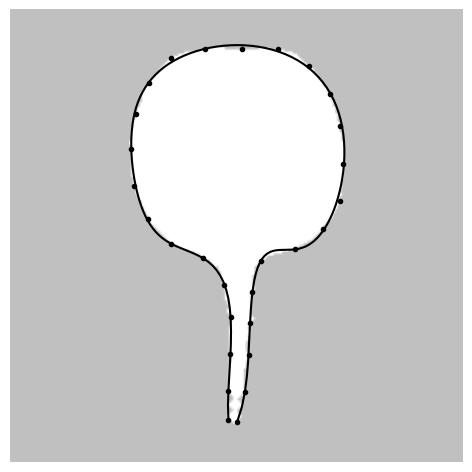

In [35]:
checkTo11(4,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...........
CP 5.0, steps:10, etime: 8.65625 err: 4.8720549189
.........................................................................
CP 2.0, steps:83, etime: 50.06250 err: 1.9947409695
................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................................................E

TEST ./pics\Beztest.png


((0.9994936725877718, 0.9994936725877718),
 383.046875,
 672,
 [[148.0, 279.0],
  [141.21692308151313, 144.9004425400751],
  [250.57170462305692, -181.04309568613496],
  [-448.65189937177604, 1249.13260158033],
  [968.4100090990532, -1606.8948998710662],
  [-1105.0961464891966, 1183.9978852463735],
  [1149.3901007422205, -51.69485910789532],
  [-184.15498781267985, -1001.4174734060107],
  [501.6165395329781, 1202.870865212006],
  [63.41583102987316, -193.8612081811377],
  [191.69983928555342, 128.91761189960187],
  [154.0, 280.0]])

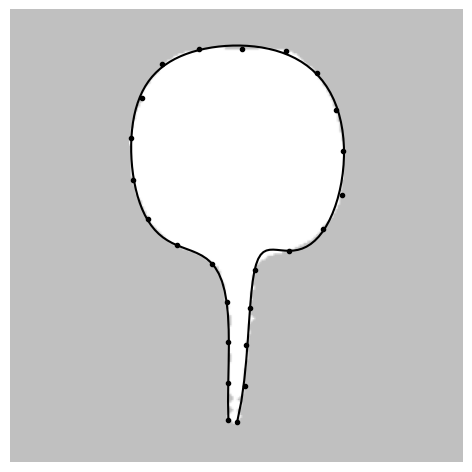

In [36]:
checkTo11(4,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.......
CP 5.0, steps:6, etime: 5.64062 err: 4.7778597169
.............................................................................................
...................
CP 2.0, steps:118, etime: 61.78125 err: 1.9963148989
.................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................................................^............................
.......................................................................^^..^^^^.....................
....................................................................................................
.......................................................................................

((0.9999690944728679, 0.9999690944728679),
 709.5,
 1391,
 [[148.0, 279.0],
  [136.2891672116979, 138.26931223062167],
  [348.03932327189716, -177.20563060812006],
  [-899.8261273893119, 1496.2423203613357],
  [1865.5393431994164, -2842.9645168553843],
  [-2169.7503767209605, 3643.5942509634797],
  [1921.416793821594, -3007.0199315545756],
  [-290.5780736821708, 1189.8083331202656],
  [289.54374404144653, 394.44664381265505],
  [149.97541128979046, -76.7488258375709],
  [180.78112515618798, 138.27823619927258],
  [154.0, 280.0]])

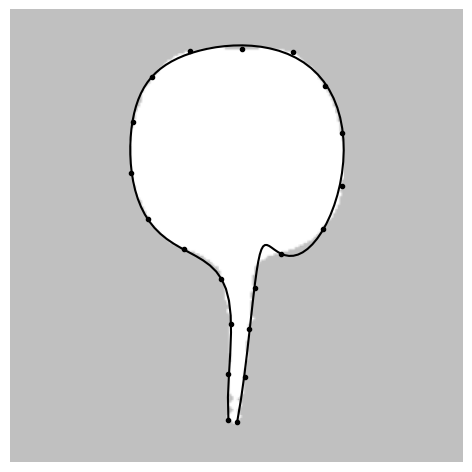

In [37]:
checkTo11(4,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

......
CP 5.0, steps:5, etime: 5.15625 err: 4.9437821874
.................................................................................
CP 2.0, steps:86, etime: 45.87500 err: 1.9997331553
.............
....................................................................................................
....................................................................................................
....................................................................................................
................................^^^^................................................................
......................................^^^^..........................................................
........................................^.^^.^.^.^.^...^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^.^^^.^^...^^...................................^^^^^^^^^^^^^...........^^...^^^^^.^
^^^^^^^^^^^^^^^^^^^^^^................^^^^^^^^^..........................^^^^^^^^^^^^^^^

((1.0094658054584895, 1.0094658054584895),
 1509.203125,
 3001,
 [[147.0, 280.0],
  [152.7353126954235, 60.54813878217418],
  [-58.03235028715454, -427.91292294580734],
  [2172.4614734484617, 3039.0226903844637],
  [-6957.446875212322, -5340.452800415361],
  [11940.870925346375, 4901.02806739824],
  [-11841.183572569154, -1766.5271572953322],
  [7912.6417953953805, -940.4942386381525],
  [-2427.347631367744, 1296.2973303180408],
  [522.9454258339989, -123.6077992245057],
  [182.1538710575417, 131.4154194473378],
  [154.0, 280.0]])

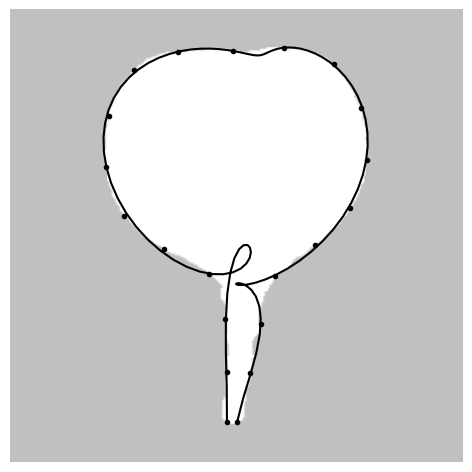

In [38]:
checkTo11(1,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..^......
CP 5.0, steps:8, etime: 7.53125 err: 4.8582759481
...........................................................................................
................
CP 2.0, steps:115, etime: 68.21875 err: 1.9996847869
....................................................................................
.................................E

TEST ./pics\Beztest.png


((0.9973959868006019, 0.9973959868006019),
 134.71875,
 233,
 [[147.0, 280.0],
  [138.32385256207485, 160.2556411758698],
  [192.4846501064958, -156.31105020804588],
  [61.108185134091315, 1156.830302798987],
  [-896.9555846220105, -1231.2041931141434],
  [2271.752500352498, -99.0309063216097],
  [-2532.8247799487513, 2043.0759289373807],
  [2124.5648480614173, -2720.6232520506965],
  [-270.50105402684864, 1753.2346686149826],
  [208.73907743580187, -237.82109000433053],
  [196.0267394882579, 145.66125663250654],
  [154.0, 280.0]])

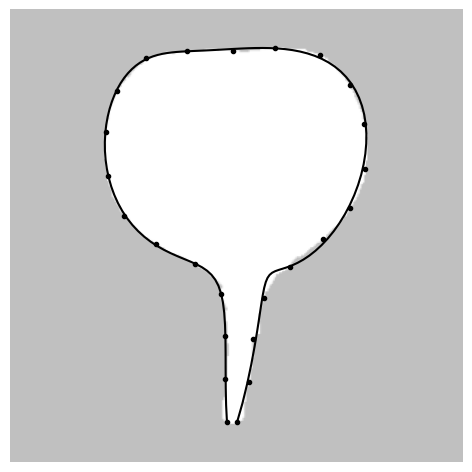

In [39]:
checkTo11(1,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

......
CP 5.0, steps:5, etime: 6.50000 err: 4.9499111618
......................................................................
CP 2.0, steps:75, etime: 50.76562 err: 1.9960997372
........................
................................................................................E

TEST ./pics\Beztest.png


((0.9989480962002485, 0.9989480962002485),
 116.625,
 180,
 [[147.0, 280.0],
  [128.00547894159422, 164.77535233074195],
  [369.15594380920385, -160.45686532477438],
  [-938.4408705365262, 1126.8382503152022],
  [1891.2720629269159, -1411.8839744993525],
  [-2429.401667812247, 950.6844820281194],
  [2392.995103393469, 134.47733603086022],
  [-985.7151421633988, -968.0733858493085],
  [864.3046265116143, 990.5354501826477],
  [35.536465903450505, -153.60161896333315],
  [201.57318620075475, 172.03745093342704],
  [154.0, 280.0]])

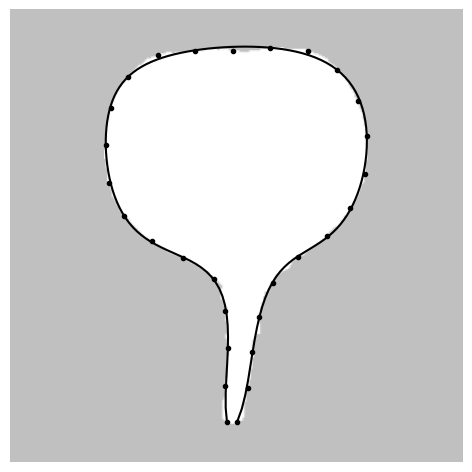

In [40]:
checkTo11(1,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...^...
CP 5.0, steps:6, etime: 8.04688 err: 4.8684805808
........................................................................................
CP 2.0, steps:94, etime: 69.37500 err: 1.9906779399
.....
....................................................................................................
....................................E

TEST ./pics\Beztest.png


((0.9953008793767446, 0.9953008793767446),
 167.796875,
 236,
 [[147.0, 280.0],
  [139.94829731465785, 176.527582692312],
  [208.82592982999813, -262.90286816195754],
  [-41.472891191605065, 1562.9763165401885],
  [-748.2089479352375, -2248.049589237421],
  [2270.9707124611705, 1467.9197596450365],
  [-2804.9468244747036, 484.5199084442383],
  [2567.5756536900485, -1761.2495347133488],
  [-555.2729991451391, 1453.7410047247427],
  [268.62718562459537, -195.44978165130073],
  [192.6356844871908, 155.86343017603937],
  [154.0, 280.0]])

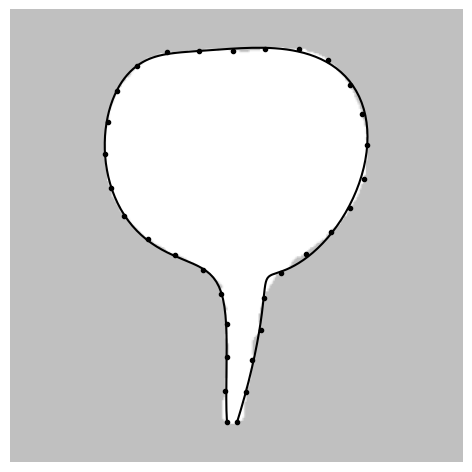

In [41]:
checkTo11(1,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.....
CP 5.0, steps:4, etime: 7.70312 err: 4.9213666146
......................................................
CP 2.0, steps:58, etime: 52.56250 err: 1.9931445248
.........................................
........................................................E

TEST ./pics\Beztest.png


((0.9965440178710512, 0.9965440178710512),
 133.109375,
 156,
 [[147.0, 280.0],
  [124.27893014141173, 191.95384403732953],
  [359.40735763734676, -259.7190944565707],
  [-784.6382066047124, 1358.2231852934863],
  [1442.9775008783295, -1668.3333986706577],
  [-1719.5151823184842, 965.5338550654997],
  [1696.8041259577044, 455.4563363690199],
  [-552.8716067729407, -1414.5818879896997],
  [713.8982072583153, 1299.5808003489037],
  [47.74485314590807, -273.91636585952443],
  [201.9874239678409, 202.99879346198685],
  [154.0, 280.0]])

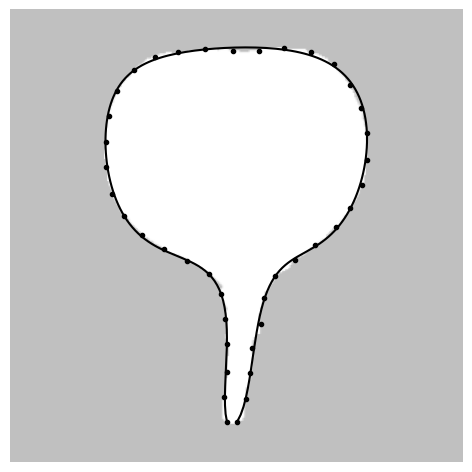

In [42]:
checkTo11(1,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 3.15625 err: 4.6687289192
....
CP 2.0, steps:5, etime: 5.18750 err: 1.8168517181
.....E

TEST ./pics\Beztest.png


((0.9855352272992766, 0.9855352272992766),
 7.734375,
 11,
 [[168.0, 279.0],
  [250.58763396932198, -29.882392199592076],
  [53.32892560215316, 815.8406736591123],
  [477.9560811426161, -1608.608716726982],
  [-309.6278857561392, 2900.9143920676797],
  [898.550571205816, -2922.076787172456],
  [-622.9110117069732, 1339.840739097013],
  [683.9923615467221, 308.4270718462862],
  [-267.66330110539275, -545.5350126656855],
  [338.1050519844756, 575.7050591900069],
  [8.529241932060524, 34.68580832830634],
  [161.0, 281.0]])

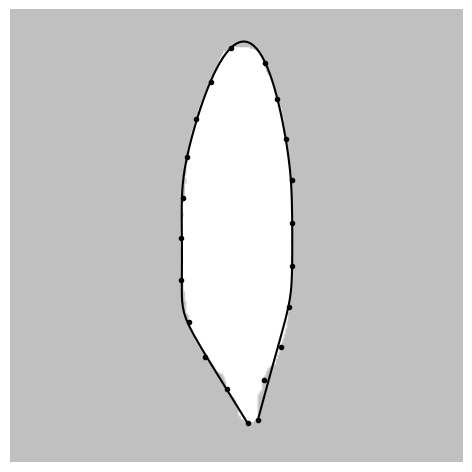

In [43]:
checkTo11(7,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 2.98438 err: 3.8942101030
.
CP 2.0, steps:1, etime: 3.53125 err: 1.7402555887
.E

TEST ./pics\Beztest.png


((0.9392477616242819, 0.9392477616242819),
 4.15625,
 3,
 [[168.0, 279.0],
  [167.4056329296711, 204.0716215977628],
  [199.0238433657286, 423.2915281479361],
  [424.18379559320806, -689.1408360246536],
  [-609.2190851385787, 1672.8374841074042],
  [1677.634243372207, -1604.3851683515995],
  [-1491.0613125496798, 417.4611480303584],
  [1187.075886218265, 470.3150961477765],
  [-347.54791996214124, -231.71400166038944],
  [208.29811827785525, 340.1999115334576],
  [119.13877972930861, 211.91218743045334],
  [161.0, 281.0]])

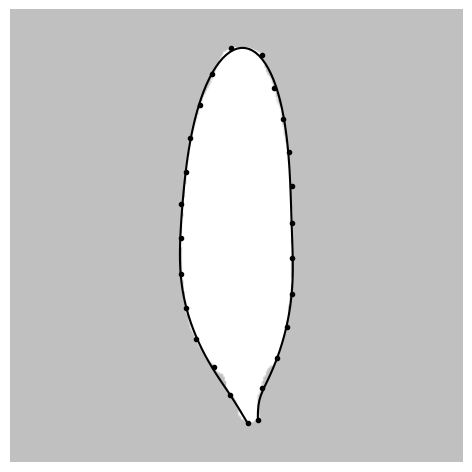

In [47]:
checkTo11(7,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.67188 err: 4.0242998869
..
CP 2.0, steps:2, etime: 5.07812 err: 1.4994889058
..E

TEST ./pics\Beztest.png


((0.968940194444742, 0.968940194444742),
 6.5,
 5,
 [[168.0, 279.0],
  [164.86334301599354, 193.38261112186433],
  [195.75637527743532, 484.56701795139486],
  [429.4686031758013, -860.4461864597172],
  [-589.4078952696949, 2046.5909879947603],
  [1622.5661150875449, -2184.00711336152],
  [-1448.8580277813446, 995.3065838429292],
  [1180.9877099020491, 104.63368062639242],
  [-354.4815162604626, -93.75872578676258],
  [205.85871998637563, 320.24105134322053],
  [127.89704305890128, 215.80551435578485],
  [161.0, 281.0]])

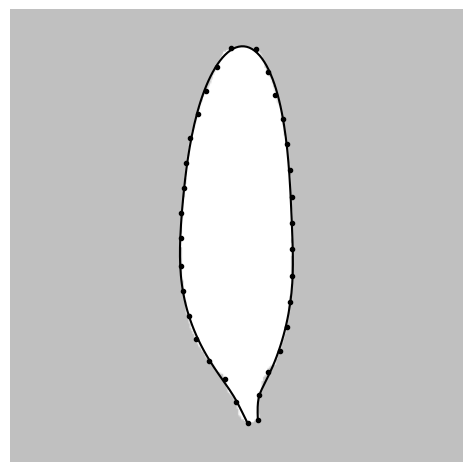

In [48]:
checkTo11(7,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 4.59375 err: 3.0214875041
.
CP 2.0, steps:1, etime: 5.42188 err: 1.5766755614
..E

TEST ./pics\Beztest.png


((0.8313036867451447, 0.8313036867451447),
 7.125,
 4,
 [[168.0, 279.0],
  [160.22315914716924, 180.04472117033126],
  [214.37610475791558, 545.9925942840586],
  [376.23299579539713, -980.6966862930673],
  [-482.9084245079765, 2187.454495707682],
  [1472.101167559115, -2306.9804732758507],
  [-1302.6378855653393, 1073.4804916403996],
  [1088.018362706761, 86.52381928077821],
  [-321.2230903809473, -110.93409336103932],
  [205.65248445303146, 334.3350763026753],
  [121.72736155200708, 212.0454452663923],
  [161.0, 281.0]])

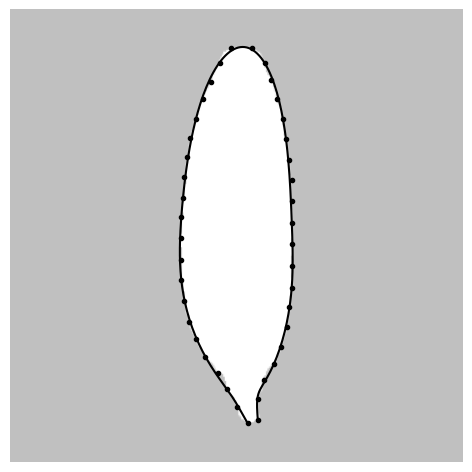

In [44]:
checkTo11(7,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.......
CP 5.0, steps:6, etime: 8.57812 err: 4.8694876039
.............................................................................
CP 2.0, steps:83, etime: 67.12500 err: 1.9903416251
................
..................................................................E

TEST ./pics\Beztest.png


((0.991052597115972, 0.991052597115972),
 129.640625,
 166,
 [[147.0, 280.0],
  [130.43707597399805, 182.77369944051839],
  [301.0106930758608, -319.90156361016574],
  [-520.5911324362839, 1717.8987071102542],
  [795.6703550684304, -2523.7725408156],
  [-769.7334593528803, 2117.6491081982],
  [889.0159302604626, -602.4413420463172],
  [-171.43519170266242, -692.779174446243],
  [638.8720719916159, 927.9975276054026],
  [37.49536698161744, -154.54086121044756],
  [202.6083025111285, 197.1023266068447],
  [154.0, 280.0]])

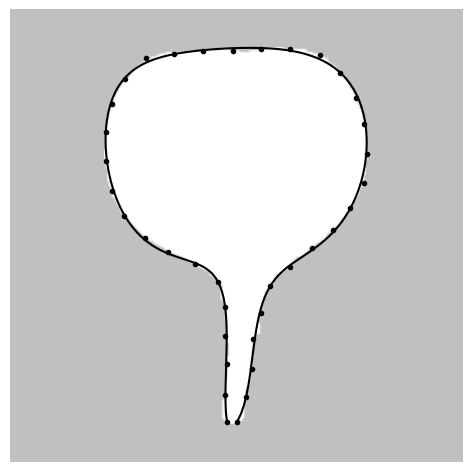

In [45]:
checkTo11(1,N=11,LR=0,Nsamples=37,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

....
CP 5.0, steps:3, etime: 4.14062 err: 4.4097589034
............
CP 2.0, steps:15, etime: 10.29688 err: 1.9099189333
.........E

TEST ./pics\Beztest.png


((0.9738680061066273, 0.9738680061066273),
 14.828125,
 25,
 [[149.0, 279.0],
  [85.02759627948987, 245.35685777341533],
  [259.21951523187454, 484.2494878430502],
  [-1179.591724005934, -657.4025612621367],
  [3871.9730423959945, 1263.252568496217],
  [-6070.203196781814, -1073.4974073330268],
  [6313.548483824952, 286.5168764931517],
  [-3416.551961062886, 240.58567689202565],
  [1340.00494454786, -154.62515620728678],
  [106.31892167198146, 369.4267126307408],
  [218.53678311009205, 249.5725396729465],
  [156.0, 281.0]])

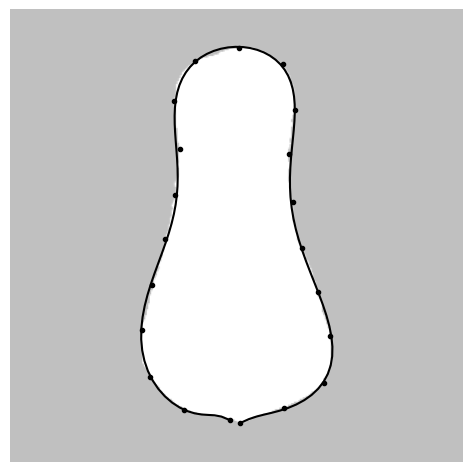

In [49]:
checkTo11(0,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...
CP 5.0, steps:2, etime: 4.14062 err: 4.7088751990
...........
CP 2.0, steps:13, etime: 10.34375 err: 1.8865387772
..........E

TEST ./pics\Beztest.png


((0.9574310112166602, 0.9574310112166602),
 16.046875,
 24,
 [[149.0, 279.0],
  [84.60693209133358, 254.73326877735536],
  [336.52636285295483, 435.4773529190706],
  [-1486.0904892385347, -468.546708570482],
  [4526.0554281897885, 999.7263570372521],
  [-7066.301129073961, -839.4043931559601],
  [7416.325869802748, 121.31095401699582],
  [-4265.586607087196, 331.97105535439],
  [1761.0783945035744, -178.41479658526634],
  [1.898588618990678, 383.84838222210806],
  [217.45129973794985, 249.6056271274357],
  [156.0, 281.0]])

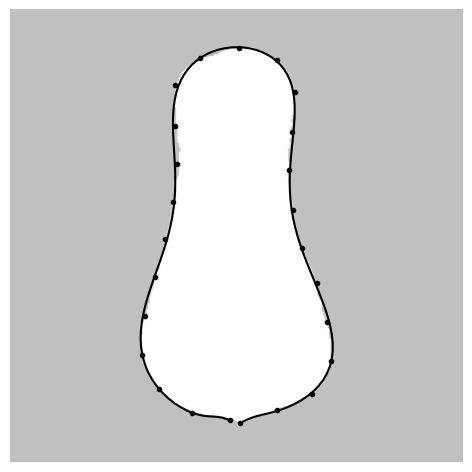

In [50]:
checkTo11(0,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 4.40625 err: 4.4000758610
............
CP 2.0, steps:13, etime: 12.73438 err: 1.9087087236
............E

TEST ./pics\Beztest.png


((0.9869270758308001, 0.9869270758308001),
 21.328125,
 26,
 [[149.0, 279.0],
  [93.30386459527146, 257.288596320922],
  [289.2662286133018, 416.7475736683052],
  [-1352.1497500355592, -415.4872136267064],
  [4260.47743063917, 917.9129412814982],
  [-6682.789730311668, -778.0848418723408],
  [7013.51168417643, 122.18472724306778],
  [-3950.8141040203805, 288.59997753043143],
  [1585.0471512695199, -141.65177226185622],
  [60.662599434057434, 356.92675512637544],
  [210.33554411757663, 256.93092863538703],
  [156.0, 281.0]])

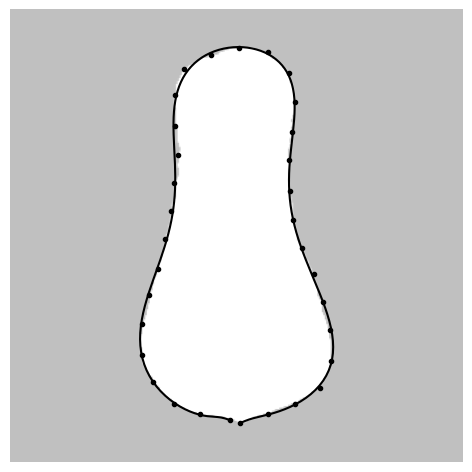

In [51]:
checkTo11(0,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...
CP 5.0, steps:2, etime: 6.06250 err: 4.8559059910
...............
CP 2.0, steps:17, etime: 18.56250 err: 1.9515593121
............E

TEST ./pics\Beztest.png


((0.9571512562354145, 0.9571512562354145),
 28.5625,
 30,
 [[149.0, 279.0],
  [97.46225434241387, 259.93210957168276],
  [283.35326962812263, 401.11301236505676],
  [-1365.9060864720761, -329.4729273963643],
  [4354.502336169267, 708.0588073476202],
  [-6880.52730684821, -637.4416579616819],
  [7266.569823364655, 229.5070746825312],
  [-4173.69905712626, 42.94293541404667],
  [1713.166988173965, 12.241124219036708],
  [25.9780796280797, 327.0211323386762],
  [207.91393683817088, 260.50258837822867],
  [156.0, 281.0]])

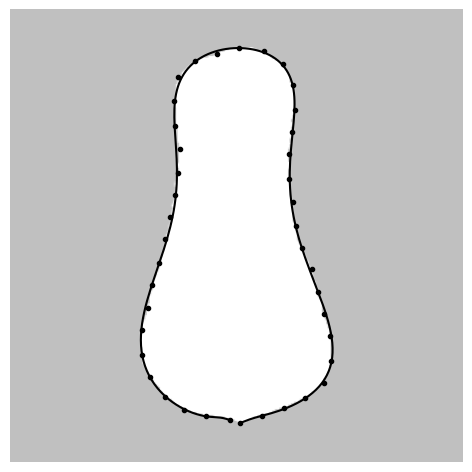

In [52]:
checkTo11(0,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...
CP 5.0, steps:2, etime: 3.67188 err: 2.5592985546
..
CP 2.0, steps:4, etime: 4.67188 err: 1.9873701375
....E

TEST ./pics\Beztest.png


((0.8757906080706099, 0.8757906080706099),
 6.703125,
 9,
 [[171.0, 277.0],
  [159.64341822363292, 65.38698132060988],
  [-1.511307486452098, 394.97514785615186],
  [755.1453251607875, -476.43132632180607],
  [-1315.3086474576467, 977.2391782679601],
  [2696.427164845949, -496.47664570965975],
  [-2390.6730585662817, -880.4910809023775],
  [1808.7513772416482, 1695.065145498474],
  [-685.1191678115515, -1098.2813508008262],
  [400.8443882603027, 690.5751836912666],
  [28.909652574338487, 24.593652425186388],
  [167.0, 281.0]])

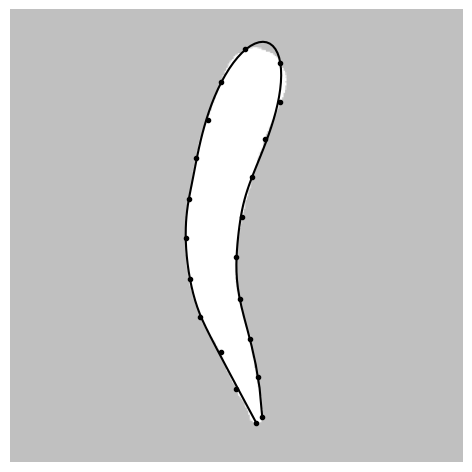

In [53]:
checkTo11(2,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 3.39062 err: 4.4226266583
....
CP 2.0, steps:5, etime: 5.82812 err: 1.5790737721
..........E

TEST ./pics\Beztest.png


((0.9688349237180521, 0.9688349237180521),
 11.484375,
 16,
 [[171.0, 277.0],
  [173.99982401960557, 230.13836856372282],
  [74.41677347845524, 142.96944856304347],
  [519.8602642500296, 277.92269984258263],
  [-1080.219047453805, -300.84810855247207],
  [2501.9846422390315, 1026.7018198475776],
  [-2131.3308971477877, -1956.4483178470573],
  [1511.5665291492483, 1805.9589998683964],
  [-447.3196058455696, -589.3501646257841],
  [221.559256490949, 313.54847813059354],
  [132.8800359651958, 234.6100564913055],
  [167.0, 281.0]])

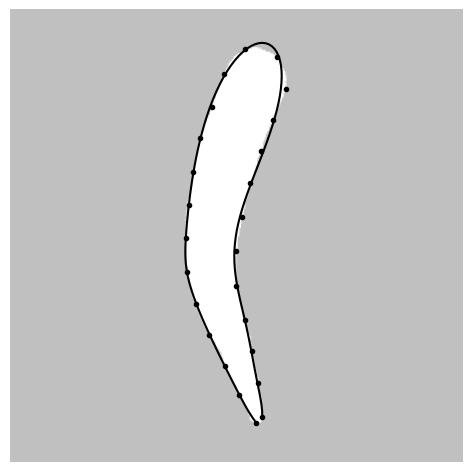

In [54]:
checkTo11(2,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 4.23438 err: 3.5575914854
..
CP 2.0, steps:3, etime: 5.62500 err: 1.9283977623
................E

TEST ./pics\Beztest.png


((0.9775040872963966, 0.9775040872963966),
 16.765625,
 20,
 [[171.0, 277.0],
  [173.22122937247786, 237.5249968274632],
  [87.58778202758192, 134.02390285620766],
  [493.0549721256164, 375.32779365090823],
  [-1062.3878896813374, -600.3069513642822],
  [2548.8814663451612, 1499.8757795400431],
  [-2258.288221103224, -2435.6935545527003],
  [1644.6503790621664, 2174.7854581850884],
  [-522.8069306965201, -801.0585130357555],
  [238.68016707146168, 384.44434287506095],
  [141.098877584185, 238.6233561008848],
  [167.0, 281.0]])

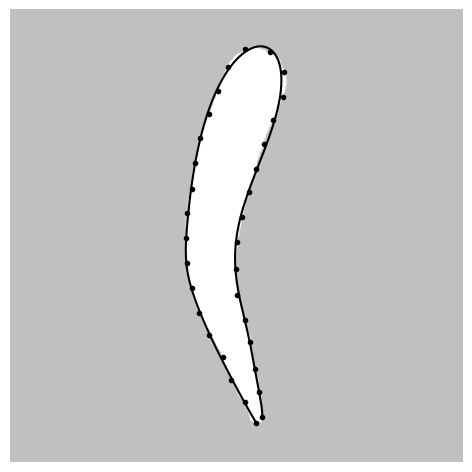

In [55]:
checkTo11(2,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 5.26562 err: 4.2551186039
...
CP 2.0, steps:4, etime: 7.71875 err: 1.9833899600
.................E

TEST ./pics\Beztest.png


((0.980110828631181, 0.980110828631181),
 21.796875,
 22,
 [[171.0, 277.0],
  [178.28519750788564, 239.0452336529487],
  [63.32122609198276, 101.71744469116682],
  [569.1722371644939, 512.7708208752132],
  [-1211.5660792650644, -912.2332418221648],
  [2742.7182230672975, 1921.5354997297168],
  [-2426.7414732801412, -2801.3236938146465],
  [1741.8238109361507, 2358.9869584707117],
  [-561.4706608150664, -825.9574421049234],
  [248.80198723783172, 371.7791715666461],
  [140.58694917809535, 246.00181598563887],
  [167.0, 281.0]])

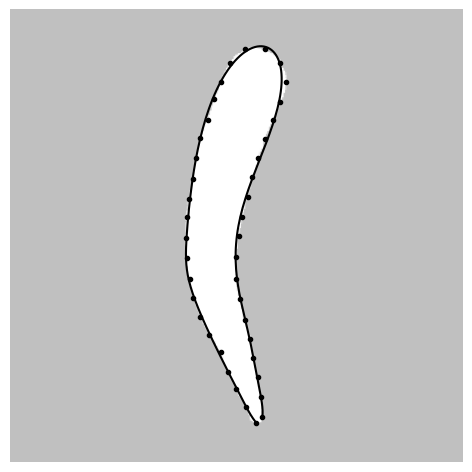

In [56]:
checkTo11(2,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 2.84375 err: 4.1026491665
.....
CP 2.0, steps:5, etime: 5.34375 err: 1.9815402960
....................E

TEST ./pics\Beztest.png


((0.9782837287858903, 0.9782837287858903),
 15.421875,
 26,
 [[161.0, 279.0],
  [184.18333354824605, 193.42670440713997],
  [56.74816199875182, -117.10092036812419],
  [620.0416632012967, 1235.8128565688294],
  [-1107.159236947889, -2312.8534618277868],
  [2644.1047490736023, 3386.7408158857934],
  [-2618.3010958951027, -3653.2831461431556],
  [1934.1814082377518, 2585.251389075287],
  [-641.2297728779516, -844.2739828081789],
  [313.78238972929176, 386.0546597911328],
  [119.06447620356525, 225.74465961076788],
  [154.0, 280.0]])

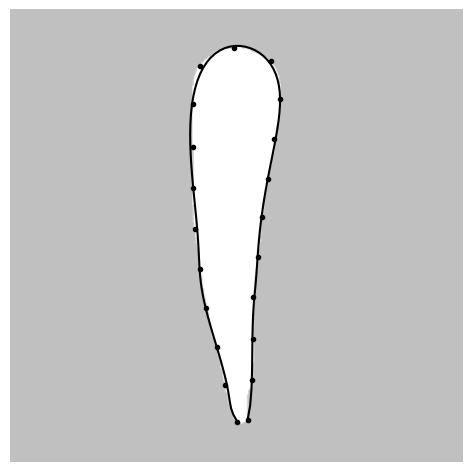

In [57]:
checkTo11(3,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.01562 err: 3.4383466186
...
CP 2.0, steps:3, etime: 4.68750 err: 1.9305910979
..........................E

TEST ./pics\Beztest.png


((0.9885504870174793, 0.9885504870174793),
 19.46875,
 30,
 [[161.0, 279.0],
  [176.30306058502384, 228.2600319650702],
  [77.9268784789304, 59.136370421039366],
  [599.1139293191776, 671.1519131719355],
  [-1138.8324504694153, -1105.4735518260072],
  [2640.9164962547165, 1752.4072274348655],
  [-2440.499120893758, -1971.4799454451481],
  [1708.4293283306567, 1264.5878490326672],
  [-516.2276564636389, -198.30904195581658],
  [283.8590067864964, 212.69614680695648],
  [116.90665639370185, 233.89611104443532],
  [154.0, 280.0]])

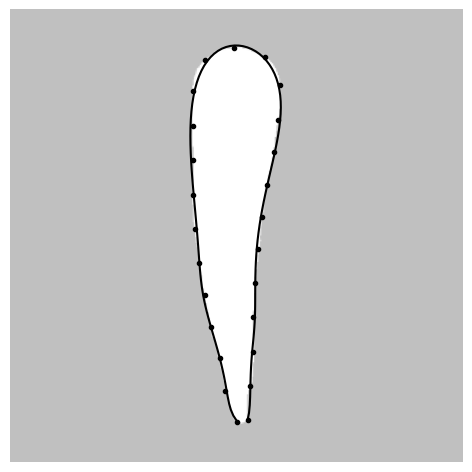

In [58]:
checkTo11(3,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.98438 err: 3.9095229647
......
CP 2.0, steps:6, etime: 8.17188 err: 1.9858457369
..................................E

TEST ./pics\Beztest.png


((0.9820217760740572, 0.9820217760740572),
 31.890625,
 41,
 [[161.0, 279.0],
  [167.94848595597904, 227.73298885320688],
  [130.43834315866357, 1.2058852197978454],
  [426.9866983443359, 987.9627609717003],
  [-770.0280134543847, -1826.2949330379765],
  [2107.903868082818, 2621.370313990259],
  [-1911.632138054322, -2601.3355004782543],
  [1347.1936234584746, 1541.0198092097478],
  [-349.95095296663675, -273.48828781521775],
  [236.50331627758658, 226.26515625994534],
  [125.10552902266251, 240.7987373151119],
  [154.0, 280.0]])

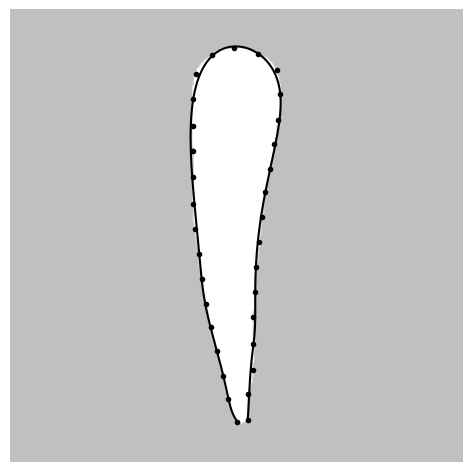

In [59]:
checkTo11(3,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 4.45312 err: 3.7844563048
..........
CP 2.0, steps:10, etime: 12.68750 err: 1.9856754097
...................................E

TEST ./pics\Beztest.png


((0.9813798904504292, 0.9813798904504292),
 41.828125,
 46,
 [[161.0, 279.0],
  [171.18741968735756, 234.6257364228655],
  [110.24635125073229, 8.40501627689211],
  [493.74316247205303, 892.9722099978761],
  [-923.668958541696, -1510.5389930559784],
  [2358.642608191142, 2044.598831870962],
  [-2198.037049907265, -1934.015130977737],
  [1568.5353385912385, 1027.031790373598],
  [-465.25950837836535, -21.006540176052173],
  [275.6782147434434, 159.87120458903706],
  [117.59853201959282, 243.8887599978183],
  [154.0, 280.0]])

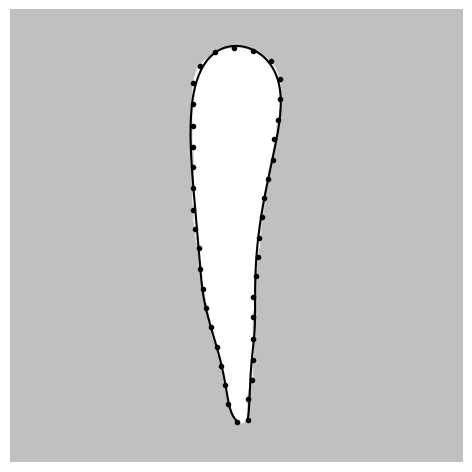

In [60]:
checkTo11(3,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 2.68750 err: 2.4062495940
^....
CP 2.0, steps:5, etime: 5.17188 err: 1.9154947623
.......................................E

TEST ./pics\Beztest.png


((0.9989120835308246, 0.9989120835308246),
 24.796875,
 45,
 [[150.0, 279.0],
  [138.43048008654384, 224.62703939788227],
  [138.31816650870212, 137.74151336111223],
  [-409.69829010740716, 683.130602360846],
  [1506.784639697877, -1445.9918993918577],
  [-2083.15090247574, 2097.4032908012],
  [2015.5817678172161, -1975.3287951463913],
  [-495.4594320385868, 1183.3802654035321],
  [229.45283422158093, -372.90374679949764],
  [320.84826753833795, 363.057903879217],
  [164.64145434280434, 196.38704104592483],
  [156.0, 279.0]])

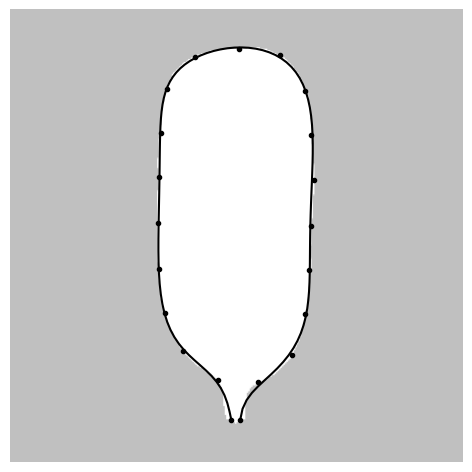

In [61]:
checkTo11(5,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.01562 err: 1.9952886710
.
CP 2.0, steps:1, etime: 3.57812 err: 1.8374569447
^..^.......................E

TEST ./pics\Beztest.png


((0.9901612019280974, 0.9901612019280974),
 18.9375,
 29,
 [[150.0, 279.0],
  [128.46677984725073, 233.6987841959747],
  [291.7463588640077, 239.24216988116763],
  [-955.793336141923, 153.29943681612664],
  [2685.9327259403185, -84.1473677812896],
  [-3844.538621092236, 274.2697644274899],
  [3833.7951099134857, -497.08897797631863],
  [-1755.4928036813228, 408.5598524887811],
  [804.178149748448, -82.18014883125912],
  [175.5370214670925, 321.4302207141097],
  [163.74050915375562, 214.10206543144534],
  [156.0, 279.0]])

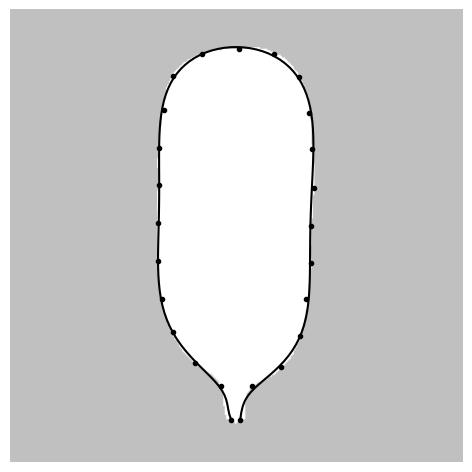

In [62]:
checkTo11(5,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.78125 err: 1.4528722145
^
CP 2.0, steps:1, etime: 4.48438 err: 1.4590533620
.............E

TEST ./pics\Beztest.png


((0.9845824887511404, 0.9845824887511404),
 13.9375,
 15,
 [[150.0, 279.0],
  [134.52145866646114, 232.14716011725912],
  [205.10804057025962, 187.20256777215255],
  [-682.9397479040347, 326.38813196279045],
  [2193.600516503371, -451.43725970682664],
  [-3259.5522776085527, 901.715363994643],
  [3336.730352873756, -1278.4585896683197],
  [-1410.3708177794042, 1035.9934341501387],
  [611.1305838195328, -353.3054123531435],
  [247.58897418074312, 369.01485596176946],
  [153.28384573417355, 211.9710054735313],
  [156.0, 279.0]])

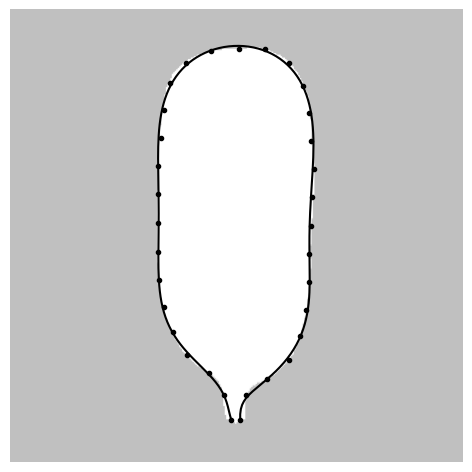

In [63]:
checkTo11(5,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 4.43750 err: 1.7465030988
^
CP 2.0, steps:1, etime: 5.25000 err: 1.7823162910
.......................E

TEST ./pics\Beztest.png


((0.9952513263082753, 0.9952513263082753),
 24.546875,
 25,
 [[150.0, 279.0],
  [121.41790843920677, 222.8902563895545],
  [284.8288576521277, 214.40655723952003],
  [-888.713656606485, 359.7328683217512],
  [2532.934123797173, -626.9864024369466],
  [-3646.7463418991774, 1100.2662349506966],
  [3663.2778100563387, -1327.8681475359942],
  [-1636.0978693792397, 949.901187649072],
  [740.8458028752879, -282.7589131196514],
  [192.22872283264843, 365.92260916109205],
  [165.09004717260385, 206.8391257366032],
  [156.0, 279.0]])

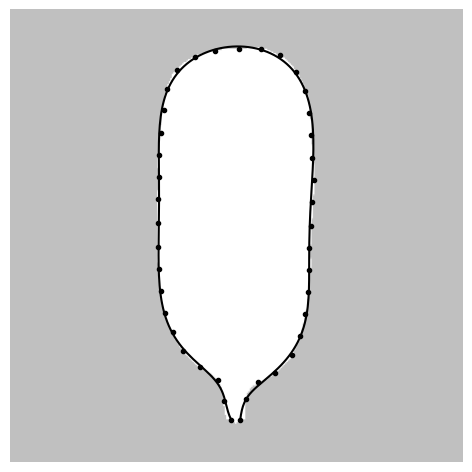

In [68]:
checkTo11(5,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 2.89062 err: 2.7345359623
...
CP 2.0, steps:3, etime: 4.40625 err: 1.7449671908
..........E

TEST ./pics\Beztest.png


((0.9856931895129264, 0.9856931895129264),
 9.484375,
 14,
 [[166.0, 279.0],
  [141.03673066003816, 135.7109541755406],
  [273.14028015673483, 134.68543429266114],
  [136.48969823220293, 246.80938676232765],
  [-188.35789030632483, -7.068658641027835],
  [1240.2580013337486, -137.33408736022983],
  [-1119.6846299618762, -176.28020256953576],
  [861.20141157866, 432.36294937973946],
  [-109.74771605122055, -22.036821382433605],
  [145.47237903589019, 197.51096082050927],
  [140.21973269987754, 211.55086771499734],
  [159.0, 280.0]])

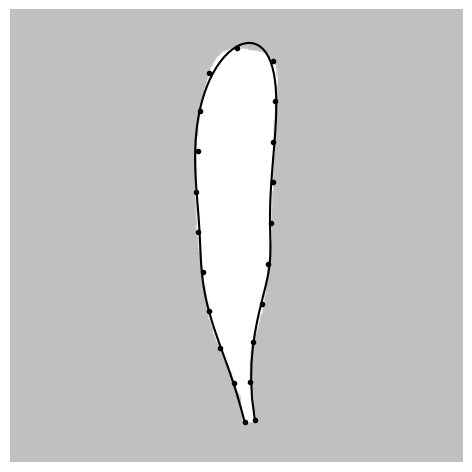

In [64]:
checkTo11(8,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 3.62500 err: 3.5894532699
..
CP 2.0, steps:3, etime: 4.75000 err: 1.7689375572
...^.....................E

TEST ./pics\Beztest.png


((0.9977237780074149, 0.9977237780074149),
 19.0,
 29,
 [[166.0, 279.0],
  [177.64233653447096, 228.6778803837508],
  [-37.147350663660475, 204.0222349701627],
  [1051.1898149642414, -52.24444095083129],
  [-1828.35112314301, 557.65365661193],
  [3154.575175872295, -282.11579619083903],
  [-2572.7781477404033, -643.752019840119],
  [1630.991980235216, 955.5330670673932],
  [-397.92944669515896, -299.0894732934638],
  [207.79536014702865, 281.77429267549377],
  [145.77565080549994, 232.65702892588266],
  [159.0, 280.0]])

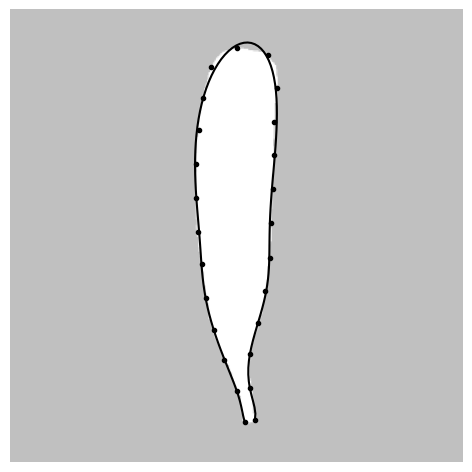

In [65]:
checkTo11(8,N=11,LR=0,Nsamples=25,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.75000 err: 4.0955250863
..
CP 2.0, steps:2, etime: 5.15625 err: 1.7954673671
..^...........................E

TEST ./pics\Beztest.png


((0.9954627877089371, 0.9954627877089371),
 26.421875,
 33,
 [[166.0, 279.0],
  [184.11292267550445, 229.99105565054492],
  [-72.8199437956429, 130.20697100281566],
  [1142.3994221580795, 333.224916304472],
  [-1983.8398121981206, -367.79011273321584],
  [3342.0754982393933, 1012.8238871415924],
  [-2731.1804422912505, -1765.4762789242416],
  [1726.5838526563614, 1550.940095009419],
  [-433.59387221408167, -481.81072159396564],
  [210.08008058912722, 306.6023789929471],
  [149.7802928102712, 235.11208863599148],
  [159.0, 280.0]])

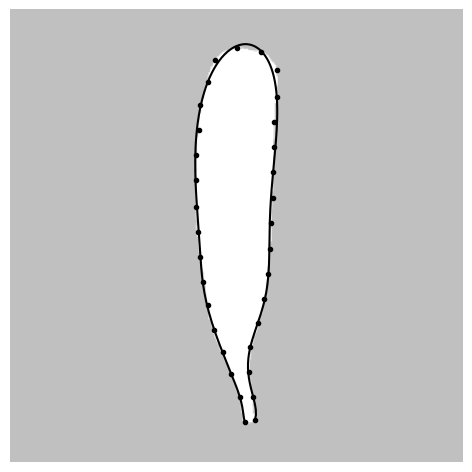

In [66]:
checkTo11(8,N=11,LR=0,Nsamples=33,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 4.45312 err: 4.3091991442
...
CP 2.0, steps:3, etime: 6.96875 err: 1.7835255488
.......................................................................E

TEST ./pics\Beztest.png


((0.9996451895718276, 0.9996451895718276),
 66.34375,
 75,
 [[166.0, 279.0],
  [176.32744311136872, 231.51096825307178],
  [-12.611426144152302, 66.51378674368398],
  [928.8471185635586, 631.5556648327916],
  [-1532.2971261975351, -1000.4884934788911],
  [2714.223541010584, 1663.6864358718824],
  [-2147.604595107206, -2048.2271551344643],
  [1368.4297950992204, 1462.4101167074316],
  [-297.458707485779, -327.2895699955696],
  [187.31900652519, 256.7437304463624],
  [148.6399659415809, 240.03687977326197],
  [159.0, 280.0]])

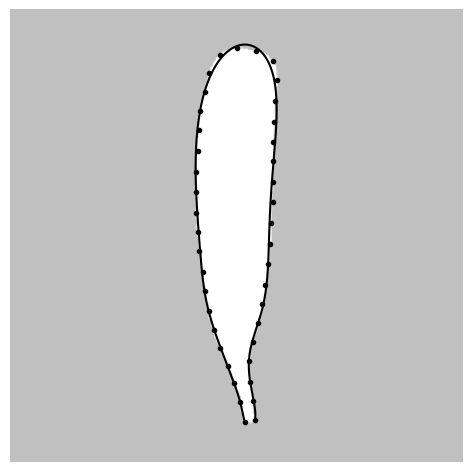

In [67]:
checkTo11(8,N=11,LR=0,Nsamples=41,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 3.00000 err: 4.6687289192
....
CP 2.0, steps:5, etime: 5.00000 err: 1.8168517181
.....E

TEST ./pics\Beztest.png


((0.9855352272992766, 0.9855352272992766),
 7.53125,
 11,
 [[168.0, 279.0],
  [250.58763396932198, -29.882392199592076],
  [53.32892560215316, 815.8406736591123],
  [477.9560811426161, -1608.608716726982],
  [-309.6278857561392, 2900.9143920676797],
  [898.550571205816, -2922.076787172456],
  [-622.9110117069732, 1339.840739097013],
  [683.9923615467221, 308.4270718462862],
  [-267.66330110539275, -545.5350126656855],
  [338.1050519844756, 575.7050591900069],
  [8.529241932060524, 34.68580832830634],
  [161.0, 281.0]])

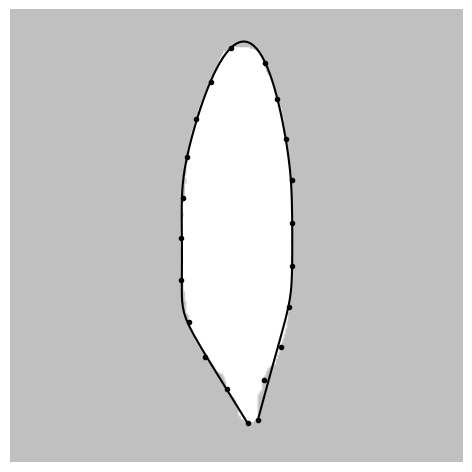

In [70]:
checkTo11(7,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

In [ ]:
checkTo11(1,N=11,LR=0,Nsamples=21,mode=1,err_th=1,pat=2000,maxTry=4000,lr=0.001)

..
CP 5.0, steps:1, etime: 7.68750 err: 4.3233406656
...........
CP 2.0, steps:12, etime: 21.15625 err: 1.8731054444
..........E

TEST ./pics\Beztest.png


((0.9889811619287606, 0.9889811619287606),
 33.65625,
 23,
 [[149.0, 279.0],
  [10.141120180462035, 248.42609696827972],
  [575.596976328044, 409.8992566484601],
  [-2007.0822754074275, -376.3177681720801],
  [5435.592302531808, 830.8146409076389],
  [-8360.677651666565, -647.3773978842395],
  [8886.361717037213, -60.87374146806674],
  [-5527.706454993747, 494.94011850683586],
  [2556.4604319044524, -300.12378198725213],
  [-351.3360677194967, 455.4298043449477],
  [313.46033629547725, 224.62854043243422],
  [156.0, 281.0]])

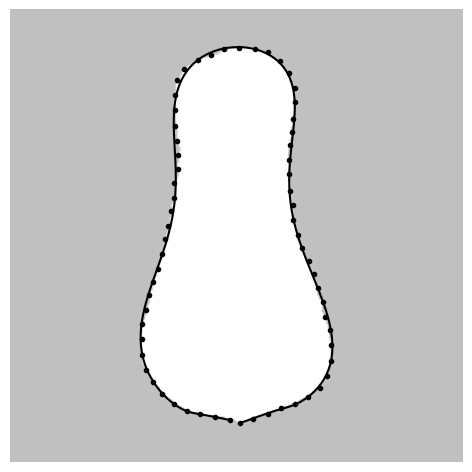

In [71]:
checkTo11(0,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

....
CP 5.0, steps:3, etime: 10.40625 err: 4.8951966090
................................................................
CP 2.0, steps:67, etime: 88.32812 err: 1.9889341418
................................
...............................................................E

TEST ./pics\Beztest.png


((0.9929871213929323, 0.9929871213929323),
 204.984375,
 163,
 [[147.0, 280.0],
  [116.40159625522799, 245.31836722189004],
  [408.265311569202, -464.21625756259056],
  [-845.970835073678, 1875.5520953734028],
  [1355.775887994247, -2570.9639688261013],
  [-1384.1602795157455, 1926.4860570925282],
  [1318.8935389404949, -161.37794211701535],
  [-342.5876262654585, -1229.8645390815202],
  [651.9282756565946, 1348.6637819842765],
  [58.311600833569436, -363.84594220663035],
  [195.8326538444004, 251.86059169792014],
  [154.0, 280.0]])

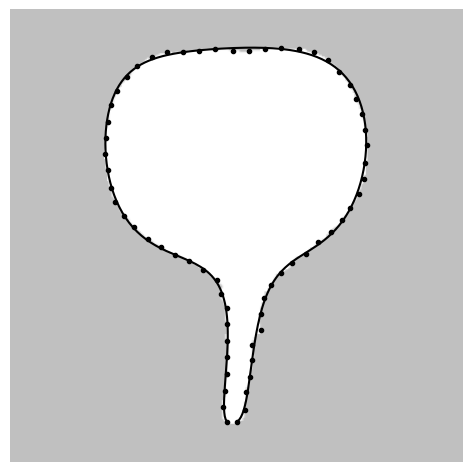

In [72]:
checkTo11(1,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 7.62500 err: 3.2957069130
...
CP 2.0, steps:4, etime: 11.28125 err: 1.8521162678
...............E

TEST ./pics\Beztest.png


((0.9879633344197785, 0.9879633344197785),
 29.640625,
 20,
 [[171.0, 277.0],
  [182.9138025936632, 247.9354856625446],
  [24.50708761556562, 45.0932054373554],
  [695.0593268498684, 648.5705907579992],
  [-1500.7273231744107, -1152.5351291326642],
  [3249.4498549483123, 2293.1039343533703],
  [-3076.1182035148504, -3340.301981233949],
  [2337.622025948462, 2992.7147814569694],
  [-952.0251999781239, -1340.275822554439],
  [422.0982104274778, 631.9692779422649],
  [97.92284972334896, 177.65093777247836],
  [167.0, 281.0]])

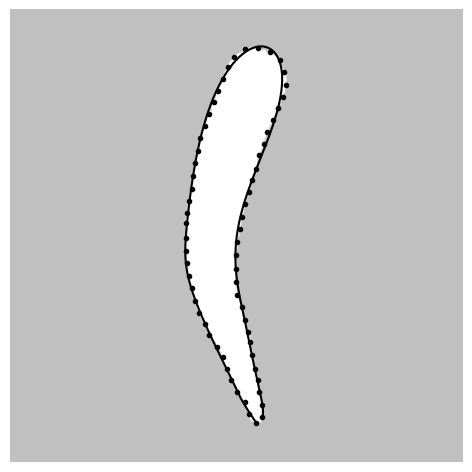

In [73]:
checkTo11(2,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 6.60938 err: 4.0805236597
...........
CP 2.0, steps:11, etime: 20.29688 err: 1.9728524205
.................................E

TEST ./pics\Beztest.png


((0.9877075446895006, 0.9877075446895006),
 60.84375,
 45,
 [[161.0, 279.0],
  [170.30570504003097, 256.7271383639235],
  [120.93003201037408, -154.189552248802],
  [455.11196417814, 1404.9161965207002],
  [-851.0617904681692, -2503.5299504429536],
  [2285.067184294162, 3394.931025263811],
  [-2170.7828688490927, -3295.383441921899],
  [1586.718044223877, 2029.862486672312],
  [-491.8093622144469, -516.8254014356291],
  [287.4215505311402, 302.79401969063736],
  [115.54610327073539, 225.66360025617232],
  [154.0, 280.0]])

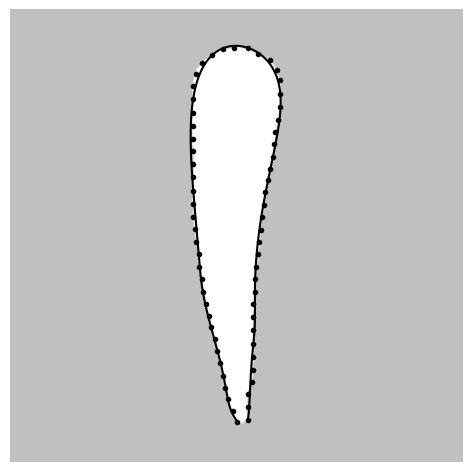

In [74]:
checkTo11(3,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.........
CP 5.0, steps:8, etime: 16.29688 err: 4.8355238879
.............................................
CP 2.0, steps:53, etime: 71.54688 err: 1.9980713601
..............................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.........................E

TEST ./pics\Beztest.png


((0.9988864464539653, 0.9988864464539653),
 649.234375,
 525,
 [[148.0, 279.0],
  [150.2170672150591, 245.5212554412432],
  [175.9361067940408, -671.6616978573255],
  [-47.53598341892535, 2752.1927802560945],
  [-117.60203976360707, -4664.669923887929],
  [629.6875704703207, 5372.911109230956],
  [-606.4746686769704, -4160.7983548893535],
  [1136.968498976643, 1772.7695874343897],
  [-168.13635277349346, 158.03642923517762],
  [225.65720108758336, -85.79679354289173],
  [167.25128755653864, 216.39953880397138],
  [154.0, 280.0]])

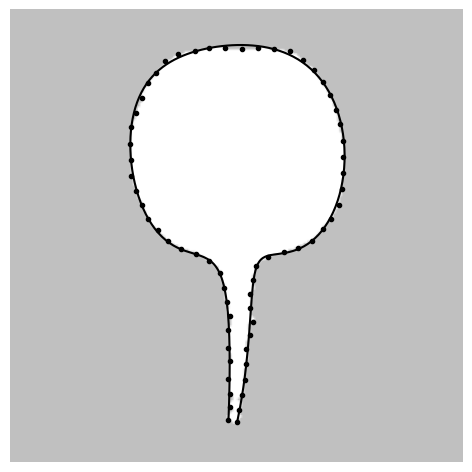

In [75]:
checkTo11(4,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 6.78125 err: 1.6660604693
.
CP 2.0, steps:1, etime: 8.26562 err: 1.6235963978
............E

TEST ./pics\Beztest.png


((0.9852775711702368, 0.9852775711702368),
 23.109375,
 14,
 [[150.0, 279.0],
  [117.36932088962634, 200.9475150017517],
  [293.0214518910286, 304.47472407353234],
  [-949.0732935887353, 137.36643435780414],
  [2757.166144653791, -429.7995482531295],
  [-4125.389189111868, 1327.0850198023006],
  [4304.7003501546005, -2159.9678838067875],
  [-2183.0318406769493, 2012.7492974977781],
  [1050.447975992292, -1013.0314828674443],
  [79.82485460121828, 645.6651022685384],
  [187.3316797519954, 152.5660065693555],
  [156.0, 279.0]])

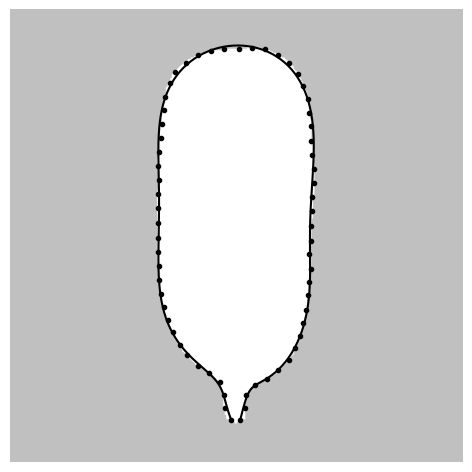

In [76]:
checkTo11(5,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

...
CP 5.0, steps:2, etime: 9.09375 err: 4.4061264930
................
CP 2.0, steps:18, etime: 28.68750 err: 1.9945074769
......................................E

TEST ./pics\Beztest.png


((0.9900732049598819, 0.9900732049598819),
 75.109375,
 57,
 [[138.0, 279.0],
  [159.33422398539057, 126.98348434961206],
  [176.1280655773649, 666.0763322390384],
  [-1220.8682457399177, -649.527129656151],
  [3989.7406887973025, 1085.6879986078243],
  [-6430.510391136603, -1302.964010262449],
  [7281.434982235361, 1237.4104012932148],
  [-4942.793962508186, -970.1999733792211],
  [2725.8136944357548, 570.0263398176915],
  [-451.43811382077115, 305.04369663492537],
  [264.52419656856466, 179.28623953642193],
  [144.0, 281.0]])

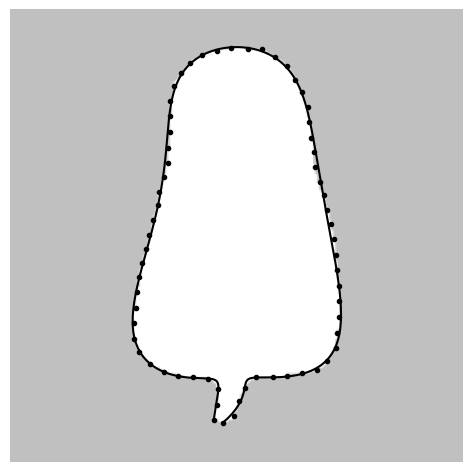

In [77]:
checkTo11(6,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 6.56250 err: 3.3291815961
.
CP 2.0, steps:1, etime: 7.78125 err: 1.8095457198
...E

TEST ./pics\Beztest.png


((0.9007830202221052, 0.9007830202221052),
 11.46875,
 5,
 [[168.0, 279.0],
  [161.0191152134673, 170.96905965139567],
  [208.5351170651821, 608.837994819988],
  [409.9627386467147, -1218.3686394842887],
  [-588.9433120064045, 2674.50512236623],
  [1685.8745110950038, -2917.1085704723923],
  [-1590.742328217841, 1552.2705294893242],
  [1344.4273998853873, -136.83083214396984],
  [-473.5847696600189, -62.239587893953],
  [262.65823246256394, 341.37749592307745],
  [112.5551325558496, 208.16975824640295],
  [161.0, 281.0]])

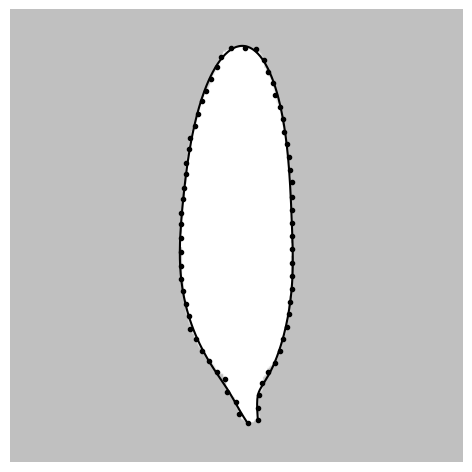

In [78]:
checkTo11(7,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 6.53125 err: 4.0914453585
..
CP 2.0, steps:2, etime: 8.96875 err: 1.9177060332
........................................................E

TEST ./pics\Beztest.png


((0.9983217210753271, 0.9983217210753271),
 77.53125,
 59,
 [[166.0, 279.0],
  [180.02732096544605, 251.4816928731469],
  [-38.138948442186994, -11.893249035111513],
  [1031.7107062279863, 757.2607851524235],
  [-1763.2201230648564, -1106.3471936573476],
  [3043.896050335195, 1723.2600236668143],
  [-2454.4431869453797, -2090.699175329309],
  [1550.413783657147, 1518.3367675166417],
  [-361.87171987290344, -378.3047077921251],
  [197.49433159118774, 277.6633728248823],
  [149.32417793531914, 236.98687791062972],
  [159.0, 280.0]])

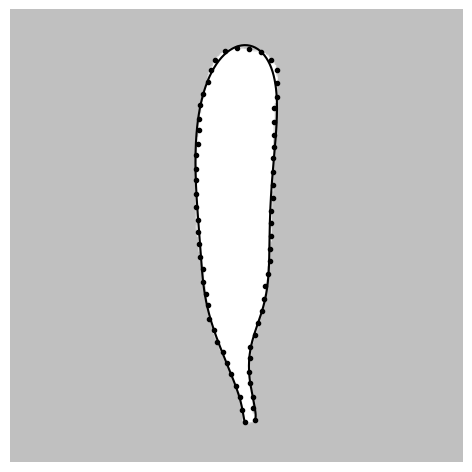

In [79]:
checkTo11(8,N=11,LR=0,Nsamples=65,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 3.98438 err: 4.7326268604
................
CP 2.0, steps:17, etime: 14.10938 err: 1.9545873529
............E

TEST ./pics\Beztest.png


((0.9886146175881628, 0.9886146175881628),
 21.734375,
 30,
 [[149.0, 279.0],
  [90.0320610858583, 259.6886608931541],
  [293.6367321863664, 401.2710443315531],
  [-1322.9114980966026, -343.1011331197508],
  [4121.900700953644, 787.0068107035843],
  [-6377.672580911962, -719.5574641071177],
  [6621.295096817635, 241.46081968093736],
  [-3651.814346701253, 70.58795454058692],
  [1454.7320691445923, 8.542905455293704],
  [85.32729245679855, 314.6932128181508],
  [212.60750558570376, 259.17574960479055],
  [156.0, 281.0]])

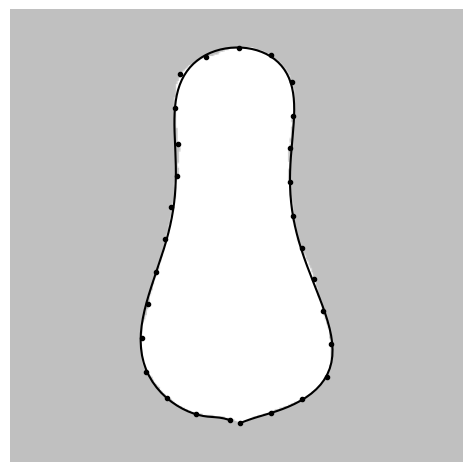

In [81]:
checkTo11(0,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 4.01562 err: 4.3597791738
...
CP 2.0, steps:4, etime: 5.90625 err: 1.9169046755
..............E

TEST ./pics\Beztest.png


((0.9964446761521977, 0.9964446761521977),
 15.03125,
 19,
 [[171.0, 277.0],
  [178.4355654793376, 235.58980127557984],
  [54.83387811098869, 161.85765839933308],
  [615.6851464148242, 272.7579586532118],
  [-1337.0978906059534, -424.50353601607145],
  [2953.0195694577687, 1351.0823909469952],
  [-2678.742467156889, -2414.3051493191933],
  [1958.21142219521, 2246.8349651524986],
  [-686.8952385610995, -861.1202171149564],
  [293.0478791987485, 402.7344787884794],
  [132.55351200403783, 237.6594401713164],
  [167.0, 281.0]])

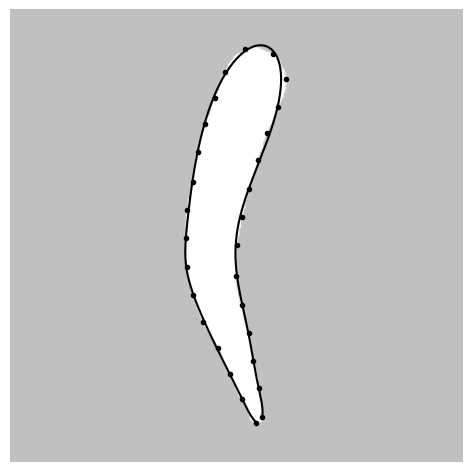

In [82]:
checkTo11(2,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.39062 err: 4.4880820481
.........
CP 2.0, steps:9, etime: 9.07812 err: 1.9764551671
...................................E

TEST ./pics\Beztest.png


((0.9871934999992203, 0.9871934999992203),
 31.15625,
 45,
 [[161.0, 279.0],
  [170.33005193377522, 224.14500665019713],
  [125.49934497838672, -15.736334434050361],
  [418.24472959161665, 1142.3690782652222],
  [-725.7097867920278, -2224.788971464614],
  [2045.152482074282, 3184.7696219743925],
  [-1873.2444931673078, -3126.7716610099496],
  [1340.4084538864463, 1884.5805642682574],
  [-354.6640986731057, -430.70562203900147],
  [236.89943442235648, 263.9018507267228],
  [127.44853069272277, 237.12456114912436],
  [154.0, 280.0]])

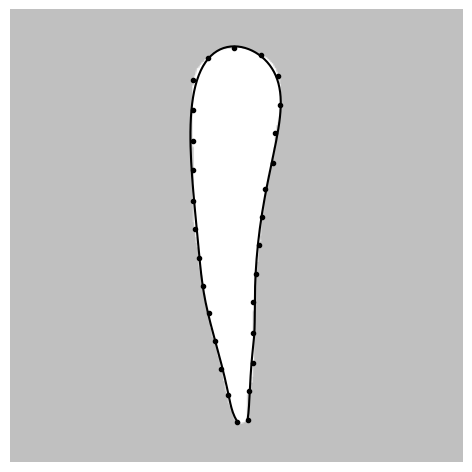

In [83]:
checkTo11(3,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.37500 err: 1.9215542114
.
CP 2.0, steps:1, etime: 4.01562 err: 1.8502324412
..^...................E

TEST ./pics\Beztest.png


((0.9854905026533315, 0.9854905026533315),
 18.125,
 24,
 [[150.0, 279.0],
  [132.47346414747278, 235.59494400744202],
  [226.72261648205972, 157.43136092227112],
  [-741.7477325323973, 484.3673658723095],
  [2306.9718910442707, -805.6265886164979],
  [-3434.3916830774106, 1346.4983113729963],
  [3539.942735041008, -1629.8355126360884],
  [-1587.2168787496787, 1226.4136706173501],
  [721.8736456665248, -436.6407365800046],
  [205.5269204273267, 396.7091176576256],
  [158.32694710666942, 209.73469407088646],
  [156.0, 279.0]])

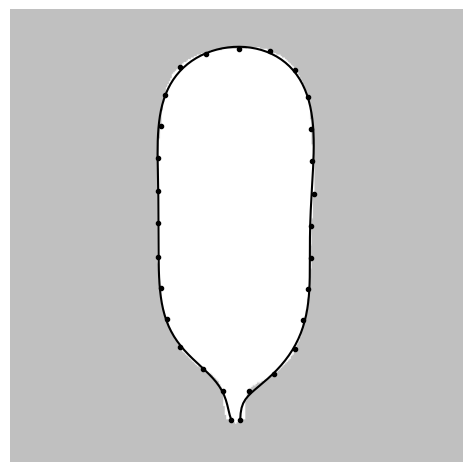

In [84]:
checkTo11(5,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.37500 err: 3.9499707671
..
CP 2.0, steps:2, etime: 4.62500 err: 1.6790655616
..E

TEST ./pics\Beztest.png


((0.9394364977321463, 0.9394364977321463),
 5.9375,
 5,
 [[168.0, 279.0],
  [165.13331477645283, 220.33350356174012],
  [172.73085967394397, 430.60767412425594],
  [504.4839433909834, -832.6165499530572],
  [-722.9814989339325, 2147.8308550282554],
  [1780.77899409735, -2461.6474421908497],
  [-1573.6695393957011, 1369.0788661876852],
  [1235.245338144342, -218.62149490611256],
  [-348.6758504616347, 94.82678567820257],
  [185.16621512594784, 237.0505649742387],
  [136.835622744715, 239.2927334911826],
  [161.0, 281.0]])

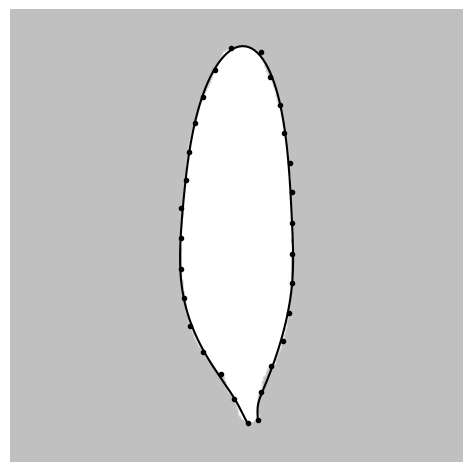

In [85]:
checkTo11(7,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 3.40625 err: 4.8855686756
...
CP 2.0, steps:3, etime: 5.31250 err: 1.7433450188
............................E

TEST ./pics\Beztest.png


((0.9986015551413316, 0.9986015551413316),
 23.109375,
 32,
 [[166.0, 279.0],
  [180.84362760830888, 229.2585714786611],
  [-53.536599574304056, 170.9836299140426],
  [1084.9401887369584, 130.57304093989436],
  [-1872.8905257467547, 161.753328710277],
  [3196.1481408265395, 220.2712280647632],
  [-2607.1105369589245, -1055.7143716874189],
  [1653.5092200552435, 1180.462756829135],
  [-401.39559624130715, -387.196635157368],
  [198.83893558149563, 305.2917408502287],
  [152.4801454264126, 232.90091155720418],
  [159.0, 280.0]])

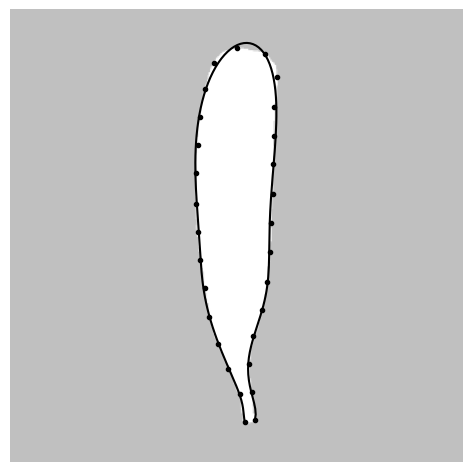

In [86]:
checkTo11(8,N=11,LR=0,Nsamples=29,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 6.51562 err: 4.8698518114
............
CP 2.0, steps:13, etime: 18.45312 err: 1.9935821532
............E

TEST ./pics\Beztest.png


((0.9603977956415831, 0.9603977956415831),
 30.46875,
 26,
 [[149.0, 279.0],
  [62.57337251658132, 251.91527479784315],
  [391.7735018195859, 428.0978268412938],
  [-1599.414763796595, -440.1672084135731],
  [4768.755134370143, 954.3451189838681],
  [-7505.060303667362, -848.3539568386587],
  [8023.27413741739, 202.33228071925777],
  [-4874.6975563458545, 244.58454181139376],
  [2201.4770677400934, -147.3864760770955],
  [-218.38074699864285, 401.37548334321065],
  [283.51495861764283, 236.06432115174835],
  [156.0, 281.0]])

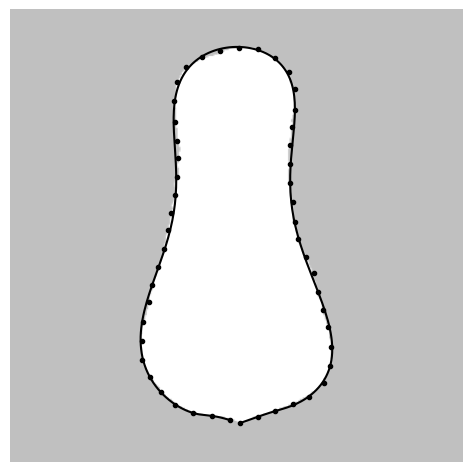

In [87]:
checkTo11(0,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

......
CP 5.0, steps:5, etime: 10.34375 err: 4.7473851113
.......................................................................
CP 2.0, steps:76, etime: 81.31250 err: 1.9924297355
.......................
...................................................................E

TEST ./pics\Beztest.png


((0.9960027464912606, 0.9960027464912606),
 171.234375,
 167,
 [[147.0, 280.0],
  [118.9221111428215, 219.0263208962724],
  [375.80143387916326, -410.8707910334281],
  [-788.5671663451458, 1827.03205926066],
  [1361.234166955159, -2609.4419248385843],
  [-1567.8082693041365, 2151.314071888402],
  [1659.183149631118, -576.5730978013225],
  [-640.9340177910959, -778.365418339426],
  [796.4701371595285, 1046.662404761289],
  [25.599527672970503, -243.44228973073604],
  [200.23109155690935, 222.26817562163583],
  [154.0, 280.0]])

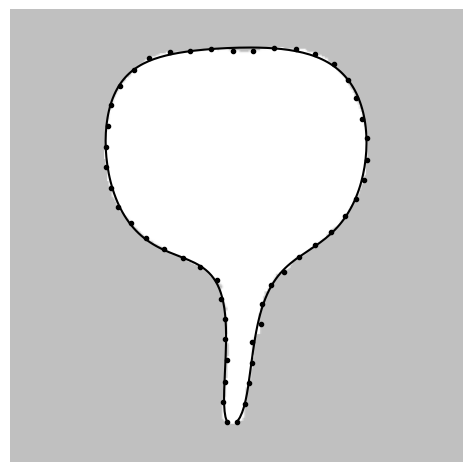

In [88]:
checkTo11(1,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 6.34375 err: 4.3072100445
.....
CP 2.0, steps:6, etime: 11.53125 err: 1.9726647198
.......................................E

TEST ./pics\Beztest.png


((0.9992284758560054, 0.9992284758560054),
 50.390625,
 46,
 [[171.0, 277.0],
  [173.28895362086487, 231.79031870428167],
  [72.11488536025276, 6.824501017494949],
  [551.5231255231334, 1029.4719454781296],
  [-1169.915838037507, -2113.0270115631074],
  [2690.1670107699174, 3575.0404402200265],
  [-2401.2663375677625, -4323.072721896503],
  [1778.3715086248817, 3326.9588500207246],
  [-630.3348617517948, -1260.9642834753315],
  [296.19505835559545, 517.0450592179873],
  [126.81461142026042, 215.49180042669855],
  [167.0, 281.0]])

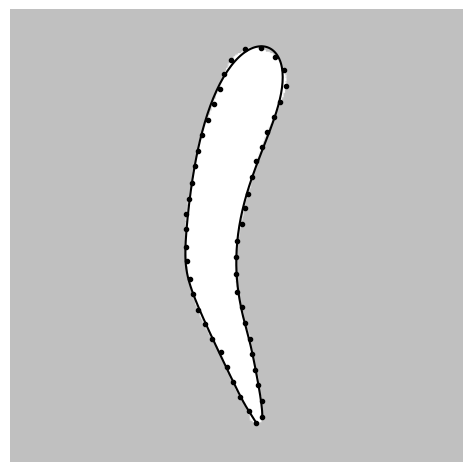

In [89]:
checkTo11(2,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 5.35938 err: 3.5680681932
.........
CP 2.0, steps:9, etime: 14.35938 err: 1.9553863355
................................E

TEST ./pics\Beztest.png


((0.9947573313070339, 0.9947573313070339),
 46.53125,
 42,
 [[161.0, 279.0],
  [172.37819141968762, 243.72090981782281],
  [112.79155014322995, -76.0962824320016],
  [466.3306741900234, 1193.7836722439738],
  [-841.3939207781145, -2162.520861120237],
  [2234.61847810682, 2993.277238722593],
  [-2089.152276976468, -2890.6220652771085],
  [1506.4452497968268, 1682.0028155530333],
  [-440.46680409997805, -291.550956634846],
  [266.79728918217813, 202.136811688921],
  [120.83510835858787, 250.29550107721346],
  [154.0, 280.0]])

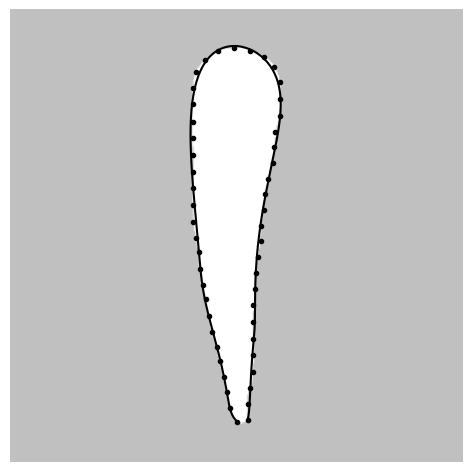

In [90]:
checkTo11(3,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.........
CP 5.0, steps:8, etime: 13.23438 err: 4.8324414172
...............................
CP 2.0, steps:39, etime: 44.03125 err: 1.9906737480
............................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............E

TEST ./pics\Beztest.png


((0.9992435557248336, 0.9992435557248336),
 418.171875,
 414,
 [[148.0, 279.0],
  [138.84647871771057, 206.76282301935498],
  [278.3219437716714, -481.2729752966904],
  [-511.62070207040244, 2184.17058384026],
  [1109.7807637524177, -3629.213485332322],
  [-1358.2877757086148, 4360.460144341772],
  [1366.2797878108704, -3643.6706855420853],
  [-138.78367565383428, 1708.3464768584263],
  [369.57801326382156, 90.47019179055384],
  [88.80285597640444, -48.283039014731315],
  [184.14894624475025, 210.06529361430006],
  [154.0, 280.0]])

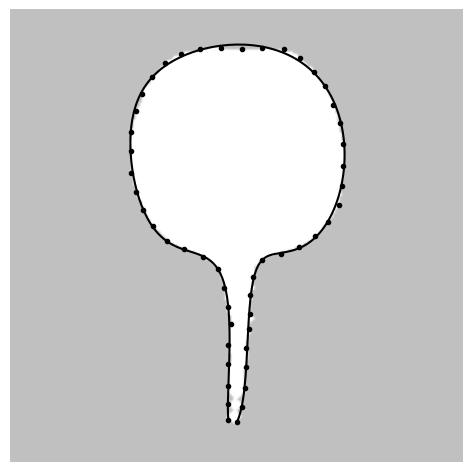

In [91]:
checkTo11(4,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 5.56250 err: 1.9512172870
.
CP 2.0, steps:1, etime: 6.57812 err: 1.8593697348
...................E

TEST ./pics\Beztest.png


((0.982105131579907, 0.982105131579907),
 25.65625,
 21,
 [[150.0, 279.0],
  [113.75351154311372, 205.74454410756385],
  [315.6367270164725, 263.26842546364077],
  [-987.566446146639, 324.8854114806733],
  [2769.53514027225, -814.7952234388991],
  [-4053.060754989039, 1752.9458016189858],
  [4148.260463437876, -2394.6060527528775],
  [-2038.5279360663023, 2033.1468448074736],
  [976.6336300100439, -984.9024486882724],
  [98.7651032462109, 640.4032019852259],
  [185.9563035731899, 150.65093534582795],
  [156.0, 279.0]])

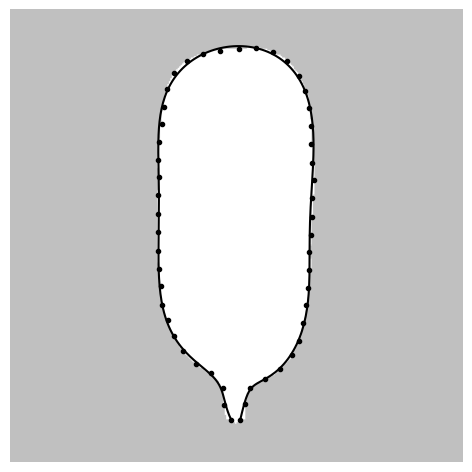

In [92]:
checkTo11(5,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

..
CP 5.0, steps:1, etime: 6.31250 err: 4.6031383343
................
CP 2.0, steps:17, etime: 22.15625 err: 1.9992659659
..........................................E

TEST ./pics\Beztest.png


((0.9941089803293102, 0.9941089803293102),
 64.1875,
 60,
 [[138.0, 279.0],
  [152.83540181639663, 149.43008342918796],
  [194.47864897823277, 569.0478948252273],
  [-1239.5481278823422, -455.0423426204876],
  [3957.842372760068, 921.7894671519953],
  [-6316.296514539837, -1348.0662743588546],
  [7130.323181866903, 1518.5263895724154],
  [-4813.442827357621, -1326.3933824793394],
  [2637.9231989692803, 821.2889277721703],
  [-406.29882545979814, 191.5509826478955],
  [251.16468325913013, 207.7708819306266],
  [144.0, 281.0]])

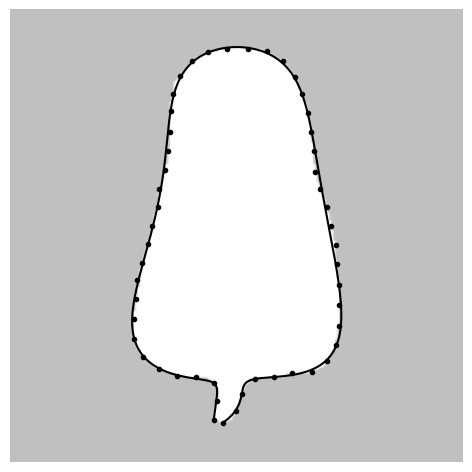

In [93]:
checkTo11(6,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 5.29688 err: 3.0998941728
.
CP 2.0, steps:1, etime: 6.29688 err: 1.6223448417
..E

TEST ./pics\Beztest.png


((0.9209335273131594, 0.9209335273131594),
 8.328125,
 4,
 [[168.0, 279.0],
  [164.47385194772605, 184.2748751551563],
  [188.02262929346884, 542.1796297734446],
  [460.4600351484485, -986.8891040186559],
  [-665.0603687612601, 2153.07542501395],
  [1759.844806768316, -2135.6423822964275],
  [-1633.2128746406433, 771.2386115853636],
  [1356.6229594528693, 392.64811441304937],
  [-469.3582244695911, -312.42720363955436],
  [257.09983468863965, 418.7907790874009],
  [113.52014510388074, 195.09530196103424],
  [161.0, 281.0]])

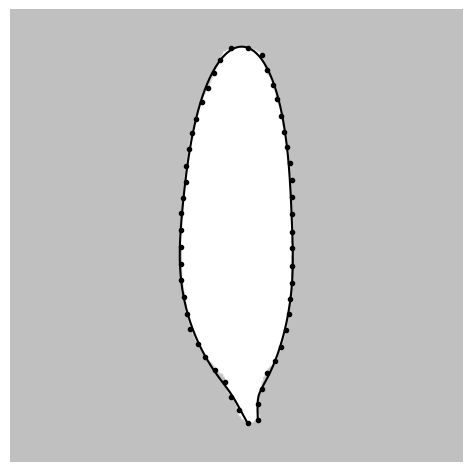

In [94]:
checkTo11(7,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

.
CP 5.0, steps:0, etime: 5.29688 err: 4.0159033497
...
CP 2.0, steps:3, etime: 8.28125 err: 1.8972060448
........................................................................................E

TEST ./pics\Beztest.png


((0.9947625809133516, 0.9947625809133516),
 96.09375,
 92,
 [[166.0, 279.0],
  [167.12222063842782, 240.84977196066916],
  [35.004802624249116, -8.798361832130924],
  [810.5027846244485, 867.7518158876621],
  [-1333.2187846044314, -1336.8534564849494],
  [2471.4305644344263, 1786.8313048157179],
  [-1927.5609855853922, -1777.8178492657455],
  [1230.1077287192434, 1020.8903365632992],
  [-246.19949709297242, -58.84353152226356],
  [183.25957370364415, 202.61251403137896],
  [146.3741290612142, 238.88580460879936],
  [159.0, 280.0]])

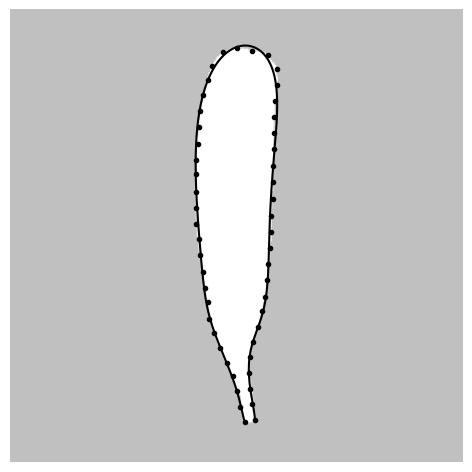

In [95]:
checkTo11(8,N=11,LR=0,Nsamples=51,mode=1,err_th=1,pat=1000,maxTry=3000,lr=0.001)

In [98]:
import tensorflow as tf
tf.__version__
import numpy as np
np.__version__

'1.21.2'

In [99]:
import sympy
sympy.__version__

'1.9'

In [4]:
def getRL(imgnum,N=7,Nsamples=32,itt=3,lr=0.001,lrP=30000,maxTry=1500,pat=300,err_th=1.0,threstune=1.0,withEC=False,trial=None):
    start = time.process_time()
    rd.BezierCurve.mloop_itt = itt
    img = imgs[imgnum]
    conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=5,dbtmdr=5)
    SamplesL = rd.getSamples(conLeft,N=Nsamples,mode='Equidistant')
    SamplesR = rd.getSamples(conRight,N=Nsamples,mode='Equidistant') 
    bezL = rd.BezierCurve(N=N,samples=SamplesL) # インスタンス生成
    bezR = rd.BezierCurve(N=N,samples=SamplesR) # インスタンス生成
    bestcpsL, bestfuncL, minerrorL = bezL.fit1T(maxTry=maxTry, mode=1, lr=lr,lrP=lrP,withErr=True, withEC=withEC,tpara=[], pat=pat, err_th=err_th, threstune=threstune,trial=trial,moption=True)
    bestcpsR, bestfuncR, minerrorR = bezR.fit1T(maxTry=maxTry, mode=1, lr=lr,lrP=lrP,withErr=True, withEC=withEC,tpara=[], pat=pat, err_th=err_th, threstune=threstune,trial=trial,moption=True)
    elapsed_time = time.process_time() - start
    print('tine',elapsed_time)
    return bestfuncL,bestfuncR

ct=['black','black','black','black','black','black','black','black','black','black']

def showAverage(num,n_samples=128):
    fl,fr = getRL(num,N=6)
    fc = (fl+fr)/2
    ps = np.linspace(0,1,n_samples)
    Lpoints = np.array([[int(float(fl[0].subs('t',s))),int(float(fl[1].subs('t',s)))] for s in ps])
    Rpoints = np.array([[int(float(fr[0].subs('t',s))),int(float(fr[1].subs('t',s)))] for s in ps])
    Cpoints = np.array([[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in ps])
    plt.gca().invert_yaxis() 
    plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
    plt.plot(Lpoints[:,0],Lpoints[:,1],color='black')
    plt.plot(Rpoints[:,0],Rpoints[:,1],color='black')
    plt.plot(Cpoints[:,0],Cpoints[:,1],color='black')
    plt.axis('off')

def showAverageAll():
    plt.figure(figsize=(10,10),dpi=75)
    for i in range(3):
        for j in range(3):
            plt.subplot(3,3,3*i+j+1)
            showAverage(3*i+j)

In [5]:
fls,frs = [],[]
for i in range(9):
    fl,fr = getRL(i,N=6)
    fls.append(fl)
    frs.append(fr)

.
CP 5.0, steps:0, etime: 1.51562 err: 1.9717895015
.
CP 2.0, steps:1, etime: 1.71875 err: 1.6399064187
...E

.
CP 5.0, steps:0, etime: 1.23438 err: 1.3787601628
.E

tine 4.03125
.
CP 5.0, steps:0, etime: 1.26562 err: 2.1810913998
.
CP 2.0, steps:1, etime: 1.48438 err: 1.6063652288
..E

.
CP 5.0, steps:0, etime: 1.25000 err: 2.3456505014
.
CP 2.0, steps:1, etime: 1.45312 err: 1.8415698857
......E

tine 4.90625
.E

.E

tine 2.625
.E

.E

tine 2.609375
..
CP 5.0, steps:1, etime: 1.45312 err: 4.5399220833
.......
CP 2.0, steps:8, etime: 2.90625 err: 1.8131060535
......E

.........
CP 5.0, steps:8, etime: 2.90625 err: 4.7446556419
...........
CP 2.0, steps:19, etime: 5.23438 err: 1.8992522944
...........................E

tine 15.609375
.E

.
CP 5.0, steps:0, etime: 1.23438 err: 1.3965707520
.
CP 2.0, steps:1, etime: 1.45312 err: 1.2094184109
^....E

tine 4.078125
.
CP 5.0, steps:0, etime: 1.28125 err: 3.6445191010
...
CP 2.0, steps:3, etime: 1.93750 err: 1.9941944578
.....E

.
CP 5.0, ste

In [6]:
def reSampleAndFit(num,n_samples=32):
    img = imgs[num]
    fl = fls[num] # 左の近似曲線
    fr = frs[num] # 右の近似曲線
    fc = (fl+fr)/2 # 中心線の仮近似
    dp = rd.getDenseParameters(fc,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    samples = [[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in dp]
    samples = np.array(samples)
    # ベジエ曲線の準備
    # rd.BezierCurve.openmode = True
    bezC = rd.BezierCurve(N=4,samples = samples,prefunc=fc) # ,prefunc=fc は使わなくてもあまり変わらない
    # ４次近似を実行
    cps,newfc = bezC.fit0()
    # 結果の描画
    ct=['red', 'red', 'red', 'blue', 'blue', 'blue', 'purple', 'red', 'rikyugreen', 'orange']
    plt.figure(figsize=(10,5),dpi=100)
    plt.subplot(131)
    rd.drawBez0(img,stt=-0.1,end=1.1,bezC=fc,ct=ct)
    plt.subplot(132)
    rd.drawBez0(img,stt=-0.1,end=1.1,bezL=fc,bezC=newfc,ct=ct)
    plt.subplot(133)
    rd.drawBez0(img,stt=-0.1,end=1.1,bezC=newfc,ct=ct)
    return newfc

.
CP 5.0, steps:0, etime: 1.17188 err: 1.9717895015
.
CP 2.0, steps:1, etime: 1.39062 err: 1.6399064187
...E

.
CP 5.0, steps:0, etime: 1.15625 err: 1.3787601628
.E

tine 3.609375


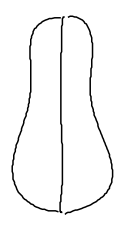

In [19]:
showAverage(0)

.
CP 5.0, steps:0, etime: 1.17188 err: 2.1810913998
.
CP 2.0, steps:1, etime: 1.40625 err: 1.6063652288
..E

.
CP 5.0, steps:0, etime: 1.17188 err: 2.3456505014
.
CP 2.0, steps:1, etime: 1.39062 err: 1.8415698857
......E

tine 4.8125


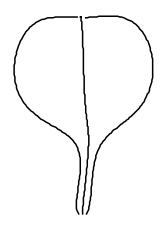

In [20]:
showAverage(1)

.E

.E

tine 2.484375


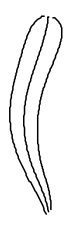

In [21]:
showAverage(2)

.E

.E

tine 2.53125


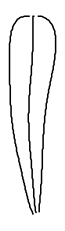

In [22]:
showAverage(3)

..
CP 5.0, steps:1, etime: 1.39062 err: 4.5399220833
.......
CP 2.0, steps:8, etime: 2.87500 err: 1.8131060535
......E

.........
CP 5.0, steps:8, etime: 2.89062 err: 4.7446556419
...........
CP 2.0, steps:19, etime: 5.23438 err: 1.8992522944
...........................E

tine 15.390625


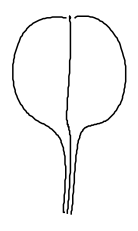

In [23]:
showAverage(4)

.E

.
CP 5.0, steps:0, etime: 1.17188 err: 1.3965707520
.
CP 2.0, steps:1, etime: 1.37500 err: 1.2094184109
^....E

tine 3.8125


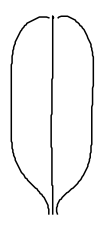

In [24]:
showAverage(5)

.
CP 5.0, steps:0, etime: 1.17188 err: 3.6445191010
...
CP 2.0, steps:3, etime: 1.79688 err: 1.9941944578
.....E

.
CP 5.0, steps:0, etime: 1.15625 err: 4.9067298344
......
CP 2.0, steps:6, etime: 2.48438 err: 1.9566680183
........E

tine 7.28125


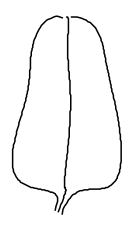

In [25]:
showAverage(6)

.E

.E

tine 2.515625


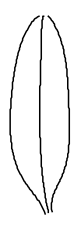

In [26]:
showAverage(7)

.E

.E

tine 2.484375


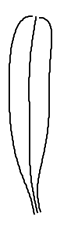

In [27]:
showAverage(8)

In [7]:
ct=['red', 'red', 'black', 'blue', 'blue', 'blue', 'purple', 'red', 'rikyugreen', 'orange']
def reSampleAndFit(num,n_samples=32):
    img = imgs[num]
    fl = fls[num] # 左の近似曲線
    fr = frs[num] # 右の近似曲線
    fc = (fl+fr)/2 # 中心線の仮近似
    dp = rd.getDenseParameters(fc,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    samples = [[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in dp]
    samples = np.array(samples)
    # ベジエ曲線の準備
    # rd.BezierCurve.openmode = True
    bezC = rd.BezierCurve(N=4,samples = samples,prefunc=fc) # ,prefunc=fc は使わなくてもあまり変わらない
    # ４次近似を実行
    cps,newfc = bezC.fit0()
    # 結果の描画
    #plt.figure(figsize=(10,5),dpi=100)
    #plt.subplot(131)
    #rd.drawBez0(img,stt=-0.1,end=1.1,bezC=fc,ct=ct)
    #plt.subplot(132)
    #rd.drawBez0(img,stt=-0.1,end=1.1,bezL=fc,bezC=newfc,ct=ct)
    #plt.subplot(133)
    rd.drawBez0(img,stt=-0.0,end=1.0,bezC=newfc,ct=ct)
    plt.axis('off')
    return newfc

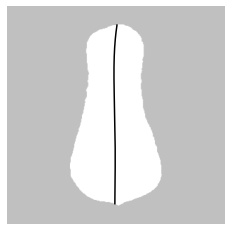

In [33]:
newFC = []
newFC.append(reSampleAndFit(0,n_samples=32))

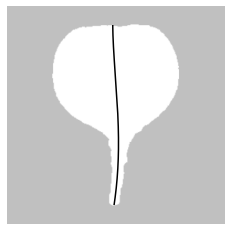

In [34]:
newFC.append(reSampleAndFit(1,n_samples=32))

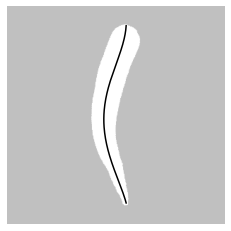

In [35]:
newFC.append(reSampleAndFit(2,n_samples=32))

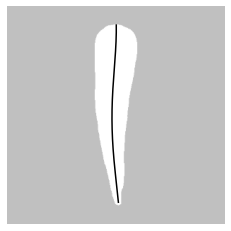

In [36]:
newFC.append(reSampleAndFit(3,n_samples=32))

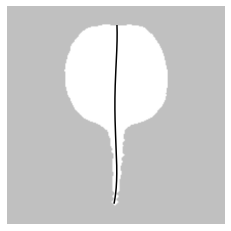

In [37]:
newFC.append(reSampleAndFit(4,n_samples=32))

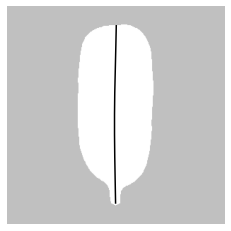

In [38]:
newFC.append(reSampleAndFit(5,n_samples=32))

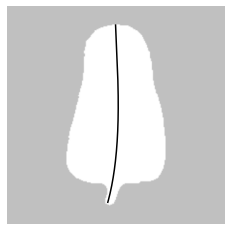

In [39]:
newFC.append(reSampleAndFit(6,n_samples=32))

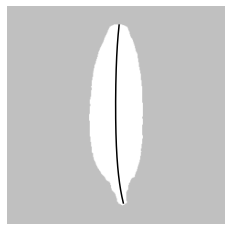

In [40]:
newFC.append(reSampleAndFit(7,n_samples=32))

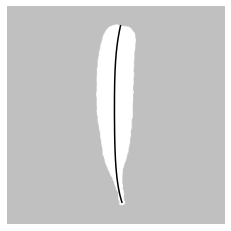

In [41]:
newFC.append(reSampleAndFit(8,n_samples=32))

In [30]:
len(newFC)

9

In [18]:
fLlist = fls
fRlist = frs
# 中心線の法線と輪郭の交点を数式解法で求めて結ぶ
def NormalLadder(num,n_samples=10):
    img = imgs[num]
    fl = fLlist[num]
    fr = fRlist[num]
    fc = newFC[num]
    dp = rd.getDenseParameters(fc,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    samples = np.array([[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in dp])
    # 上端点における法線は両サイドと交差しないことが多いので計算せずに端点をそのまま採用
    lpoints = [[int(float(fl[0].subs('t',0))),int(float(fl[1].subs('t',0)))]]
    rpoints = [[int(float(fr[0].subs('t',0))),int(float(fr[1].subs('t',0)))]]
    for s in dp[1:-1]:
        ldata,rdata = rd.crossPointsLRonEx(fl,fr,fc,s)
        lpoints.append(ldata)
        rpoints.append(rdata)
        print(ldata,rdata)
    # 下端点における端点も計算せずにそのまま採用
    lpoints.append([int(float(fl[0].subs('t',1))),int(float(fl[1].subs('t',1)))])
    rpoints.append([int(float(fr[0].subs('t',1))),int(float(fr[1].subs('t',1)))])
    lpoints = np.array(lpoints)
    rpoints = np.array(rpoints)
    rd.drawBez0(img,stt=0.0,end=1.0,bezL=fl,bezR=fr,bezC=fc,PosL=lpoints,PosR=rpoints,PosC=samples,ladder='normal',ct=ct)

[69, 64] [232, 55]
[63, 90] [241, 80]
[66, 116] [241, 107]
[84, 148] [225, 141]
[122, 172] [193, 170]
[144, 197] [172, 197]
[147, 229] [164, 230]
[145, 255] [161, 257]
Wall time: 1min 17s


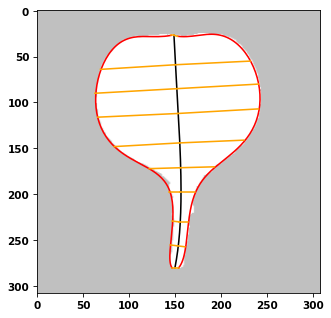

In [177]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder(1,n_samples=10) #時間がかかるのでサンプル数は大きくしないほうがよい

In [19]:
# 図的解法で求めた垂線による断面を描画するプログラム
def NormalLadder20(img,fl,fr,fc,n_samples=32):
    #dpl = rd.getDenseParameters(fl,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    #dpr = rd.getDenseParameters(fr,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    dp = rd.getDenseParameters(fc,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    samples = np.array([[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in dp])
    print('l',len(samples))
    # 上端点における法線は両サイドと交差しないことが多いので計算せずに端点をそのまま採用
    lpoints = [[int(float(fl[0].subs('t',0))),int(float(fl[1].subs('t',0)))]]
    rpoints = [[int(float(fr[0].subs('t',0))),int(float(fr[1].subs('t',0)))]]
    for t0 in dp[1:-1]:
        ldata,rdata = rd.crossPointsLRonImg(img,fc,t0) # 中心線 fcのパラメータ t0の点の法線と画像輪郭の交点を図的に求める
        lpoints.append(ldata)
        rpoints.append(rdata)
    # 下端点における端点も計算せずにそのまま採用
    lpoints.append([int(float(fl[0].subs('t',1))),int(float(fl[1].subs('t',1)))])
    rpoints.append([int(float(fr[0].subs('t',1))),int(float(fr[1].subs('t',1)))])
    lpoints = np.array(lpoints)
    rpoints = np.array(rpoints)
    return lpoints,rpoints,samples,dp
    
def NormalLadder2(num,n_samples=32):
    img = imgs[num]
    fl = fLlist[num]
    fr = fRlist[num]
    fc = newFC[num]
    lpoints,rpoints,samples,_dp = NormalLadder20(img,fl,fr,fc,n_samples=n_samples)
    rd.drawBez0(img,stt=0.0,end=1.0,bezL=fl,bezR=fr,bezC=fc,PosL=lpoints,PosR=rpoints,PosC=samples,ladder='normal',ct=ct)


l 32
Wall time: 333 ms


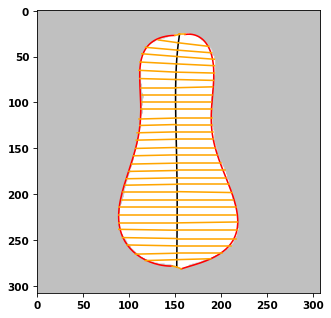

In [43]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder2(0,n_samples=32) # 図的解法は比較的高速なのでサンプル数を大きくとれる

l 32
Wall time: 338 ms


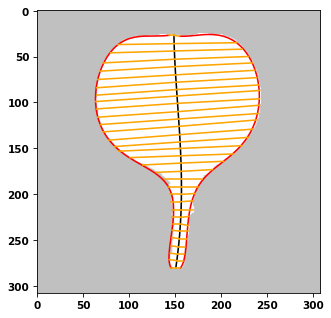

In [44]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder2(1,n_samples=32) # 図的解法は比較的高速なのでサンプル数を大きくとれる

l 32
l 32
l 32


(-0.5, 307.5, 307.5, -0.5)

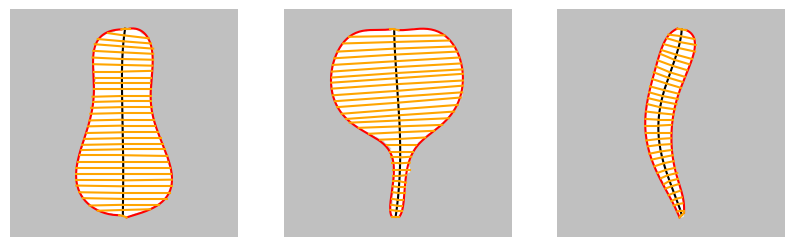

In [45]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(131)
plt.axis("off")
NormalLadder2(0,n_samples=32)
plt.subplot(132)
plt.axis("off")
NormalLadder2(1,n_samples=32)
plt.subplot(133)
plt.axis("off")
NormalLadder2(2,n_samples=32)
plt.axis("off")

l 32
l 32
l 32


(-0.5, 307.5, 307.5, -0.5)

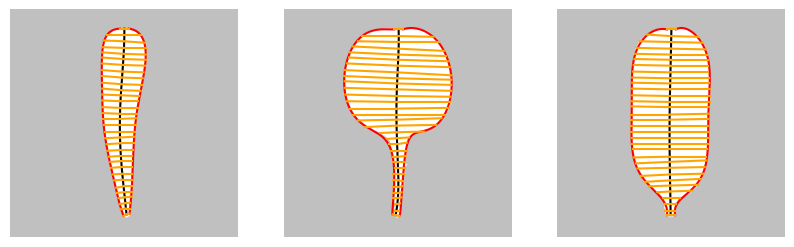

In [46]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(131)
plt.axis("off")
NormalLadder2(3,n_samples=32)
plt.subplot(132)
plt.axis("off")
NormalLadder2(4,n_samples=32)
plt.subplot(133)
plt.axis("off")
NormalLadder2(5,n_samples=32)
plt.axis("off")

l 32
l 32
l 32


(-0.5, 307.5, 307.5, -0.5)

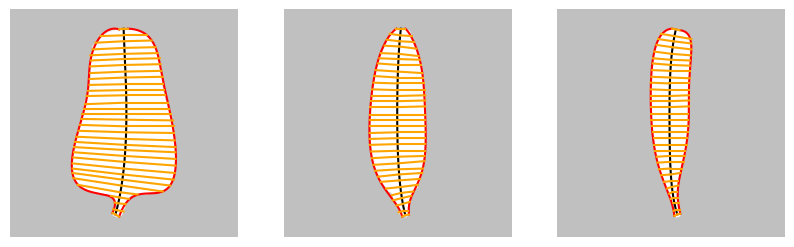

In [47]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(131)
plt.axis("off")
NormalLadder2(6,n_samples=32)
plt.subplot(132)
plt.axis("off")
NormalLadder2(7,n_samples=32)
plt.subplot(133)
plt.axis("off")
NormalLadder2(8,n_samples=32)
plt.axis("off")

In [73]:
# 図的解法で求めた垂線による断面を描画するプログラム
def NormalLadder30(img,fl,fr,fc,n_samples=32):
    t = symbols('t')
    dpl = rd.getDenseParameters(fl,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    dpr = rd.getDenseParameters(fr,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    spl = lpoints = np.array([[int(float(fl[0].subs(t,s))),int(float(fl[1].subs(t,s)))] for s in dpl])
    spr = rpoints = np.array([[int(float(fr[0].subs(t,s))),int(float(fr[1].subs(t,s)))] for s in dpr])
    print(dpl,len(dpl))
    fcx,fcy = fc
    cpoints = [] # 左右の対応点を結ぶ線分と中心線の交点
    dpc = [] # その点のパラメータ
    for [xl,yl],[xr,yr] in zip(spl,spr):
        print('.',end='')
        ans = solve((xr-fcx)*(fcy-yl)-(fcx-xl)*(yr-fcy),t) # 左右の等間隔点を結ぶ線分と中心線の交点
        ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00000001] # 解の実部
        sc = [i for i in ansR if i<=1.02 and -0.02<=i] # ０から１までの範囲の解を抽出 
        cpoints.append([int(float(fcx.subs(t,sc[0]))),int(float(fcy.subs(t,sc[0])))] if sc !=[] else [np.inf,np.inf])
        dpc.append(sc[0] if sc !=[] else np.inf)
    if dpc[0] == np.inf:
        dpc[0] = 0
        cpoints[0] = [int(float(fc[0].subs(t,0))),int(float(fc[1].subs(t,0)))]
    if dpc[-1] == np.inf:
        dpc[-1] = 1
        cpoints[-1] = [int(float(fc[0].subs(t,1))),int(float(fc[1].subs(t,1)))]
    cpoints = np.array(cpoints)
    
    # 上端点における法線は両サイドと交差しないことが多いので計算せずに端点をそのまま採用
    lpoints2 = [[int(float(fl[0].subs(t,0))),int(float(fl[1].subs(t,0)))]]
    rpoints2 = [[int(float(fr[0].subs(t,0))),int(float(fr[1].subs(t,0)))]]
    for t0 in dpc[1:-1]:
        ldata,rdata = rd.crossPointsLRonImg(img,fc,t0) # 中心線 fcのパラメータ t0の点の法線と画像輪郭の交点を図的に求める
        lpoints2.append(ldata)
        rpoints2.append(rdata)
    # 下端点における端点も計算せずにそのまま採用
    lpoints2.append([int(float(fl[0].subs(t,1))),int(float(fl[1].subs(t,1)))])
    rpoints2.append([int(float(fr[0].subs(t,1))),int(float(fr[1].subs(t,1)))])
    lpoints2 = np.array(lpoints2)
    rpoints2 = np.array(rpoints2)
    return lpoints2,rpoints2,cpoints,dpc
        
def NormalLadder3(num,n_samples=32):
    img = imgs[num]
    fl = fLlist[num]
    fr = fRlist[num]
    fc = newFC[num]
    lpoints,rpoints,cpoints,_dpc = NormalLadder30(img,fl,fr,fc,n_samples=n_samples)
    rd.drawBez0(img,stt=0.0,end=1.0,bezL=fl,bezR=fr,bezC=fc,PosL=lpoints,PosR=rpoints,PosC=cpoints,ladder='normal',ct=ct)

................................................................................................

(-0.5, 307.5, 307.5, -0.5)

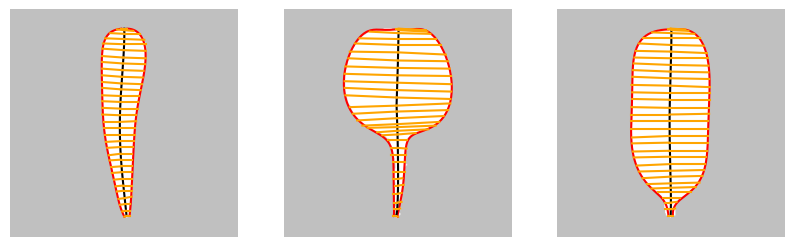

In [228]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(131)
plt.axis("off")
NormalLadder3(3,n_samples=32)
plt.subplot(132)
plt.axis("off")
NormalLadder3(4,n_samples=32)
plt.subplot(133)
plt.axis("off")
NormalLadder3(5,n_samples=32)
plt.axis("off")

[0.0, 0.05024267925508642, 0.0998189569357006, 0.16989529459295477, 0.2228554395213102, 0.2705499454751292, 0.31536824422044435, 0.3707416131839888, 0.41644346342624194, 0.47646085365075497, 0.5261356894780322, 0.5762857670612465, 0.6272314993632493, 0.6951004920125801, 0.7544735154620109, 0.8108323981532902, 0.8678149538858332, 0.9071034535967003, 0.9565159171894957, 1.0] 20
....................

(-0.5, 307.5, 307.5, -0.5)

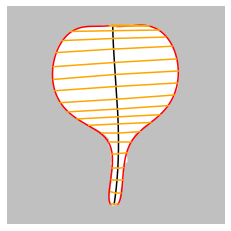

In [74]:
NormalLadder3(1,n_samples=20)
plt.axis('off')

(-0.5, 307.5, 307.5, -0.5)

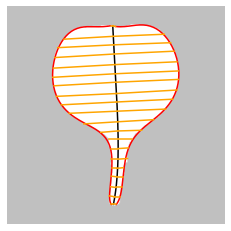

In [248]:
NormalLadder2(1,n_samples=20)
plt.axis('off')

................................

(-0.5, 307.5, 307.5, -0.5)

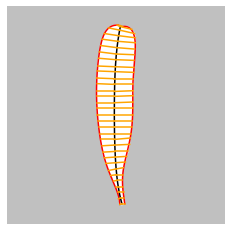

In [231]:
NormalLadder3(8,n_samples=32)
plt.axis('off')

................................................................................................

(-0.5, 307.5, 307.5, -0.5)

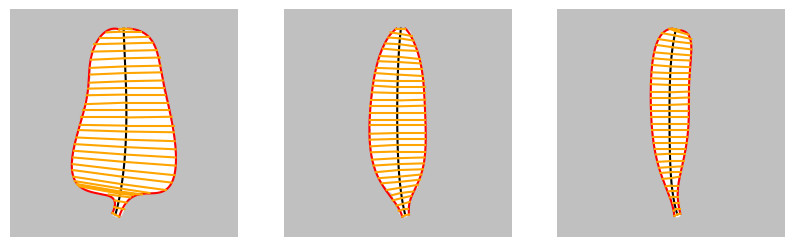

In [42]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(131)
plt.axis("off")
NormalLadder3(6,n_samples=32)
plt.subplot(132)
plt.axis("off")
NormalLadder3(7,n_samples=32)
plt.subplot(133)
plt.axis("off")
NormalLadder3(8,n_samples=32)
plt.axis("off")

In [94]:
# 形状補正

# 計算不能箇所のデータの補間
def interporation(plist):
    while np.sum(plist) == np.inf: # np.inf を含むなら除去を繰り返す
        for i in range(len(plist)):
            if np.sum(plist[i]) == np.inf :
                print("欠",end="")
                if (i !=0 and i !=len(plist)-1) and np.sum(plist[i-1]+plist[i+1]) != np.inf: # 当該は無限で、前後は無限ではない場合
                    plist = np.r_[plist[0:i],[[int(round(((plist[i-1]+plist[i+1])/2)[0])),
                                              int(round(((plist[i-1]+plist[i+1])/2)[1]))]],plist[i+1:]]
                elif len(plist[i:])>=3 and np.sum(plist[i+1]+plist[i+2]) != np.inf:
                    plist = np.r_[plist[0:i],[plist[i+2]-2*(plist[i+2]-plist[i+1])],plist[i+1:]]
                elif len(plist[0:i])>=2 and np.sum(plist[i-1]+plist[i-2]) != np.inf:
                    plist = np.r_[plist[0:i],[plist[i-2]-2*(plist[i-2]-plist[i-1])],plist[i+1:]]
    return plist

# 補正形状を求める
def reformRadish2(num,N=8,topZero=False,n_samples=24):
    img = imgs[num] 
    fl = fLlist[num]
    fr = fRlist[num]
    fc = newFC[num]
    lpoints2,rpoints2,cpoints,dpc = NormalLadder30(img,fl,fr,fc,n_samples=n_samples)
    print("\nPair Detection Complete")

    # 各サンプル点における幅を求める
    lpoints2 = interporation(lpoints2)
    rpoints2 = interporation(rpoints2)
    width = []
    for [lx,ly],[rx,ry] in zip(lpoints2,rpoints2):
        w = np.sqrt((lx-rx)*(lx-rx)+(ly-ry)*(ly-ry))
        width.append(w)
    print("Width Samples Collected")

    # 各サンプル点までの距離を求める
    dp,lengths = rd.getDenseParameters(fc,n_samples=128,span=0,needlength=True)
    found = [0.0]
    i = 1
    for n in range(1,len(dpc)-1):
        t = dpc[n]
        while dp[i] < t:
            i = i+1
        if t == dp[i]:
            found.append(lengths[i])
        else:
            found.append(((dp[i]-t)*lengths[i-1]+(t-dp[i-1])*lengths[i])/(dp[i]-dp[i-1]))
    found.append(lengths[-1])

    if topZero :
        width = [0,10]+width[1:-1]+[10,0] # 少し姑息だが　端点を閉じる目的　
        found = [found[0]]+found+[found[-1]]
        
    # 形状補正データのサンプルの生成
    samples = np.array([[int(round(l)),int(round(w))] for l,w in zip(width,found)])
    rd.BezierCurve.mloop_itt=3
    bez = rd.BezierCurve(N=N,samples=samples) # インスタンス生成
    cps, fc, minerrorL = bez.fit1T(maxTry=100, mode=1, pat=1000, lr=0.001,lrP=30000,scatter=True,
            withErr=True, withEC=False,tpara=[], err_th=1.0, threstune=1.0,trial=False,moption=True)
    # cps,fc = bez.fitT1(maxTry=10)
    print(cps)
    # 結果の描画
    gx,gy,(x,y,w,h,a) = rd.getCoG(img)
    ssamples=[]
    for [a,b] in samples:
        ssamples.append([a/2,y+b])
    ssamples = np.array(ssamples)
    rd.drawBez(rdimg=img,stt=0.0,end=1.0,bezL=[-fc[0]/2,y+fc[1]],bezR=[fc[0]/2,y+fc[1]],ct=ct,cntL=ssamples)
    
    print("補正後の全長は {:3.1f} pixels".format(found[-1]))
    print("最大幅は {:3.1f} pixels".format(np.array(width).max()))
    return fc

[0.0, 0.05030123772417623, 0.09205593403530518, 0.1429392257698686, 0.1851595951533868, 0.2423392550825604, 0.29195348064236126, 0.3557090923977395, 0.40395204548679375, 0.44770405916869876, 0.4968312839903757, 0.5332088298244261, 0.5771010228406191, 0.6124690747842233, 0.6594143097197726, 0.7015902004487717, 0.7623627370976221, 0.8116534359712948, 0.8666364590880512, 0.9104898734780588, 0.9754723233885519, 1.0] 22
......................
Pair Detection Complete
Width Samples Collected
...........
CP 5.0, steps:10, etime: 2.54688 err: 4.6566911979
..........
CP 2.0, steps:20, etime: 4.21875 err: 1.9676706621
......................................................E

[[12.0, 0.0], [188.4763287593143, 13.992100372501222], [12.617049249549892, 141.6723077523207], [77.54472349418316, -73.84963523657935], [337.547560326985, 437.6271867394805], [15.174736652475094, 137.06986038857525], [10.0, 265.0]]
補正後の全長は 265.1 pixels
最大幅は 138.6 pixels


Matrix([
[10.0*t**6 + 15.1747366524751*t**5*(6 - 6*t) + 5063.21340490477*t**4*(1 - t)**2 + 1550.89446988366*t**3*(1 - t)**3 + 189.255738743248*t**2*(1 - t)**4 + 1130.85797255589*t*(1 - t)**5 + 12.0*(1 - t)**6],
[                 265.0*t**6 + 137.069860388575*t**5*(6 - 6*t) + 6564.40780109221*t**4*(1 - t)**2 - 1476.99270473159*t**3*(1 - t)**3 + 2125.08461628481*t**2*(1 - t)**4 + 83.9526022350073*t*(1 - t)**5]])

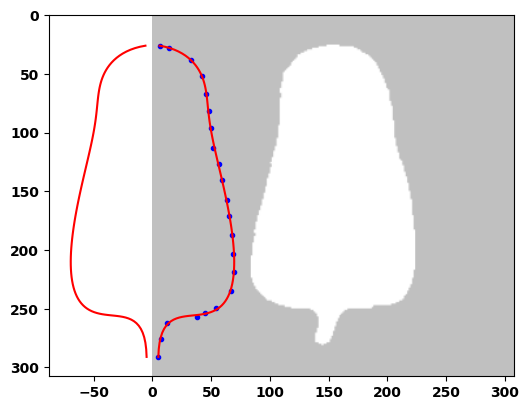

In [95]:
reformRadish2(6,N=6,n_samples=22)

[0.0, 0.04125238291318313, 0.08485015543134919, 0.13576005945026107, 0.19856437591848042, 0.245873088869504, 0.30324378376255323, 0.3488356031050721, 0.3944147934311291, 0.43966950841982666, 0.4951023240748202, 0.538341087447903, 0.5808634821268034, 0.6338734668709891, 0.6770405439476432, 0.7330282354447469, 0.7795622831255067, 0.826398452851417, 0.8822737654538286, 0.9236635610064817, 0.9627661678240476, 1.0] 22
......................
Pair Detection Complete
欠Width Samples Collected
...
CP 5.0, steps:2, etime: 1.34375 err: 4.1855800179
......
CP 2.0, steps:8, etime: 2.34375 err: 1.8348508272
.....E

[[11.0, 0.0], [152.73374103865066, 9.103355600407616], [85.89665927456873, 113.56494667379725], [-102.1145520786201, 81.92189848888614], [332.718486054997, 232.96169446373983], [106.59354250330472, 247.19441132721556], [10.0, 258.0]]
補正後の全長は 258.2 pixels
最大幅は 129.0 pixels


Matrix([
[10.0*t**6 + 106.593542503305*t**5*(6 - 6*t) + 4990.77729082496*t**4*(1 - t)**2 - 2042.2910415724*t**3*(1 - t)**3 + 1288.44988911853*t**2*(1 - t)**4 + 916.402446231904*t*(1 - t)**5 + 11.0*(1 - t)**6],
[                 258.0*t**6 + 247.194411327216*t**5*(6 - 6*t) + 3494.4254169561*t**4*(1 - t)**2 + 1638.43796977772*t**3*(1 - t)**3 + 1703.47420010696*t**2*(1 - t)**4 + 54.6201336024457*t*(1 - t)**5]])

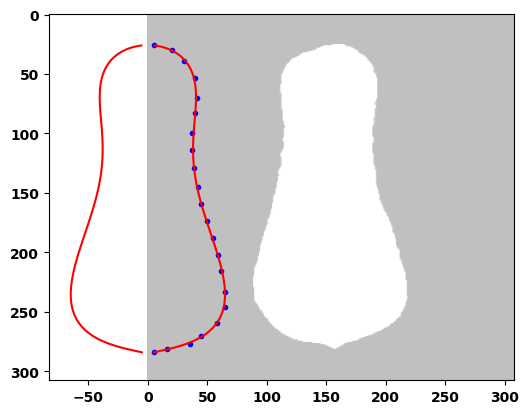

In [96]:
reformRadish2(0,N=6,n_samples=22)

[0.0, 0.04502783676338121, 0.08872410927699075, 0.15141796909306446, 0.20112078605502384, 0.24625178855991148, 0.29805893048356813, 0.3380655118496235, 0.37835573733883027, 0.4199349340726784, 0.4743048461225088, 0.5191926311780362, 0.5758889765388835, 0.6219111469389993, 0.6699938805917529, 0.7354915736132203, 0.7887611232068706, 0.834801470500255, 0.882702819412147, 0.9176078136883073, 0.9535593826221508, 1.0] 22
......................
Pair Detection Complete
欠欠欠Width Samples Collected
.......
CP 5.0, steps:6, etime: 2.01562 err: 4.8776851521
.........
CP 2.0, steps:15, etime: 3.54688 err: 1.8336140617
.........E

[[11.0, 0.0], [154.82272251725195, 10.123939560940116], [221.60681618590056, -93.67862333780701], [318.27955316215287, 417.9099787262942], [-101.76595511916958, -63.18221292050696], [46.588463098240325, 239.42580307958033], [10.0, 263.0]]
補正後の全長は 263.5 pixels
最大幅は 177.3 pixels


Matrix([
[10.0*t**6 + 46.5884630982403*t**5*(6 - 6*t) - 1526.48932678754*t**4*(1 - t)**2 + 6365.59106324306*t**3*(1 - t)**3 + 3324.10224278851*t**2*(1 - t)**4 + 928.936335103512*t*(1 - t)**5 + 11.0*(1 - t)**6],
[                  263.0*t**6 + 239.42580307958*t**5*(6 - 6*t) - 947.733193807604*t**4*(1 - t)**2 + 8358.19957452588*t**3*(1 - t)**3 - 1405.17935006711*t**2*(1 - t)**4 + 60.7436373656407*t*(1 - t)**5]])

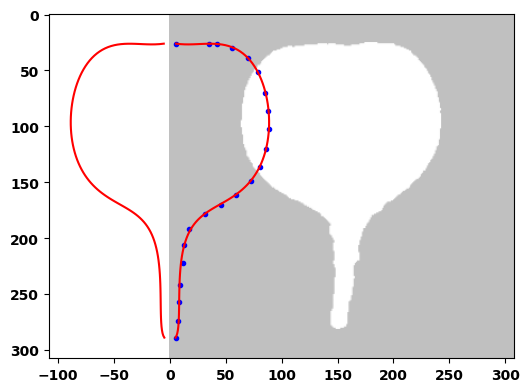

In [97]:
reformRadish2(1,N=6,n_samples=22)

[0.0, 0.056699320156837894, 0.10450597583996471, 0.1621426346724185, 0.20701351789936462, 0.2514807584420208, 0.2959087133696276, 0.35161396398548694, 0.39633552814220696, 0.4411191366885199, 0.4969663467620331, 0.5413291181969858, 0.5852723315360925, 0.6396020841916756, 0.6827601029554877, 0.7259435121134131, 0.7695039934180709, 0.8249649212644143, 0.8702005307420261, 0.9155134442021631, 0.9695826752584671, 1.0] 22
......................
Pair Detection Complete
Width Samples Collected
.
CP 5.0, steps:0, etime: 1.00000 err: 1.3560162402
.
CP 2.0, steps:1, etime: 1.17188 err: 1.0027654809
.E

[[12.0, 0.0], [99.23899847612816, 16.922834471854692], [-29.96226163489733, 149.73928358775407], [95.84728783875758, 106.90268137938247], [4.654727906735586, 198.92139328643472], [28.427262958389264, 239.92499393354655], [8.0, 293.0]]
補正後の全長は 293.3 pixels
最大幅は 42.4 pixels


Matrix([
[8.0*t**6 + 28.4272629583893*t**5*(6 - 6*t) + 69.8209186010338*t**4*(1 - t)**2 + 1916.94575677515*t**3*(1 - t)**3 - 449.43392452346*t**2*(1 - t)**4 + 595.433990856769*t*(1 - t)**5 + 12.0*(1 - t)**6],
[               293.0*t**6 + 239.924993933547*t**5*(6 - 6*t) + 2983.82089929652*t**4*(1 - t)**2 + 2138.05362758765*t**3*(1 - t)**3 + 2246.08925381631*t**2*(1 - t)**4 + 101.537006831128*t*(1 - t)**5]])

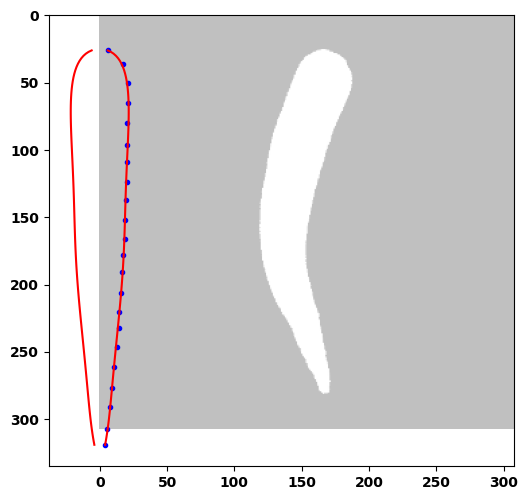

In [98]:
reformRadish2(2,N=6,n_samples=22)

[0.0, 0.050636003832181954, 0.1008307649634008, 0.14728480122280058, 0.2001021345756132, 0.2406220870745641, 0.28091847824617955, 0.33199810506003735, 0.3738703308884308, 0.42766540057932056, 0.47176654571221555, 0.516577732696961, 0.5618231390069232, 0.6186463570464147, 0.6642046028242128, 0.7099212141766714, 0.767559663051313, 0.8142502742526618, 0.8731345530314164, 0.9197507861744475, 0.9642782880246953, 1.0] 22
......................
Pair Detection Complete
Width Samples Collected
.
CP 5.0, steps:0, etime: 0.98438 err: 3.2221843402
..
CP 2.0, steps:2, etime: 1.34375 err: 1.6954859564
..E

[[12.0, 0.0], [119.18786651532479, 6.083135482941276], [11.03861547249414, 95.35628123310687], [69.36144339105623, 132.18546114273818], [27.22439255796919, 151.7594054176991], [28.559237074437, 221.96664085730495], [9.0, 263.0]]
補正後の全長は 262.7 pixels
最大幅は 59.1 pixels


Matrix([
[9.0*t**6 + 28.559237074437*t**5*(6 - 6*t) + 408.365888369538*t**4*(1 - t)**2 + 1387.22886782112*t**3*(1 - t)**3 + 165.579232087412*t**2*(1 - t)**4 + 715.127199091949*t*(1 - t)**5 + 12.0*(1 - t)**6],
[                263.0*t**6 + 221.966640857305*t**5*(6 - 6*t) + 2276.39108126549*t**4*(1 - t)**2 + 2643.70922285476*t**3*(1 - t)**3 + 1430.3442184966*t**2*(1 - t)**4 + 36.4988128976477*t*(1 - t)**5]])

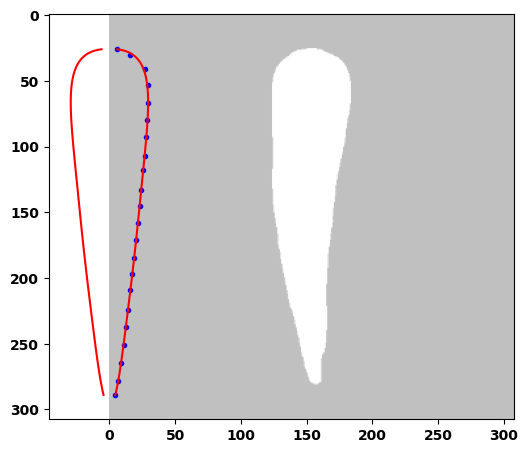

In [99]:
reformRadish2(3,N=6,n_samples=22)

[0.0, 0.05825915293994516, 0.10453751248860531, 0.15029702865440803, 0.20292755344999977, 0.24116583577076986, 0.2773718704302732, 0.31291748390632823, 0.3583503918712193, 0.397096832568379, 0.4509351235001077, 0.4998801394580248, 0.5682508153378707, 0.6272978589613395, 0.6889335854027157, 0.7455996699592886, 0.8002228373302789, 0.8351664421773076, 0.8663146434484604, 0.8961747178577463, 0.9361173538932664, 1.0] 22
......................
Pair Detection Complete
欠欠Width Samples Collected
............
CP 5.0, steps:11, etime: 2.84375 err: 4.9343989547
...............
CP 2.0, steps:26, etime: 5.39062 err: 1.9583885637
.........................................................................

[[12.0, 0.0], [103.30451644053336, -9.815755203852918], [306.6765237965307, 1.4009697254490123], [58.039719203819054, 382.27944947731663], [24.527061582893694, -50.19912557569977], [10.924775355523826, 195.40961356620318], [9.0, 258.0]]
補正後の全長は 257.8 pixels
最大幅は 144.1 pixels


Matrix([
[9.0*t**6 + 10.9247753555238*t**5*(6 - 6*t) + 367.905923743405*t**4*(1 - t)**2 + 1160.79438407638*t**3*(1 - t)**3 + 4600.14785694796*t**2*(1 - t)**4 + 619.8270986432*t*(1 - t)**5 + 12.0*(1 - t)**6],
[              258.0*t**6 + 195.409613566203*t**5*(6 - 6*t) - 752.986883635496*t**4*(1 - t)**2 + 7645.58898954633*t**3*(1 - t)**3 + 21.0145458817352*t**2*(1 - t)**4 - 58.8945312231175*t*(1 - t)**5]])

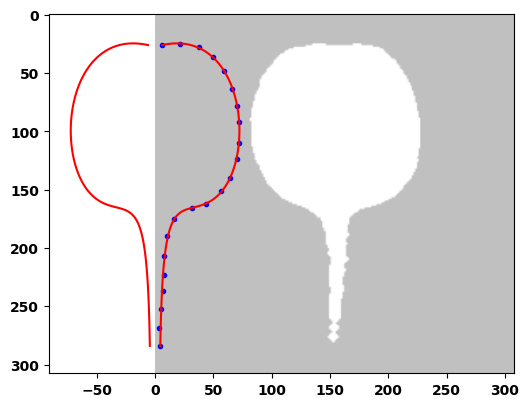

In [100]:
reformRadish2(4,N=6,n_samples=22)

[0.0, 0.05516772216806456, 0.10094302365965549, 0.14703883692280167, 0.20472223371671766, 0.25041540307617616, 0.2953302187467684, 0.3502345701904529, 0.39324072417357003, 0.435559130487239, 0.48774200406543394, 0.5292277855306066, 0.5709008916710686, 0.6240547586117373, 0.6681089992505486, 0.7254833679569257, 0.772367030527964, 0.8184651026035781, 0.8629325850923822, 0.9174147875011626, 0.9615201921979774, 1.0] 22
......................
Pair Detection Complete
Width Samples Collected
........
CP 5.0, steps:7, etime: 2.17188 err: 4.7166423995
...........
CP 2.0, steps:18, etime: 4.00000 err: 1.9211880894
............E

[[12.0, 0.0], [96.56349974869237, -12.122946354436431], [199.7624838779065, 82.66348659502486], [-43.99588240356538, 80.3327866990631], [257.38111418480906, 249.6870863529644], [14.202100346810788, 187.52701197392878], [11.0, 255.0]]
補正後の全長は 254.8 pixels
最大幅は 106.0 pixels


Matrix([
[11.0*t**6 + 14.2021003468108*t**5*(6 - 6*t) + 3860.71671277214*t**4*(1 - t)**2 - 879.917648071308*t**3*(1 - t)**3 + 2996.4372581686*t**2*(1 - t)**4 + 579.380998492154*t*(1 - t)**5 + 12.0*(1 - t)**6],
[                255.0*t**6 + 187.527011973929*t**5*(6 - 6*t) + 3745.30629529447*t**4*(1 - t)**2 + 1606.65573398126*t**3*(1 - t)**3 + 1239.95229892537*t**2*(1 - t)**4 - 72.7376781266186*t*(1 - t)**5]])

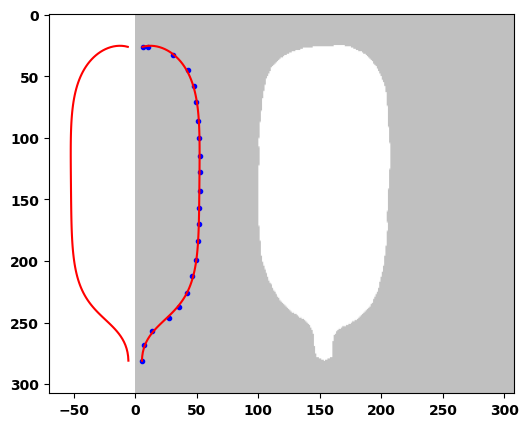

In [101]:
reformRadish2(5,N=6,n_samples=22)

[0.0, 0.05030123772417623, 0.09205593403530518, 0.1429392257698686, 0.1851595951533868, 0.2423392550825604, 0.29195348064236126, 0.3557090923977395, 0.40395204548679375, 0.44770405916869876, 0.4968312839903757, 0.5332088298244261, 0.5771010228406191, 0.6124690747842233, 0.6594143097197726, 0.7015902004487717, 0.7623627370976221, 0.8116534359712948, 0.8666364590880512, 0.9104898734780588, 0.9754723233885519, 1.0] 22
......................
Pair Detection Complete
Width Samples Collected
...........
CP 5.0, steps:10, etime: 2.62500 err: 4.6566911979
..........
CP 2.0, steps:20, etime: 4.31250 err: 1.9676706621
......................................................E

[[12.0, 0.0], [188.4763287593143, 13.992100372501222], [12.617049249549892, 141.6723077523207], [77.54472349418316, -73.84963523657935], [337.547560326985, 437.6271867394805], [15.174736652475094, 137.06986038857525], [10.0, 265.0]]
補正後の全長は 265.1 pixels
最大幅は 138.6 pixels


Matrix([
[10.0*t**6 + 15.1747366524751*t**5*(6 - 6*t) + 5063.21340490477*t**4*(1 - t)**2 + 1550.89446988366*t**3*(1 - t)**3 + 189.255738743248*t**2*(1 - t)**4 + 1130.85797255589*t*(1 - t)**5 + 12.0*(1 - t)**6],
[                 265.0*t**6 + 137.069860388575*t**5*(6 - 6*t) + 6564.40780109221*t**4*(1 - t)**2 - 1476.99270473159*t**3*(1 - t)**3 + 2125.08461628481*t**2*(1 - t)**4 + 83.9526022350073*t*(1 - t)**5]])

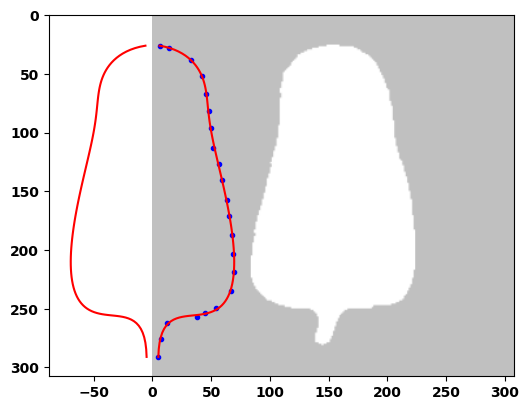

In [102]:
reformRadish2(6,N=6,n_samples=22)

[0.0, 0.06361531090730899, 0.1096441591273173, 0.15429385205037854, 0.20996633700178552, 0.2549155242638403, 0.30017730276676374, 0.3454181700274372, 0.40133352320326754, 0.4452161937507228, 0.48826677534391444, 0.541129570262994, 0.5830157076864363, 0.624955043120957, 0.6780736478024088, 0.7215429934411801, 0.7660425183787305, 0.8228196483605628, 0.8685830564857134, 0.9140941717139557, 0.9587005473420285, 1.0] 22
......................
Pair Detection Complete
Width Samples Collected
.
CP 5.0, steps:0, etime: 1.01562 err: 2.1683156640
.
CP 2.0, steps:1, etime: 1.17188 err: 1.1108086285
.E

[[12.0, 0.0], [61.88812013469997, 27.94121755774028], [113.8225969882912, 108.58379401656038], [6.123380630538092, 96.57408036066037], [166.08055426647653, 198.81691889526562], [18.662875132682608, 209.34479343775428], [9.0, 264.0]]
補正後の全長は 263.9 pixels
最大幅は 75.0 pixels


Matrix([
[9.0*t**6 + 18.6628751326826*t**5*(6 - 6*t) + 2491.20831399715*t**4*(1 - t)**2 + 122.467612610762*t**3*(1 - t)**3 + 1707.33895482437*t**2*(1 - t)**4 + 371.3287208082*t*(1 - t)**5 + 12.0*(1 - t)**6],
[              264.0*t**6 + 209.344793437754*t**5*(6 - 6*t) + 2982.25378342898*t**4*(1 - t)**2 + 1931.48160721321*t**3*(1 - t)**3 + 1628.75691024841*t**2*(1 - t)**4 + 167.647305346442*t*(1 - t)**5]])

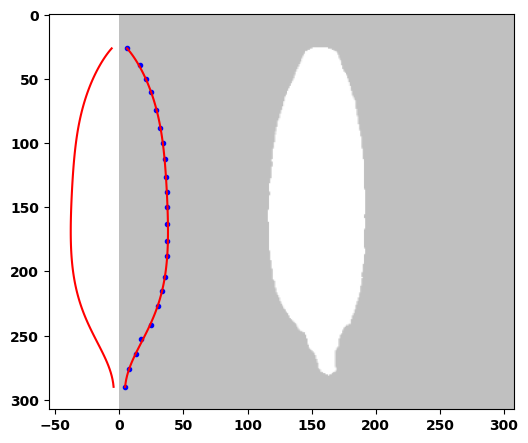

In [103]:
reformRadish2(7,N=6,n_samples=22)

[0.0, 0.061898895165879264, 0.11054858038587072, 0.15507614260993524, 0.20794505082813847, 0.24963048944990626, 0.29154334761292683, 0.3446865423387711, 0.38780277507555594, 0.4312577279582788, 0.4856931432596888, 0.5291314001762722, 0.5724398637224508, 0.6157400259393241, 0.6702288070573447, 0.7145063073642222, 0.7712449841090645, 0.817960379897086, 0.8655834889016126, 0.9245801926344398, 0.968456662119493, 1.0] 22
......................
Pair Detection Complete
Width Samples Collected
.
CP 5.0, steps:0, etime: 1.31250 err: 1.7388809680
.
CP 2.0, steps:1, etime: 1.51562 err: 1.2429193657
..E

[[10.0, 0.0], [106.27643363155106, 11.500110123882658], [-5.788072814050726, 138.93372589751047], [89.7214810436019, 74.30872582525338], [58.125617218981, 201.9093862932216], [-1.0944480294805579, 205.94201739760476], [9.0, 265.0]]
補正後の全長は 265.3 pixels
最大幅は 52.0 pixels


Matrix([
[9.0*t**6 - 1.09444802948056*t**5*(6 - 6*t) + 871.884258284715*t**4*(1 - t)**2 + 1794.42962087204*t**3*(1 - t)**3 - 86.8210922107609*t**2*(1 - t)**4 + 637.658601789306*t*(1 - t)**5 + 10.0*(1 - t)**6],
[                 265.0*t**6 + 205.942017397605*t**5*(6 - 6*t) + 3028.64079439832*t**4*(1 - t)**2 + 1486.17451650507*t**3*(1 - t)**3 + 2084.00588846266*t**2*(1 - t)**4 + 69.000660743296*t*(1 - t)**5]])

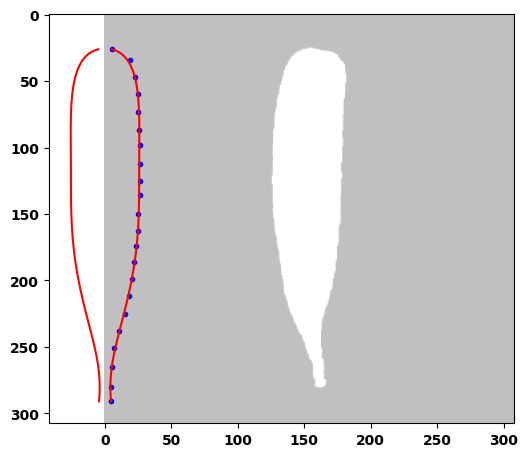

In [104]:
reformRadish2(8,N=6,n_samples=22)

[0.0, 0.06361531090730899, 0.1096441591273173, 0.15429385205037854, 0.20996633700178552, 0.2549155242638403, 0.30017730276676374, 0.3454181700274372, 0.40133352320326754, 0.4452161937507228, 0.48826677534391444, 0.541129570262994, 0.5830157076864363, 0.624955043120957, 0.6780736478024088, 0.7215429934411801, 0.7660425183787305, 0.8228196483605628, 0.8685830564857134, 0.9140941717139557, 0.9587005473420285, 1.0] 22
......................
Pair Detection Complete
Width Samples Collected
.
CP 5.0, steps:0, etime: 0.89062 err: 2.1683156640
.
CP 2.0, steps:1, etime: 1.07812 err: 1.1108086285
.E

[[12.0, 0.0], [61.88812013469997, 27.94121755774028], [113.8225969882912, 108.58379401656038], [6.123380630538092, 96.57408036066037], [166.08055426647653, 198.81691889526562], [18.662875132682608, 209.34479343775428], [9.0, 264.0]]
補正後の全長は 263.9 pixels
最大幅は 75.0 pixels


Matrix([
[9.0*t**6 + 18.6628751326826*t**5*(6 - 6*t) + 2491.20831399715*t**4*(1 - t)**2 + 122.467612610762*t**3*(1 - t)**3 + 1707.33895482437*t**2*(1 - t)**4 + 371.3287208082*t*(1 - t)**5 + 12.0*(1 - t)**6],
[              264.0*t**6 + 209.344793437754*t**5*(6 - 6*t) + 2982.25378342898*t**4*(1 - t)**2 + 1931.48160721321*t**3*(1 - t)**3 + 1628.75691024841*t**2*(1 - t)**4 + 167.647305346442*t*(1 - t)**5]])

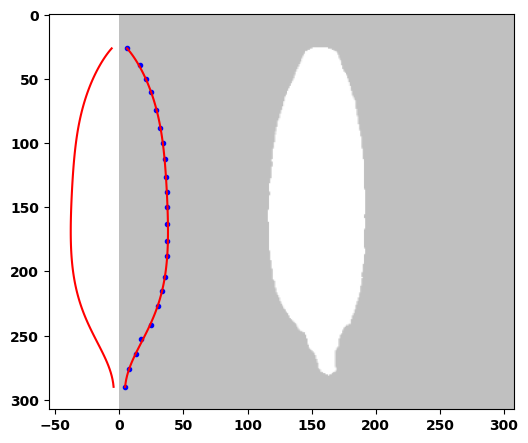

In [105]:
reformRadish2(7,N=6,n_samples=22)